In [ ]:
!pip install -q PyTDC rdkit-pypi torch-geometric pandas tqdm deepchem fair-esm biopython torch

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import deepchem as dc

In [ ]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [ ]:
# protein_train_dataset = []
# protein_valid_dataset = []
# protein_test_dataset = []

# # Go through features and add protein pdb to it
# for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
#   # Convert X (a numpy array) to a list of lists
#   print(X)
#   X_list = X.tolist()

#   # Append the modified string to the first inner list
#   pocket_path = X_list[0][1]
#   protein_path = pocket_path.replace("pocket", "protein")
#   X_list[0].append(protein_path)

#   # Convert back to numpy array if needed
#   X = np.array(X_list, dtype=object)
#   train_dataset.X = X
#   # Print to verify
#   print(X)
# #   break

In [17]:
# # Go through features and add protein pdb to it
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
   print(X)
   break

[['/tmp/refined-set/2qbw/2qbw_ligand.sdf'
  '/tmp/refined-set/2qbw/2qbw_pocket.pdb']]


In [ ]:
# import matplotlib.pyplot as plt


# def extract_sequence_from_pdb(pdb_path):
#     """Extracts the amino acid sequence from a PDB file using Biopython."""
#     parser = PDB.PDBParser(QUIET=True)
#     structure = parser.get_structure("protein", pdb_path)

#     ppb = PDB.PPBuilder()
#     sequence = ""
#     for pp in ppb.build_peptides(structure):
#         sequence += str(pp.get_sequence())

# # Step 1: Get sequence lengths
# lengths = [len(seq) for seq in protein_sequences]

# # Step 2: Plot histogram
# plt.figure(figsize=(10, 6))
# plt.hist(lengths, bins=range(0, max(lengths)+50, 50), edgecolor='black')
# plt.xlabel("Protein Sequence Length")
# plt.ylabel("Number of Sequences")
# plt.title("Distribution of Protein Sequence Lengths")
# plt.grid(True)
# plt.show()


In [ ]:
import torch
import numpy as np
from rdkit import Chem
from torch_geometric.data import Data

def get_node_features(mol):
    all_node_feats = []
    for atom in mol.GetAtoms():
        node_feats = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),  # convert enum to int
            atom.GetIsAromatic(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            atom.IsInRing(),
            int(atom.GetChiralTag())  # convert enum to int
        ]
        all_node_feats.append(node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(),
            bond.IsInRing()
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Bidirectional edges
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()


In [ ]:
from Bio import PDB
import torch
import esm

def extract_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from a PDB file using Biopython."""
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)

    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

# Define amino acid to index mapping
aa_to_idx = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
    'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18,
    'W': 19, 'Y': 20  # Extend as needed
}

def encode_sequence(seq, aa_to_idx, max_len=100):
    seq_idx = [aa_to_idx.get(aa, 0) for aa in seq]  # 0 for unknowns
    if len(seq_idx) < max_len:
        seq_idx += [0] * (max_len - len(seq_idx))
    else:
        seq_idx = seq_idx[:max_len]
    return seq_idx


In [18]:
example_protein_path = "/tmp/v2013-core/1o3f/1o3f_pocket.pdb"  # Replace with your actual file
example_protein_sequence = extract_sequence_from_pdb(example_protein_path)
print("Sequence:", example_protein_sequence)

example_protein_embedding = encode_sequence(example_protein_sequence, aa_to_idx)
print("ESM Embedding shape:", example_protein_embedding)
example_protein_embedding

Sequence: SPELGFSISGGGRGNPFIFVTRVQPGPAHGAVSLLKTFKDYYGVSYYTVPYYSDYYGSH
ESM Embedding shape: [16, 13, 4, 10, 6, 5, 16, 8, 16, 6, 6, 6, 15, 6, 12, 13, 5, 8, 5, 18, 17, 15, 18, 14, 13, 6, 13, 1, 7, 6, 1, 18, 16, 10, 10, 9, 17, 5, 9, 3, 20, 20, 6, 18, 16, 20, 20, 17, 18, 13, 20, 20, 16, 3, 20, 20, 6, 16, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[16,
 13,
 4,
 10,
 6,
 5,
 16,
 8,
 16,
 6,
 6,
 6,
 15,
 6,
 12,
 13,
 5,
 8,
 5,
 18,
 17,
 15,
 18,
 14,
 13,
 6,
 13,
 1,
 7,
 6,
 1,
 18,
 16,
 10,
 10,
 9,
 17,
 5,
 9,
 3,
 20,
 20,
 6,
 18,
 16,
 20,
 20,
 17,
 18,
 13,
 20,
 20,
 16,
 3,
 20,
 20,
 6,
 16,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [19]:
def t(dc_dataset):
    max_len = 0
    molecule_data = []

    for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
        protein_path = X[0][1]
        print(protein_path)


        protein_sequence = extract_sequence_from_pdb(protein_path)
        max_len = max(max_len, len(protein_sequence))

    return max_len
t(train_dataset)

/tmp/refined-set/2qbw/2qbw_pocket.pdb
/tmp/refined-set/4f0c/4f0c_pocket.pdb
/tmp/refined-set/4k7i/4k7i_pocket.pdb
/tmp/refined-set/1bnw/1bnw_pocket.pdb
/tmp/refined-set/1xbo/1xbo_pocket.pdb
/tmp/refined-set/2bvs/2bvs_pocket.pdb
/tmp/refined-set/4mgd/4mgd_pocket.pdb
/tmp/refined-set/4o3c/4o3c_pocket.pdb
/tmp/refined-set/1zgi/1zgi_pocket.pdb
/tmp/refined-set/2y80/2y80_pocket.pdb
/tmp/refined-set/4idn/4idn_pocket.pdb
/tmp/refined-set/5ia4/5ia4_pocket.pdb
/tmp/refined-set/5k1f/5k1f_pocket.pdb
/tmp/refined-set/3ozt/3ozt_pocket.pdb
/tmp/refined-set/5qay/5qay_pocket.pdb
/tmp/refined-set/1oyt/1oyt_pocket.pdb
/tmp/refined-set/2x96/2x96_pocket.pdb
/tmp/refined-set/2arm/2arm_pocket.pdb
/tmp/refined-set/3t82/3t82_pocket.pdb
/tmp/refined-set/1ndv/1ndv_pocket.pdb
/tmp/refined-set/5g1z/5g1z_pocket.pdb
/tmp/refined-set/3uew/3uew_pocket.pdb
/tmp/refined-set/1gnn/1gnn_pocket.pdb
/tmp/refined-set/1f57/1f57_pocket.pdb
/tmp/refined-set/4qgd/4qgd_pocket.pdb
/tmp/refined-set/5yl2/5yl2_pocket.pdb
/tmp/refined

97

In [20]:
def process_deepchem_dataset(dc_dataset):
    molecule_data = []

    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
        ligand_path = X[0][0]
        print(ligand_path)
        protein_path = X[0][1]
        print(protein_path)

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))

        if ligand_mol is None:
          print(f"Failed to load ligand molecule from {ligand_path}")
          continue  # Skip this sample

        node_feats = get_node_features(ligand_mol)
        edge_feats = get_edge_features(ligand_mol)
        edge_index = get_adjacency_info(ligand_mol)

        protein_sequence = extract_sequence_from_pdb(protein_path)
        target_features = encode_sequence(protein_sequence, aa_to_idx)
        target_features = torch.tensor(target_features, dtype=torch.long).unsqueeze(0)

        data = Data(
            x=node_feats,
            edge_index=edge_index,
            edge_attr=edge_feats,
            y=torch.tensor(y, dtype=torch.float)
        )
        data.target_features = target_features

        molecule_data.append(data)

    return molecule_data

In [21]:
train_graphs = process_deepchem_dataset(train_dataset)
valid_graphs = process_deepchem_dataset(valid_dataset)
test_graphs = process_deepchem_dataset(test_dataset)

# Create DataLoaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

/tmp/refined-set/2qbw/2qbw_ligand.sdf
/tmp/refined-set/2qbw/2qbw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbw/2qbw_ligand.sdf
/tmp/refined-set/4f0c/4f0c_ligand.sdf
/tmp/refined-set/4f0c/4f0c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f0c/4f0c_ligand.sdf
/tmp/refined-set/4k7i/4k7i_ligand.sdf
/tmp/refined-set/4k7i/4k7i_pocket.pdb
/tmp/refined-set/1bnw/1bnw_ligand.sdf
/tmp/refined-set/1bnw/1bnw_pocket.pdb
/tmp/refined-set/1xbo/1xbo_ligand.sdf
/tmp/refined-set/1xbo/1xbo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xbo/1xbo_ligand.sdf
/tmp/refined-set/2bvs/2bvs_ligand.sdf
/tmp/refined-set/2bvs/2bvs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bvs/2bvs_ligand.sdf
/tmp/refined-set/4mgd/4mgd_ligand.sdf
/tmp/refined-set/4mgd/4mgd_pocket.pdb
/tmp/refined-set/4o3c/4o3c_ligand.sdf
/tmp/refined-set/4o3c/4o3c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o3c/4o3c_ligand.sdf
/tmp/refined-set/1zgi/

[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Explicit valence for atom # 35 C, 6, is greater than permitted
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:27:27] Warning: molecule is t

/tmp/refined-set/3b66/3b66_ligand.sdf
/tmp/refined-set/3b66/3b66_pocket.pdb
/tmp/refined-set/3p9l/3p9l_ligand.sdf
/tmp/refined-set/3p9l/3p9l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p9l/3p9l_ligand.sdf
/tmp/refined-set/3d52/3d52_ligand.sdf
/tmp/refined-set/3d52/3d52_pocket.pdb
/tmp/refined-set/1cet/1cet_ligand.sdf
/tmp/refined-set/1cet/1cet_pocket.pdb
/tmp/refined-set/5nw7/5nw7_ligand.sdf
/tmp/refined-set/5nw7/5nw7_pocket.pdb
/tmp/refined-set/2ews/2ews_ligand.sdf
/tmp/refined-set/2ews/2ews_pocket.pdb
/tmp/refined-set/3nu4/3nu4_ligand.sdf
/tmp/refined-set/3nu4/3nu4_pocket.pdb
/tmp/refined-set/3ryx/3ryx_ligand.sdf
/tmp/refined-set/3ryx/3ryx_pocket.pdb
/tmp/refined-set/4avs/4avs_ligand.sdf
/tmp/refined-set/4avs/4avs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4avs/4avs_ligand.sdf
/tmp/refined-set/4az6/4az6_ligand.sdf
/tmp/refined-set/4az6/4az6_pocket.pdb
/tmp/refined-set/3t6b/3t6b_ligand.sdf
/tmp/refined-set/3t6b/3t6b_pocket.pdb
Failed to load l

[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Explicit valence for atom # 47 C, 6, is greater than permitted
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:27] Explicit valence fo

/tmp/refined-set/5egu/5egu_ligand.sdf
/tmp/refined-set/5egu/5egu_pocket.pdb
/tmp/refined-set/4m2r/4m2r_ligand.sdf
/tmp/refined-set/4m2r/4m2r_pocket.pdb
/tmp/refined-set/4w9f/4w9f_ligand.sdf
/tmp/refined-set/4w9f/4w9f_pocket.pdb
/tmp/refined-set/1q84/1q84_ligand.sdf
/tmp/refined-set/1q84/1q84_pocket.pdb
/tmp/refined-set/1mue/1mue_ligand.sdf
/tmp/refined-set/1mue/1mue_pocket.pdb
/tmp/refined-set/6cdl/6cdl_ligand.sdf
/tmp/refined-set/6cdl/6cdl_pocket.pdb
/tmp/refined-set/4cig/4cig_ligand.sdf
/tmp/refined-set/4cig/4cig_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cig/4cig_ligand.sdf
/tmp/refined-set/5za9/5za9_ligand.sdf
/tmp/refined-set/5za9/5za9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5za9/5za9_ligand.sdf
/tmp/refined-set/3iae/3iae_ligand.sdf
/tmp/refined-set/3iae/3iae_pocket.pdb
/tmp/refined-set/5dlx/5dlx_ligand.sdf
/tmp/refined-set/5dlx/5dlx_pocket.pdb
/tmp/refined-set/3r88/3r88_ligand.sdf
/tmp/refined-set/3r88/3r88_pocket.pdb
Failed to load l

[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 19 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 17 N, 4, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/4xtx/4xtx_ligand.sdf
/tmp/refined-set/4xtx/4xtx_pocket.pdb
/tmp/refined-set/4qge/4qge_ligand.sdf
/tmp/refined-set/4qge/4qge_pocket.pdb
/tmp/refined-set/6mu3/6mu3_ligand.sdf
/tmp/refined-set/6mu3/6mu3_pocket.pdb
/tmp/refined-set/5o4f/5o4f_ligand.sdf
/tmp/refined-set/5o4f/5o4f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o4f/5o4f_ligand.sdf
/tmp/refined-set/1w5x/1w5x_ligand.sdf
/tmp/refined-set/1w5x/1w5x_pocket.pdb
/tmp/refined-set/6fhu/6fhu_ligand.sdf
/tmp/refined-set/6fhu/6fhu_pocket.pdb
/tmp/refined-set/1cnw/1cnw_ligand.sdf
/tmp/refined-set/1cnw/1cnw_pocket.pdb
/tmp/refined-set/3gcu/3gcu_ligand.sdf
/tmp/refined-set/3gcu/3gcu_pocket.pdb
/tmp/refined-set/3hf8/3hf8_ligand.sdf
/tmp/refined-set/3hf8/3hf8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hf8/3hf8_ligand.sdf
/tmp/refined-set/4nxv/4nxv_ligand.sdf
/tmp/refined-set/4nxv/4nxv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nxv/4nxv_ligand.sdf
/tmp/refined-set/1

[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/5fsx/5fsx_ligand.sdf
/tmp/refined-set/5fsx/5fsx_pocket.pdb
/tmp/refined-set/4efs/4efs_ligand.sdf
/tmp/refined-set/4efs/4efs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4efs/4efs_ligand.sdf
/tmp/refined-set/2xbp/2xbp_ligand.sdf
/tmp/refined-set/2xbp/2xbp_pocket.pdb
/tmp/refined-set/4rd3/4rd3_ligand.sdf
/tmp/refined-set/4rd3/4rd3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4rd3/4rd3_ligand.sdf
/tmp/refined-set/4pox/4pox_ligand.sdf
/tmp/refined-set/4pox/4pox_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pox/4pox_ligand.sdf
/tmp/refined-set/3gs6/3gs6_ligand.sdf
/tmp/refined-set/3gs6/3gs6_pocket.pdb
/tmp/refined-set/5amg/5amg_ligand.sdf
/tmp/refined-set/5amg/5amg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5amg/5amg_ligand.sdf
/tmp/refined-set/5mqe/5mqe_ligand.sdf
/tmp/refined-set/5mqe/5mqe_pocket.pdb
/tmp/refined-set/3l4v/3l4v_ligand.sdf
/tmp/refined-set/3l4v/3l4v_pocket.pdb
Failed to load ligan

[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 25 S, 7, is greater than permitted
[19:27:28] Warning: molecule is ta

/tmp/refined-set/1p1q/1p1q_ligand.sdf
/tmp/refined-set/1p1q/1p1q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p1q/1p1q_ligand.sdf
/tmp/refined-set/1kdk/1kdk_ligand.sdf
/tmp/refined-set/1kdk/1kdk_pocket.pdb
/tmp/refined-set/1nt1/1nt1_ligand.sdf
/tmp/refined-set/1nt1/1nt1_pocket.pdb
/tmp/refined-set/3ug2/3ug2_ligand.sdf
/tmp/refined-set/3ug2/3ug2_pocket.pdb
/tmp/refined-set/4o05/4o05_ligand.sdf
/tmp/refined-set/4o05/4o05_pocket.pdb
/tmp/refined-set/3oyw/3oyw_ligand.sdf
/tmp/refined-set/3oyw/3oyw_pocket.pdb
/tmp/refined-set/4dzy/4dzy_ligand.sdf
/tmp/refined-set/4dzy/4dzy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dzy/4dzy_ligand.sdf
/tmp/refined-set/4x24/4x24_ligand.sdf
/tmp/refined-set/4x24/4x24_pocket.pdb
/tmp/refined-set/2j7g/2j7g_ligand.sdf
/tmp/refined-set/2j7g/2j7g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2j7g/2j7g_ligand.sdf
/tmp/refined-set/3b3w/3b3w_ligand.sdf
/tmp/refined-set/3b3w/3b3w_pocket.pdb
Failed to load lig

[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5j20/5j20_ligand.sdf
/tmp/refined-set/5j20/5j20_pocket.pdb
/tmp/refined-set/4ivd/4ivd_ligand.sdf
/tmp/refined-set/4ivd/4ivd_pocket.pdb
/tmp/refined-set/5fdc/5fdc_ligand.sdf
/tmp/refined-set/5fdc/5fdc_pocket.pdb
/tmp/refined-set/1elr/1elr_ligand.sdf
/tmp/refined-set/1elr/1elr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1elr/1elr_ligand.sdf
/tmp/refined-set/1pr5/1pr5_ligand.sdf
/tmp/refined-set/1pr5/1pr5_pocket.pdb
/tmp/refined-set/4ngp/4ngp_ligand.sdf
/tmp/refined-set/4ngp/4ngp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ngp/4ngp_ligand.sdf
/tmp/refined-set/4uoh/4uoh_ligand.sdf
/tmp/refined-set/4uoh/4uoh_pocket.pdb
/tmp/refined-set/5hrv/5hrv_ligand.sdf
/tmp/refined-set/5hrv/5hrv_pocket.pdb
/tmp/refined-set/4ocq/4ocq_ligand.sdf
/tmp/refined-set/4ocq/4ocq_pocket.pdb
/tmp/refined-set/4a6l/4a6l_ligand.sdf
/tmp/refined-set/4a6l/4a6l_pocket.pdb
/tmp/refined-set/3ip8/3ip8_ligand.sdf
/tmp/refined-set/3ip8/3ip8_pocket.pdb
/tmp/refined-set

[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 17 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Explicit valence for atom # 24 C, 6, is greater than permitted
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:28] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/2vt3/2vt3_ligand.sdf
/tmp/refined-set/2vt3/2vt3_pocket.pdb
/tmp/refined-set/3fur/3fur_ligand.sdf
/tmp/refined-set/3fur/3fur_pocket.pdb
/tmp/refined-set/2ces/2ces_ligand.sdf
/tmp/refined-set/2ces/2ces_pocket.pdb
/tmp/refined-set/1adl/1adl_ligand.sdf
/tmp/refined-set/1adl/1adl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1adl/1adl_ligand.sdf
/tmp/refined-set/3gkz/3gkz_ligand.sdf
/tmp/refined-set/3gkz/3gkz_pocket.pdb
/tmp/refined-set/3i9g/3i9g_ligand.sdf
/tmp/refined-set/3i9g/3i9g_pocket.pdb
/tmp/refined-set/5gs9/5gs9_ligand.sdf
/tmp/refined-set/5gs9/5gs9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gs9/5gs9_ligand.sdf
/tmp/refined-set/4e6d/4e6d_ligand.sdf
/tmp/refined-set/4e6d/4e6d_pocket.pdb
/tmp/refined-set/4exs/4exs_ligand.sdf
/tmp/refined-set/4exs/4exs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4exs/4exs_ligand.sdf
/tmp/refined-set/6ej2/6ej2_ligand.sdf
/tmp/refined-set/6ej2/6ej2_pocket.pdb
Failed to load lig

[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 8 C, 6, is greater than permitt

/tmp/refined-set/3igp/3igp_ligand.sdf
/tmp/refined-set/3igp/3igp_pocket.pdb
/tmp/refined-set/3ddg/3ddg_ligand.sdf
/tmp/refined-set/3ddg/3ddg_pocket.pdb
/tmp/refined-set/3c79/3c79_ligand.sdf
/tmp/refined-set/3c79/3c79_pocket.pdb
/tmp/refined-set/4hdp/4hdp_ligand.sdf
/tmp/refined-set/4hdp/4hdp_pocket.pdb
/tmp/refined-set/3hl5/3hl5_ligand.sdf
/tmp/refined-set/3hl5/3hl5_pocket.pdb
/tmp/refined-set/3c2r/3c2r_ligand.sdf
/tmp/refined-set/3c2r/3c2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c2r/3c2r_ligand.sdf
/tmp/refined-set/6en5/6en5_ligand.sdf
/tmp/refined-set/6en5/6en5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6en5/6en5_ligand.sdf
/tmp/refined-set/3s78/3s78_ligand.sdf
/tmp/refined-set/3s78/3s78_pocket.pdb
/tmp/refined-set/2jew/2jew_ligand.sdf
/tmp/refined-set/2jew/2jew_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2jew/2jew_ligand.sdf
/tmp/refined-set/4djx/4djx_ligand.sdf
/tmp/refined-set/4djx/4djx_pocket.pdb
Failed to load lig

[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 13 C, 6, is greater than permit

/tmp/refined-set/2r38/2r38_ligand.sdf
/tmp/refined-set/2r38/2r38_pocket.pdb
/tmp/refined-set/4yx4/4yx4_ligand.sdf
/tmp/refined-set/4yx4/4yx4_pocket.pdb
/tmp/refined-set/4igt/4igt_ligand.sdf
/tmp/refined-set/4igt/4igt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4igt/4igt_ligand.sdf
/tmp/refined-set/2x00/2x00_ligand.sdf
/tmp/refined-set/2x00/2x00_pocket.pdb
/tmp/refined-set/1ceb/1ceb_ligand.sdf
/tmp/refined-set/1ceb/1ceb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ceb/1ceb_ligand.sdf
/tmp/refined-set/4w9h/4w9h_ligand.sdf
/tmp/refined-set/4w9h/4w9h_pocket.pdb
/tmp/refined-set/5t9z/5t9z_ligand.sdf
/tmp/refined-set/5t9z/5t9z_pocket.pdb
/tmp/refined-set/3f18/3f18_ligand.sdf
/tmp/refined-set/3f18/3f18_pocket.pdb
/tmp/refined-set/1ai5/1ai5_ligand.sdf
/tmp/refined-set/1ai5/1ai5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ai5/1ai5_ligand.sdf
/tmp/refined-set/3p7i/3p7i_ligand.sdf
/tmp/refined-set/3p7i/3p7i_pocket.pdb
/tmp/refined-set/2

[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 0 C, 6, is greater than permitt

/tmp/refined-set/2wf5/2wf5_ligand.sdf
/tmp/refined-set/2wf5/2wf5_pocket.pdb
/tmp/refined-set/2zmm/2zmm_ligand.sdf
/tmp/refined-set/2zmm/2zmm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zmm/2zmm_ligand.sdf
/tmp/refined-set/1lpz/1lpz_ligand.sdf
/tmp/refined-set/1lpz/1lpz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lpz/1lpz_ligand.sdf
/tmp/refined-set/4oc5/4oc5_ligand.sdf
/tmp/refined-set/4oc5/4oc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc5/4oc5_ligand.sdf
/tmp/refined-set/5vb6/5vb6_ligand.sdf
/tmp/refined-set/5vb6/5vb6_pocket.pdb
/tmp/refined-set/1c5t/1c5t_ligand.sdf
/tmp/refined-set/1c5t/1c5t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5t/1c5t_ligand.sdf
/tmp/refined-set/4gj2/4gj2_ligand.sdf
/tmp/refined-set/4gj2/4gj2_pocket.pdb
/tmp/refined-set/1qan/1qan_ligand.sdf
/tmp/refined-set/1qan/1qan_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qan/1qan_ligand.sdf
/tmp/refined-set/4ufi/

[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/3d51/3d51_ligand.sdf
/tmp/refined-set/3d51/3d51_pocket.pdb
/tmp/refined-set/1o3f/1o3f_ligand.sdf
/tmp/refined-set/1o3f/1o3f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3f/1o3f_ligand.sdf
/tmp/refined-set/5m04/5m04_ligand.sdf
/tmp/refined-set/5m04/5m04_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5m04/5m04_ligand.sdf
/tmp/refined-set/5tmn/5tmn_ligand.sdf
/tmp/refined-set/5tmn/5tmn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tmn/5tmn_ligand.sdf
/tmp/refined-set/5yhe/5yhe_ligand.sdf
/tmp/refined-set/5yhe/5yhe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yhe/5yhe_ligand.sdf
/tmp/refined-set/5ovv/5ovv_ligand.sdf
/tmp/refined-set/5ovv/5ovv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ovv/5ovv_ligand.sdf
/tmp/refined-set/4crf/4crf_ligand.sdf
/tmp/refined-set/4crf/4crf_pocket.pdb
/tmp/refined-set/2qi4/2qi4_ligand.sdf
/tmp/refined-set/2qi4/2qi4_pocket.pdb
/tmp/refined-set/4rj8/

[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/3sut/3sut_ligand.sdf
/tmp/refined-set/3sut/3sut_pocket.pdb
/tmp/refined-set/1jcx/1jcx_ligand.sdf
/tmp/refined-set/1jcx/1jcx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jcx/1jcx_ligand.sdf
/tmp/refined-set/5eij/5eij_ligand.sdf
/tmp/refined-set/5eij/5eij_pocket.pdb
/tmp/refined-set/5e6o/5e6o_ligand.sdf
/tmp/refined-set/5e6o/5e6o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e6o/5e6o_ligand.sdf
/tmp/refined-set/3cyw/3cyw_ligand.sdf
/tmp/refined-set/3cyw/3cyw_pocket.pdb
/tmp/refined-set/6gnw/6gnw_ligand.sdf
/tmp/refined-set/6gnw/6gnw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gnw/6gnw_ligand.sdf
/tmp/refined-set/1hbv/1hbv_ligand.sdf
/tmp/refined-set/1hbv/1hbv_pocket.pdb
/tmp/refined-set/3kr8/3kr8_ligand.sdf
/tmp/refined-set/3kr8/3kr8_pocket.pdb
/tmp/refined-set/1y3n/1y3n_ligand.sdf
/tmp/refined-set/1y3n/1y3n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y3n/1y3n_ligand.sdf
/tmp/refined-set/1lc

[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5mgj/5mgj_ligand.sdf
/tmp/refined-set/5mgj/5mgj_pocket.pdb
/tmp/refined-set/5jxq/5jxq_ligand.sdf
/tmp/refined-set/5jxq/5jxq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jxq/5jxq_ligand.sdf
/tmp/refined-set/5nn5/5nn5_ligand.sdf
/tmp/refined-set/5nn5/5nn5_pocket.pdb
/tmp/refined-set/3zsq/3zsq_ligand.sdf
/tmp/refined-set/3zsq/3zsq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsq/3zsq_ligand.sdf
/tmp/refined-set/5irr/5irr_ligand.sdf
/tmp/refined-set/5irr/5irr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5irr/5irr_ligand.sdf
/tmp/refined-set/5b5f/5b5f_ligand.sdf
/tmp/refined-set/5b5f/5b5f_pocket.pdb
/tmp/refined-set/4ap7/4ap7_ligand.sdf
/tmp/refined-set/4ap7/4ap7_pocket.pdb
/tmp/refined-set/1tpw/1tpw_ligand.sdf
/tmp/refined-set/1tpw/1tpw_pocket.pdb
/tmp/refined-set/3ovn/3ovn_ligand.sdf
/tmp/refined-set/3ovn/3ovn_pocket.pdb


[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 21 C, 6, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 29 N, 4, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/1pyn/1pyn_ligand.sdf
/tmp/refined-set/1pyn/1pyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pyn/1pyn_ligand.sdf
/tmp/refined-set/3lpl/3lpl_ligand.sdf
/tmp/refined-set/3lpl/3lpl_pocket.pdb
/tmp/refined-set/1qka/1qka_ligand.sdf
/tmp/refined-set/1qka/1qka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qka/1qka_ligand.sdf
/tmp/refined-set/2e91/2e91_ligand.sdf
/tmp/refined-set/2e91/2e91_pocket.pdb
/tmp/refined-set/3hit/3hit_ligand.sdf
/tmp/refined-set/3hit/3hit_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hit/3hit_ligand.sdf
/tmp/refined-set/5lvr/5lvr_ligand.sdf
/tmp/refined-set/5lvr/5lvr_pocket.pdb
/tmp/refined-set/2d0k/2d0k_ligand.sdf
/tmp/refined-set/2d0k/2d0k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d0k/2d0k_ligand.sdf


[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 26 C, 6, is greater than permitted
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:30] Warning: molecule is t

/tmp/refined-set/4ipj/4ipj_ligand.sdf
/tmp/refined-set/4ipj/4ipj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ipj/4ipj_ligand.sdf
/tmp/refined-set/1ele/1ele_ligand.sdf
/tmp/refined-set/1ele/1ele_pocket.pdb
/tmp/refined-set/2wly/2wly_ligand.sdf
/tmp/refined-set/2wly/2wly_pocket.pdb
/tmp/refined-set/3iph/3iph_ligand.sdf
/tmp/refined-set/3iph/3iph_pocket.pdb
/tmp/refined-set/6hpw/6hpw_ligand.sdf
/tmp/refined-set/6hpw/6hpw_pocket.pdb
/tmp/refined-set/4wn5/4wn5_ligand.sdf
/tmp/refined-set/4wn5/4wn5_pocket.pdb
/tmp/refined-set/1azm/1azm_ligand.sdf
/tmp/refined-set/1azm/1azm_pocket.pdb


[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uex/3uex_ligand.sdf
/tmp/refined-set/3uex/3uex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uex/3uex_ligand.sdf
/tmp/refined-set/3nuo/3nuo_ligand.sdf
/tmp/refined-set/3nuo/3nuo_pocket.pdb
/tmp/refined-set/5ldm/5ldm_ligand.sdf
/tmp/refined-set/5ldm/5ldm_pocket.pdb
/tmp/refined-set/1ydd/1ydd_ligand.sdf
/tmp/refined-set/1ydd/1ydd_pocket.pdb
/tmp/refined-set/1b6l/1b6l_ligand.sdf
/tmp/refined-set/1b6l/1b6l_pocket.pdb


[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tfp/3tfp_ligand.sdf
/tmp/refined-set/3tfp/3tfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tfp/3tfp_ligand.sdf
/tmp/refined-set/4iie/4iie_ligand.sdf
/tmp/refined-set/4iie/4iie_pocket.pdb
/tmp/refined-set/4ykj/4ykj_ligand.sdf
/tmp/refined-set/4ykj/4ykj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ykj/4ykj_ligand.sdf
/tmp/refined-set/1fh8/1fh8_ligand.sdf
/tmp/refined-set/1fh8/1fh8_pocket.pdb
/tmp/refined-set/3ikg/3ikg_ligand.sdf
/tmp/refined-set/3ikg/3ikg_pocket.pdb
/tmp/refined-set/3u8k/3u8k_ligand.sdf
/tmp/refined-set/3u8k/3u8k_pocket.pdb
/tmp/refined-set/5ivv/5ivv_ligand.sdf
/tmp/refined-set/5ivv/5ivv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ivv/5ivv_ligand.sdf
/tmp/refined-set/3u8j/3u8j_ligand.sdf
/tmp/refined-set/3u8j/3u8j_pocket.pdb


[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ma5/6ma5_ligand.sdf
/tmp/refined-set/6ma5/6ma5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma5/6ma5_ligand.sdf
/tmp/refined-set/5uln/5uln_ligand.sdf
/tmp/refined-set/5uln/5uln_pocket.pdb
/tmp/refined-set/3sha/3sha_ligand.sdf
/tmp/refined-set/3sha/3sha_pocket.pdb
/tmp/refined-set/3t60/3t60_ligand.sdf
/tmp/refined-set/3t60/3t60_pocket.pdb
/tmp/refined-set/5fsn/5fsn_ligand.sdf
/tmp/refined-set/5fsn/5fsn_pocket.pdb


[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jvr/3jvr_ligand.sdf
/tmp/refined-set/3jvr/3jvr_pocket.pdb
/tmp/refined-set/5hi7/5hi7_ligand.sdf
/tmp/refined-set/5hi7/5hi7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hi7/5hi7_ligand.sdf
/tmp/refined-set/1stc/1stc_ligand.sdf
/tmp/refined-set/1stc/1stc_pocket.pdb
/tmp/refined-set/1ype/1ype_ligand.sdf
/tmp/refined-set/1ype/1ype_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ype/1ype_ligand.sdf
/tmp/refined-set/2clk/2clk_ligand.sdf
/tmp/refined-set/2clk/2clk_pocket.pdb


[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vvu/2vvu_ligand.sdf
/tmp/refined-set/2vvu/2vvu_pocket.pdb
/tmp/refined-set/2j4i/2j4i_ligand.sdf
/tmp/refined-set/2j4i/2j4i_pocket.pdb
/tmp/refined-set/1usn/1usn_ligand.sdf
/tmp/refined-set/1usn/1usn_pocket.pdb
/tmp/refined-set/3mmf/3mmf_ligand.sdf
/tmp/refined-set/3mmf/3mmf_pocket.pdb
/tmp/refined-set/5ey4/5ey4_ligand.sdf
/tmp/refined-set/5ey4/5ey4_pocket.pdb
/tmp/refined-set/4cwo/4cwo_ligand.sdf
/tmp/refined-set/4cwo/4cwo_pocket.pdb
/tmp/refined-set/3k4q/3k4q_ligand.sdf
/tmp/refined-set/3k4q/3k4q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k4q/3k4q_ligand.sdf
/tmp/refined-set/6rnt/6rnt_ligand.sdf
/tmp/refined-set/6rnt/6rnt_pocket.pdb


[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 2 S, 7, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sw8/3sw8_ligand.sdf
/tmp/refined-set/3sw8/3sw8_pocket.pdb
/tmp/refined-set/5g17/5g17_ligand.sdf
/tmp/refined-set/5g17/5g17_pocket.pdb
/tmp/refined-set/1ajv/1ajv_ligand.sdf
/tmp/refined-set/1ajv/1ajv_pocket.pdb
/tmp/refined-set/1f0u/1f0u_ligand.sdf
/tmp/refined-set/1f0u/1f0u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f0u/1f0u_ligand.sdf
/tmp/refined-set/2e27/2e27_ligand.sdf
/tmp/refined-set/2e27/2e27_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2e27/2e27_ligand.sdf
/tmp/refined-set/3ivg/3ivg_ligand.sdf
/tmp/refined-set/3ivg/3ivg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ivg/3ivg_ligand.sdf
/tmp/refined-set/1k27/1k27_ligand.sdf
/tmp/refined-set/1k27/1k27_pocket.pdb


[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 29 N, 4, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 21 C, 6, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:32] Warning: molecule is ta

/tmp/refined-set/3qdd/3qdd_ligand.sdf
/tmp/refined-set/3qdd/3qdd_pocket.pdb
/tmp/refined-set/1nw7/1nw7_ligand.sdf
/tmp/refined-set/1nw7/1nw7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nw7/1nw7_ligand.sdf
/tmp/refined-set/4rwj/4rwj_ligand.sdf
/tmp/refined-set/4rwj/4rwj_pocket.pdb
/tmp/refined-set/1os5/1os5_ligand.sdf
/tmp/refined-set/1os5/1os5_pocket.pdb
/tmp/refined-set/2afw/2afw_ligand.sdf
/tmp/refined-set/2afw/2afw_pocket.pdb
/tmp/refined-set/3ijh/3ijh_ligand.sdf
/tmp/refined-set/3ijh/3ijh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ijh/3ijh_ligand.sdf
/tmp/refined-set/3fvh/3fvh_ligand.sdf
/tmp/refined-set/3fvh/3fvh_pocket.pdb


[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/4ahr/4ahr_ligand.sdf
/tmp/refined-set/4ahr/4ahr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ahr/4ahr_ligand.sdf
/tmp/refined-set/4qev/4qev_ligand.sdf
/tmp/refined-set/4qev/4qev_pocket.pdb
/tmp/refined-set/1m48/1m48_ligand.sdf
/tmp/refined-set/1m48/1m48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m48/1m48_ligand.sdf
/tmp/refined-set/1lgw/1lgw_ligand.sdf
/tmp/refined-set/1lgw/1lgw_pocket.pdb
/tmp/refined-set/1bzc/1bzc_ligand.sdf
/tmp/refined-set/1bzc/1bzc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bzc/1bzc_ligand.sdf
/tmp/refined-set/4ovf/4ovf_ligand.sdf
/tmp/refined-set/4ovf/4ovf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ovf/4ovf_ligand.sdf
/tmp/refined-set/4m8h/4m8h_ligand.sdf
/tmp/refined-set/4m8h/4m8h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m8h/4m8h_ligand.sdf
/tmp/refined-set/1g2o/1g2o_ligand.sdf
/tmp/refined-set/1g2o/1g2o_pocket.pdb
/tmp/refined-set/5mpk/

[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 16 C, 6, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6eqw/6eqw_ligand.sdf
/tmp/refined-set/6eqw/6eqw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6eqw/6eqw_ligand.sdf
/tmp/refined-set/3ps1/3ps1_ligand.sdf
/tmp/refined-set/3ps1/3ps1_pocket.pdb
/tmp/refined-set/1rmz/1rmz_ligand.sdf
/tmp/refined-set/1rmz/1rmz_pocket.pdb
/tmp/refined-set/4kn1/4kn1_ligand.sdf
/tmp/refined-set/4kn1/4kn1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kn1/4kn1_ligand.sdf
/tmp/refined-set/3b25/3b25_ligand.sdf
/tmp/refined-set/3b25/3b25_pocket.pdb
/tmp/refined-set/3b2q/3b2q_ligand.sdf
/tmp/refined-set/3b2q/3b2q_pocket.pdb


[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dcs/4dcs_ligand.sdf
/tmp/refined-set/4dcs/4dcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dcs/4dcs_ligand.sdf
/tmp/refined-set/4u6z/4u6z_ligand.sdf
/tmp/refined-set/4u6z/4u6z_pocket.pdb
/tmp/refined-set/5egm/5egm_ligand.sdf
/tmp/refined-set/5egm/5egm_pocket.pdb
/tmp/refined-set/1xh4/1xh4_ligand.sdf
/tmp/refined-set/1xh4/1xh4_pocket.pdb


[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6f90/6f90_ligand.sdf
/tmp/refined-set/6f90/6f90_pocket.pdb
/tmp/refined-set/3t3c/3t3c_ligand.sdf
/tmp/refined-set/3t3c/3t3c_pocket.pdb
/tmp/refined-set/6gjj/6gjj_ligand.sdf
/tmp/refined-set/6gjj/6gjj_pocket.pdb
/tmp/refined-set/1ec3/1ec3_ligand.sdf
/tmp/refined-set/1ec3/1ec3_pocket.pdb
/tmp/refined-set/1qy1/1qy1_ligand.sdf
/tmp/refined-set/1qy1/1qy1_pocket.pdb
/tmp/refined-set/5mwh/5mwh_ligand.sdf
/tmp/refined-set/5mwh/5mwh_pocket.pdb
/tmp/refined-set/2xm1/2xm1_ligand.sdf
/tmp/refined-set/2xm1/2xm1_pocket.pdb
/tmp/refined-set/2cbu/2cbu_ligand.sdf
/tmp/refined-set/2cbu/2cbu_pocket.pdb
/tmp/refined-set/1e6q/1e6q_ligand.sdf
/tmp/refined-set/1e6q/1e6q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1e6q/1e6q_ligand.sdf
/tmp/refined-set/5upz/5upz_ligand.sdf
/tmp/refined-set/5upz/5upz_pocket.pdb
/tmp/refined-set/6gnp/6gnp_ligand.sdf
/tmp/refined-set/6gnp/6gnp_pocket.pdb
/tmp/refined-set/3bzf/3bzf_ligand.sdf
/tmp/refined-set/3bzf/3bzf_pocket.pdb
Failed to load

[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is

/tmp/refined-set/1onz/1onz_ligand.sdf
/tmp/refined-set/1onz/1onz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1onz/1onz_ligand.sdf
/tmp/refined-set/1g52/1g52_ligand.sdf
/tmp/refined-set/1g52/1g52_pocket.pdb
/tmp/refined-set/1lst/1lst_ligand.sdf
/tmp/refined-set/1lst/1lst_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lst/1lst_ligand.sdf
/tmp/refined-set/3d7z/3d7z_ligand.sdf
/tmp/refined-set/3d7z/3d7z_pocket.pdb
/tmp/refined-set/3f5k/3f5k_ligand.sdf
/tmp/refined-set/3f5k/3f5k_pocket.pdb
/tmp/refined-set/1qf2/1qf2_ligand.sdf
/tmp/refined-set/1qf2/1qf2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qf2/1qf2_ligand.sdf
/tmp/refined-set/4aj4/4aj4_ligand.sdf
/tmp/refined-set/4aj4/4aj4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aj4/4aj4_ligand.sdf
/tmp/refined-set/3mof/3mof_ligand.sdf
/tmp/refined-set/3mof/3mof_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mof/3mof_ligand.sdf
/tmp/refined-set/1g7g/

[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 26 C, 6, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 23 C, 6, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is t

/tmp/refined-set/1det/1det_ligand.sdf
/tmp/refined-set/1det/1det_pocket.pdb
/tmp/refined-set/3ryy/3ryy_ligand.sdf
/tmp/refined-set/3ryy/3ryy_pocket.pdb
/tmp/refined-set/3cyz/3cyz_ligand.sdf
/tmp/refined-set/3cyz/3cyz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cyz/3cyz_ligand.sdf
/tmp/refined-set/2ha6/2ha6_ligand.sdf
/tmp/refined-set/2ha6/2ha6_pocket.pdb
/tmp/refined-set/5cqt/5cqt_ligand.sdf
/tmp/refined-set/5cqt/5cqt_pocket.pdb
/tmp/refined-set/2yay/2yay_ligand.sdf
/tmp/refined-set/2yay/2yay_pocket.pdb
/tmp/refined-set/2oi2/2oi2_ligand.sdf
/tmp/refined-set/2oi2/2oi2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2oi2/2oi2_ligand.sdf
/tmp/refined-set/1sdu/1sdu_ligand.sdf
/tmp/refined-set/1sdu/1sdu_pocket.pdb
/tmp/refined-set/3lzs/3lzs_ligand.sdf
/tmp/refined-set/3lzs/3lzs_pocket.pdb
/tmp/refined-set/4ag8/4ag8_ligand.sdf
/tmp/refined-set/4ag8/4ag8_pocket.pdb
/tmp/refined-set/3wtm/3wtm_ligand.sdf
/tmp/refined-set/3wtm/3wtm_pocket.pdb
/tmp/refined-set

[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:33] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/2cej/2cej_ligand.sdf
/tmp/refined-set/2cej/2cej_pocket.pdb
/tmp/refined-set/4b3b/4b3b_ligand.sdf
/tmp/refined-set/4b3b/4b3b_pocket.pdb
/tmp/refined-set/4eo8/4eo8_ligand.sdf
/tmp/refined-set/4eo8/4eo8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4eo8/4eo8_ligand.sdf
/tmp/refined-set/3ljz/3ljz_ligand.sdf
/tmp/refined-set/3ljz/3ljz_pocket.pdb
/tmp/refined-set/4uc5/4uc5_ligand.sdf
/tmp/refined-set/4uc5/4uc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uc5/4uc5_ligand.sdf
/tmp/refined-set/1li3/1li3_ligand.sdf
/tmp/refined-set/1li3/1li3_pocket.pdb
/tmp/refined-set/4tte/4tte_ligand.sdf
/tmp/refined-set/4tte/4tte_pocket.pdb
/tmp/refined-set/3lxe/3lxe_ligand.sdf
/tmp/refined-set/3lxe/3lxe_pocket.pdb
/tmp/refined-set/2fqt/2fqt_ligand.sdf
/tmp/refined-set/2fqt/2fqt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fqt/2fqt_ligand.sdf
/tmp/refined-set/3s75/3s75_ligand.sdf
/tmp/refined-set/3s75/3s75_pocket.pdb
/tmp/refined-set/1

[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/6ced/6ced_ligand.sdf
/tmp/refined-set/6ced/6ced_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ced/6ced_ligand.sdf
/tmp/refined-set/5vcy/5vcy_ligand.sdf
/tmp/refined-set/5vcy/5vcy_pocket.pdb
/tmp/refined-set/4q1y/4q1y_ligand.sdf
/tmp/refined-set/4q1y/4q1y_pocket.pdb
/tmp/refined-set/3drf/3drf_ligand.sdf
/tmp/refined-set/3drf/3drf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3drf/3drf_ligand.sdf
/tmp/refined-set/3s71/3s71_ligand.sdf
/tmp/refined-set/3s71/3s71_pocket.pdb
/tmp/refined-set/3brn/3brn_ligand.sdf
/tmp/refined-set/3brn/3brn_pocket.pdb
/tmp/refined-set/2v3d/2v3d_ligand.sdf
/tmp/refined-set/2v3d/2v3d_pocket.pdb
/tmp/refined-set/3f33/3f33_ligand.sdf
/tmp/refined-set/3f33/3f33_pocket.pdb
/tmp/refined-set/4emr/4emr_ligand.sdf
/tmp/refined-set/4emr/4emr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4emr/4emr_ligand.sdf
/tmp/refined-set/4uac/4uac_ligand.sdf
/tmp/refined-set/4uac/4uac_pocket.pdb
/tmp/refined-set/5

[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 21 N, 4, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 0 C, 6, is greater than permit

/tmp/refined-set/6ekq/6ekq_ligand.sdf
/tmp/refined-set/6ekq/6ekq_pocket.pdb
/tmp/refined-set/1sl3/1sl3_ligand.sdf
/tmp/refined-set/1sl3/1sl3_pocket.pdb
/tmp/refined-set/3ms9/3ms9_ligand.sdf
/tmp/refined-set/3ms9/3ms9_pocket.pdb
/tmp/refined-set/1lee/1lee_ligand.sdf
/tmp/refined-set/1lee/1lee_pocket.pdb
/tmp/refined-set/4b7j/4b7j_ligand.sdf
/tmp/refined-set/4b7j/4b7j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b7j/4b7j_ligand.sdf
/tmp/refined-set/2p09/2p09_ligand.sdf
/tmp/refined-set/2p09/2p09_pocket.pdb
/tmp/refined-set/2yfx/2yfx_ligand.sdf
/tmp/refined-set/2yfx/2yfx_pocket.pdb
/tmp/refined-set/3st5/3st5_ligand.sdf
/tmp/refined-set/3st5/3st5_pocket.pdb
/tmp/refined-set/5vd0/5vd0_ligand.sdf
/tmp/refined-set/5vd0/5vd0_pocket.pdb
/tmp/refined-set/4b32/4b32_ligand.sdf
/tmp/refined-set/4b32/4b32_pocket.pdb
/tmp/refined-set/2fu8/2fu8_ligand.sdf
/tmp/refined-set/2fu8/2fu8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fu8/2fu8_ligand.sdf
/tmp/refined-set

[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/5yz2/5yz2_ligand.sdf
/tmp/refined-set/5yz2/5yz2_pocket.pdb
/tmp/refined-set/1n51/1n51_ligand.sdf
/tmp/refined-set/1n51/1n51_pocket.pdb
/tmp/refined-set/3coz/3coz_ligand.sdf
/tmp/refined-set/3coz/3coz_pocket.pdb
/tmp/refined-set/3e12/3e12_ligand.sdf
/tmp/refined-set/3e12/3e12_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3e12/3e12_ligand.sdf
/tmp/refined-set/4f3c/4f3c_ligand.sdf
/tmp/refined-set/4f3c/4f3c_pocket.pdb
/tmp/refined-set/2qg0/2qg0_ligand.sdf
/tmp/refined-set/2qg0/2qg0_pocket.pdb
/tmp/refined-set/2v2h/2v2h_ligand.sdf
/tmp/refined-set/2v2h/2v2h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v2h/2v2h_ligand.sdf
/tmp/refined-set/6f3b/6f3b_ligand.sdf
/tmp/refined-set/6f3b/6f3b_pocket.pdb
/tmp/refined-set/1sv3/1sv3_ligand.sdf
/tmp/refined-set/1sv3/1sv3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sv3/1sv3_ligand.sdf
/tmp/refined-set/2boj/2boj_ligand.sdf
/tmp/refined-set/2boj/2boj_pocket.pdb
/tmp/refined-set/5

[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/4gr3/4gr3_ligand.sdf
/tmp/refined-set/4gr3/4gr3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gr3/4gr3_ligand.sdf
/tmp/refined-set/4cfl/4cfl_ligand.sdf
/tmp/refined-set/4cfl/4cfl_pocket.pdb
/tmp/refined-set/4zwz/4zwz_ligand.sdf
/tmp/refined-set/4zwz/4zwz_pocket.pdb
/tmp/refined-set/5etj/5etj_ligand.sdf
/tmp/refined-set/5etj/5etj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5etj/5etj_ligand.sdf
/tmp/refined-set/2xn3/2xn3_ligand.sdf
/tmp/refined-set/2xn3/2xn3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xn3/2xn3_ligand.sdf
/tmp/refined-set/5tcj/5tcj_ligand.sdf
/tmp/refined-set/5tcj/5tcj_pocket.pdb
/tmp/refined-set/3bv9/3bv9_ligand.sdf
/tmp/refined-set/3bv9/3bv9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bv9/3bv9_ligand.sdf
/tmp/refined-set/3old/3old_ligand.sdf
/tmp/refined-set/3old/3old_pocket.pdb
/tmp/refined-set/2za5/2za5_ligand.sdf
/tmp/refined-set/2za5/2za5_pocket.pdb
/tmp/refined-set/3uw

[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 19 N, 4, is greater than permitted
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/3c4h/3c4h_ligand.sdf
/tmp/refined-set/3c4h/3c4h_pocket.pdb
/tmp/refined-set/6f05/6f05_ligand.sdf
/tmp/refined-set/6f05/6f05_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f05/6f05_ligand.sdf
/tmp/refined-set/3tif/3tif_ligand.sdf
/tmp/refined-set/3tif/3tif_pocket.pdb
/tmp/refined-set/4rqv/4rqv_ligand.sdf
/tmp/refined-set/4rqv/4rqv_pocket.pdb
/tmp/refined-set/4ts1/4ts1_ligand.sdf
/tmp/refined-set/4ts1/4ts1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ts1/4ts1_ligand.sdf
/tmp/refined-set/3th9/3th9_ligand.sdf
/tmp/refined-set/3th9/3th9_pocket.pdb
/tmp/refined-set/2xyd/2xyd_ligand.sdf
/tmp/refined-set/2xyd/2xyd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xyd/2xyd_ligand.sdf
/tmp/refined-set/4knn/4knn_ligand.sdf
/tmp/refined-set/4knn/4knn_pocket.pdb
/tmp/refined-set/3vjc/3vjc_ligand.sdf
/tmp/refined-set/3vjc/3vjc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3vjc/3vjc_ligand.sdf
/tmp/refined-set/4g0

[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 35 C, 6, is greater than permitted
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 21 C, 6, is greater than permi

/tmp/refined-set/5kqy/5kqy_ligand.sdf
/tmp/refined-set/5kqy/5kqy_pocket.pdb
/tmp/refined-set/1dzk/1dzk_ligand.sdf
/tmp/refined-set/1dzk/1dzk_pocket.pdb
/tmp/refined-set/2xib/2xib_ligand.sdf
/tmp/refined-set/2xib/2xib_pocket.pdb
/tmp/refined-set/2p3a/2p3a_ligand.sdf
/tmp/refined-set/2p3a/2p3a_pocket.pdb
/tmp/refined-set/5mod/5mod_ligand.sdf
/tmp/refined-set/5mod/5mod_pocket.pdb
/tmp/refined-set/4x6m/4x6m_ligand.sdf
/tmp/refined-set/4x6m/4x6m_pocket.pdb
/tmp/refined-set/4dju/4dju_ligand.sdf
/tmp/refined-set/4dju/4dju_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dju/4dju_ligand.sdf
/tmp/refined-set/3mxd/3mxd_ligand.sdf
/tmp/refined-set/3mxd/3mxd_pocket.pdb
/tmp/refined-set/4mdn/4mdn_ligand.sdf
/tmp/refined-set/4mdn/4mdn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mdn/4mdn_ligand.sdf
/tmp/refined-set/4avi/4avi_ligand.sdf
/tmp/refined-set/4avi/4avi_pocket.pdb
/tmp/refined-set/4zt8/4zt8_ligand.sdf
/tmp/refined-set/4zt8/4zt8_pocket.pdb
Failed to load l

[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:35] Explicit valence for atom # 5 N, 4, is greater than permitt

/tmp/refined-set/6fuj/6fuj_ligand.sdf
/tmp/refined-set/6fuj/6fuj_pocket.pdb
/tmp/refined-set/4zba/4zba_ligand.sdf
/tmp/refined-set/4zba/4zba_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zba/4zba_ligand.sdf
/tmp/refined-set/4y2q/4y2q_ligand.sdf
/tmp/refined-set/4y2q/4y2q_pocket.pdb
/tmp/refined-set/3v2p/3v2p_ligand.sdf
/tmp/refined-set/3v2p/3v2p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3v2p/3v2p_ligand.sdf
/tmp/refined-set/3o9a/3o9a_ligand.sdf
/tmp/refined-set/3o9a/3o9a_pocket.pdb
/tmp/refined-set/3ebo/3ebo_ligand.sdf
/tmp/refined-set/3ebo/3ebo_pocket.pdb
/tmp/refined-set/3gbe/3gbe_ligand.sdf
/tmp/refined-set/3gbe/3gbe_pocket.pdb
/tmp/refined-set/5j7w/5j7w_ligand.sdf
/tmp/refined-set/5j7w/5j7w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j7w/5j7w_ligand.sdf
/tmp/refined-set/4xu1/4xu1_ligand.sdf
/tmp/refined-set/4xu1/4xu1_pocket.pdb
/tmp/refined-set/6hmg/6hmg_ligand.sdf
/tmp/refined-set/6hmg/6hmg_pocket.pdb
/tmp/refined-set/5

[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/3ekp/3ekp_ligand.sdf
/tmp/refined-set/3ekp/3ekp_pocket.pdb
/tmp/refined-set/4mmm/4mmm_ligand.sdf
/tmp/refined-set/4mmm/4mmm_pocket.pdb
/tmp/refined-set/4mrz/4mrz_ligand.sdf
/tmp/refined-set/4mrz/4mrz_pocket.pdb
/tmp/refined-set/3dne/3dne_ligand.sdf
/tmp/refined-set/3dne/3dne_pocket.pdb
/tmp/refined-set/1hvi/1hvi_ligand.sdf
/tmp/refined-set/1hvi/1hvi_pocket.pdb
/tmp/refined-set/3q71/3q71_ligand.sdf
/tmp/refined-set/3q71/3q71_pocket.pdb
/tmp/refined-set/4f5y/4f5y_ligand.sdf
/tmp/refined-set/4f5y/4f5y_pocket.pdb
/tmp/refined-set/6el5/6el5_ligand.sdf
/tmp/refined-set/6el5/6el5_pocket.pdb
/tmp/refined-set/3l3l/3l3l_ligand.sdf
/tmp/refined-set/3l3l/3l3l_pocket.pdb
/tmp/refined-set/2al5/2al5_ligand.sdf
/tmp/refined-set/2al5/2al5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2al5/2al5_ligand.sdf
/tmp/refined-set/2vot/2vot_ligand.sdf
/tmp/refined-set/2vot/2vot_pocket.pdb
/tmp/refined-set/4xit/4xit_ligand.sdf
/tmp/refined-set/4xit/4xit_pocket.pdb
/tmp/refined-s

[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/refined-set/3ppq/3ppq_ligand.sdf
/tmp/refined-set/3ppq/3ppq_pocket.pdb
/tmp/refined-set/1yqy/1yqy_ligand.sdf
/tmp/refined-set/1yqy/1yqy_pocket.pdb
/tmp/refined-set/1g7v/1g7v_ligand.sdf
/tmp/refined-set/1g7v/1g7v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g7v/1g7v_ligand.sdf
/tmp/refined-set/1syi/1syi_ligand.sdf
/tmp/refined-set/1syi/1syi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1syi/1syi_ligand.sdf
/tmp/refined-set/3ni5/3ni5_ligand.sdf
/tmp/refined-set/3ni5/3ni5_pocket.pdb
/tmp/refined-set/3tay/3tay_ligand.sdf
/tmp/refined-set/3tay/3tay_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tay/3tay_ligand.sdf
/tmp/refined-set/2qpu/2qpu_ligand.sdf
/tmp/refined-set/2qpu/2qpu_pocket.pdb
/tmp/refined-set/2hah/2hah_ligand.sdf
/tmp/refined-set/2hah/2hah_pocket.pdb
/tmp/refined-set/1c4u/1c4u_ligand.sdf
/tmp/refined-set/1c4u/1c4u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c4u/1c4u_ligand.sdf
/tmp/refined-set/4i5

[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 17 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/5fls/5fls_ligand.sdf
/tmp/refined-set/5fls/5fls_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fls/5fls_ligand.sdf
/tmp/refined-set/1b38/1b38_ligand.sdf
/tmp/refined-set/1b38/1b38_pocket.pdb
/tmp/refined-set/1jaq/1jaq_ligand.sdf
/tmp/refined-set/1jaq/1jaq_pocket.pdb
/tmp/refined-set/5ave/5ave_ligand.sdf
/tmp/refined-set/5ave/5ave_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ave/5ave_ligand.sdf
/tmp/refined-set/1gaf/1gaf_ligand.sdf
/tmp/refined-set/1gaf/1gaf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gaf/1gaf_ligand.sdf
/tmp/refined-set/3wz6/3wz6_ligand.sdf
/tmp/refined-set/3wz6/3wz6_pocket.pdb
/tmp/refined-set/3cct/3cct_ligand.sdf
/tmp/refined-set/3cct/3cct_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cct/3cct_ligand.sdf
/tmp/refined-set/6hsh/6hsh_ligand.sdf
/tmp/refined-set/6hsh/6hsh_pocket.pdb
/tmp/refined-set/4bqh/4bqh_ligand.sdf
/tmp/refined-set/4bqh/4bqh_pocket.pdb
/tmp/refined-set/4m0

[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Explicit valence for atom # 17 C, 6, is greater than permitted
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/1g45/1g45_ligand.sdf
/tmp/refined-set/1g45/1g45_pocket.pdb
/tmp/refined-set/4g8y/4g8y_ligand.sdf
/tmp/refined-set/4g8y/4g8y_pocket.pdb
/tmp/refined-set/5fyx/5fyx_ligand.sdf
/tmp/refined-set/5fyx/5fyx_pocket.pdb
/tmp/refined-set/4ytc/4ytc_ligand.sdf
/tmp/refined-set/4ytc/4ytc_pocket.pdb
/tmp/refined-set/3hub/3hub_ligand.sdf
/tmp/refined-set/3hub/3hub_pocket.pdb
/tmp/refined-set/5l4m/5l4m_ligand.sdf
/tmp/refined-set/5l4m/5l4m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l4m/5l4m_ligand.sdf
/tmp/refined-set/1q1g/1q1g_ligand.sdf
/tmp/refined-set/1q1g/1q1g_pocket.pdb
/tmp/refined-set/3jrx/3jrx_ligand.sdf
/tmp/refined-set/3jrx/3jrx_pocket.pdb
/tmp/refined-set/4fz3/4fz3_ligand.sdf
/tmp/refined-set/4fz3/4fz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fz3/4fz3_ligand.sdf
/tmp/refined-set/1f4f/1f4f_ligand.sdf
/tmp/refined-set/1f4f/1f4f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f4f/1f4f_ligand.sdf
/tmp/refined-set/2

[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule i

/tmp/refined-set/4x48/4x48_ligand.sdf
/tmp/refined-set/4x48/4x48_pocket.pdb
/tmp/refined-set/3bug/3bug_ligand.sdf
/tmp/refined-set/3bug/3bug_pocket.pdb
/tmp/refined-set/5os7/5os7_ligand.sdf
/tmp/refined-set/5os7/5os7_pocket.pdb
/tmp/refined-set/4m2w/4m2w_ligand.sdf
/tmp/refined-set/4m2w/4m2w_pocket.pdb
/tmp/refined-set/2nn7/2nn7_ligand.sdf
/tmp/refined-set/2nn7/2nn7_pocket.pdb
/tmp/refined-set/3hkn/3hkn_ligand.sdf
/tmp/refined-set/3hkn/3hkn_pocket.pdb
/tmp/refined-set/3u9q/3u9q_ligand.sdf
/tmp/refined-set/3u9q/3u9q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u9q/3u9q_ligand.sdf
/tmp/refined-set/3f7g/3f7g_ligand.sdf
/tmp/refined-set/3f7g/3f7g_pocket.pdb
/tmp/refined-set/4itp/4itp_ligand.sdf
/tmp/refined-set/4itp/4itp_pocket.pdb
/tmp/refined-set/3rr4/3rr4_ligand.sdf
/tmp/refined-set/3rr4/3rr4_pocket.pdb
/tmp/refined-set/2hzl/2hzl_ligand.sdf
/tmp/refined-set/2hzl/2hzl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hzl/2hzl_ligand.sdf
/tmp/refined-set

[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is

/tmp/refined-set/6cfc/6cfc_ligand.sdf
/tmp/refined-set/6cfc/6cfc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cfc/6cfc_ligand.sdf
/tmp/refined-set/3pgu/3pgu_ligand.sdf
/tmp/refined-set/3pgu/3pgu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pgu/3pgu_ligand.sdf
/tmp/refined-set/4or6/4or6_ligand.sdf
/tmp/refined-set/4or6/4or6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4or6/4or6_ligand.sdf
/tmp/refined-set/4qdk/4qdk_ligand.sdf
/tmp/refined-set/4qdk/4qdk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qdk/4qdk_ligand.sdf
/tmp/refined-set/5vc3/5vc3_ligand.sdf
/tmp/refined-set/5vc3/5vc3_pocket.pdb
/tmp/refined-set/4lrr/4lrr_ligand.sdf
/tmp/refined-set/4lrr/4lrr_pocket.pdb
/tmp/refined-set/5o58/5o58_ligand.sdf
/tmp/refined-set/5o58/5o58_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o58/5o58_ligand.sdf
/tmp/refined-set/2wnc/2wnc_ligand.sdf
/tmp/refined-set/2wnc/2wnc_pocket.pdb
/tmp/refined-set/1gnm/

[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 13 S, 7, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is ta

/tmp/refined-set/3o9p/3o9p_ligand.sdf
/tmp/refined-set/3o9p/3o9p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3o9p/3o9p_ligand.sdf
/tmp/refined-set/3re4/3re4_ligand.sdf
/tmp/refined-set/3re4/3re4_pocket.pdb
/tmp/refined-set/1c5y/1c5y_ligand.sdf
/tmp/refined-set/1c5y/1c5y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5y/1c5y_ligand.sdf
/tmp/refined-set/4duh/4duh_ligand.sdf
/tmp/refined-set/4duh/4duh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4duh/4duh_ligand.sdf
/tmp/refined-set/6elp/6elp_ligand.sdf
/tmp/refined-set/6elp/6elp_pocket.pdb
/tmp/refined-set/4je7/4je7_ligand.sdf
/tmp/refined-set/4je7/4je7_pocket.pdb
/tmp/refined-set/1ucn/1ucn_ligand.sdf
/tmp/refined-set/1ucn/1ucn_pocket.pdb
/tmp/refined-set/4qfp/4qfp_ligand.sdf
/tmp/refined-set/4qfp/4qfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qfp/4qfp_ligand.sdf
/tmp/refined-set/4heg/4heg_ligand.sdf
/tmp/refined-set/4heg/4heg_pocket.pdb
/tmp/refined-set/4a6

[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 2 N, 4, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Explicit valence for atom # 23 C, 6, is greater than permitted
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/1qyg/1qyg_ligand.sdf
/tmp/refined-set/1qyg/1qyg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qyg/1qyg_ligand.sdf
/tmp/refined-set/3cyx/3cyx_ligand.sdf
/tmp/refined-set/3cyx/3cyx_pocket.pdb
/tmp/refined-set/4u0f/4u0f_ligand.sdf
/tmp/refined-set/4u0f/4u0f_pocket.pdb
/tmp/refined-set/6gfs/6gfs_ligand.sdf
/tmp/refined-set/6gfs/6gfs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gfs/6gfs_ligand.sdf
/tmp/refined-set/1mmr/1mmr_ligand.sdf
/tmp/refined-set/1mmr/1mmr_pocket.pdb
/tmp/refined-set/4azc/4azc_ligand.sdf
/tmp/refined-set/4azc/4azc_pocket.pdb
/tmp/refined-set/1kc7/1kc7_ligand.sdf
/tmp/refined-set/1kc7/1kc7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kc7/1kc7_ligand.sdf
/tmp/refined-set/3g0w/3g0w_ligand.sdf
/tmp/refined-set/3g0w/3g0w_pocket.pdb
/tmp/refined-set/4av4/4av4_ligand.sdf
/tmp/refined-set/4av4/4av4_pocket.pdb
/tmp/refined-set/3rbu/3rbu_ligand.sdf
/tmp/refined-set/3rbu/3rbu_pocket.pdb
Failed to load lig

[19:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 14 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 0 C, 6, is greater than permit

/tmp/refined-set/4bi6/4bi6_ligand.sdf
/tmp/refined-set/4bi6/4bi6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bi6/4bi6_ligand.sdf
/tmp/refined-set/5dh5/5dh5_ligand.sdf
/tmp/refined-set/5dh5/5dh5_pocket.pdb
/tmp/refined-set/5tef/5tef_ligand.sdf
/tmp/refined-set/5tef/5tef_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tef/5tef_ligand.sdf
/tmp/refined-set/3g35/3g35_ligand.sdf
/tmp/refined-set/3g35/3g35_pocket.pdb
/tmp/refined-set/2vba/2vba_ligand.sdf
/tmp/refined-set/2vba/2vba_pocket.pdb
/tmp/refined-set/1c84/1c84_ligand.sdf
/tmp/refined-set/1c84/1c84_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c84/1c84_ligand.sdf
/tmp/refined-set/3zxz/3zxz_ligand.sdf
/tmp/refined-set/3zxz/3zxz_pocket.pdb
/tmp/refined-set/2hb1/2hb1_ligand.sdf
/tmp/refined-set/2hb1/2hb1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hb1/2hb1_ligand.sdf
/tmp/refined-set/5mpz/5mpz_ligand.sdf
/tmp/refined-set/5mpz/5mpz_pocket.pdb
/tmp/refined-set/2tp

[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5v79/5v79_ligand.sdf
/tmp/refined-set/5v79/5v79_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5v79/5v79_ligand.sdf
/tmp/refined-set/2qi5/2qi5_ligand.sdf
/tmp/refined-set/2qi5/2qi5_pocket.pdb
/tmp/refined-set/4bt4/4bt4_ligand.sdf
/tmp/refined-set/4bt4/4bt4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt4/4bt4_ligand.sdf
/tmp/refined-set/2pog/2pog_ligand.sdf
/tmp/refined-set/2pog/2pog_pocket.pdb
/tmp/refined-set/5khm/5khm_ligand.sdf
/tmp/refined-set/5khm/5khm_pocket.pdb
/tmp/refined-set/4c2v/4c2v_ligand.sdf
/tmp/refined-set/4c2v/4c2v_pocket.pdb
/tmp/refined-set/3zk6/3zk6_ligand.sdf
/tmp/refined-set/3zk6/3zk6_pocket.pdb
/tmp/refined-set/1s39/1s39_ligand.sdf
/tmp/refined-set/1s39/1s39_pocket.pdb
/tmp/refined-set/5otz/5otz_ligand.sdf
/tmp/refined-set/5otz/5otz_pocket.pdb
/tmp/refined-set/4r73/4r73_ligand.sdf
/tmp/refined-set/4r73/4r73_pocket.pdb
/tmp/refined-set/4hp0/4hp0_ligand.sdf
/tmp/refined-set/4hp0/4hp0_pocket.pdb
/tmp/refined-set

[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/4crl/4crl_ligand.sdf
/tmp/refined-set/4crl/4crl_pocket.pdb
/tmp/refined-set/1jeu/1jeu_ligand.sdf
/tmp/refined-set/1jeu/1jeu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jeu/1jeu_ligand.sdf
/tmp/refined-set/4und/4und_ligand.sdf
/tmp/refined-set/4und/4und_pocket.pdb
/tmp/refined-set/4ks4/4ks4_ligand.sdf
/tmp/refined-set/4ks4/4ks4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ks4/4ks4_ligand.sdf
/tmp/refined-set/4zw6/4zw6_ligand.sdf
/tmp/refined-set/4zw6/4zw6_pocket.pdb
/tmp/refined-set/2a8g/2a8g_ligand.sdf
/tmp/refined-set/2a8g/2a8g_pocket.pdb
/tmp/refined-set/3eqr/3eqr_ligand.sdf
/tmp/refined-set/3eqr/3eqr_pocket.pdb
/tmp/refined-set/1n1m/1n1m_ligand.sdf
/tmp/refined-set/1n1m/1n1m_pocket.pdb
/tmp/refined-set/4ngn/4ngn_ligand.sdf
/tmp/refined-set/4ngn/4ngn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ngn/4ngn_ligand.sdf
/tmp/refined-set/2qnn/2qnn_ligand.sdf
/tmp/refined-set/2qnn/2qnn_pocket.pdb
/tmp/refined-set/4

[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 14 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/1d3d/1d3d_ligand.sdf
/tmp/refined-set/1d3d/1d3d_pocket.pdb
/tmp/refined-set/3da9/3da9_ligand.sdf
/tmp/refined-set/3da9/3da9_pocket.pdb
/tmp/refined-set/5llc/5llc_ligand.sdf
/tmp/refined-set/5llc/5llc_pocket.pdb
/tmp/refined-set/2qi0/2qi0_ligand.sdf
/tmp/refined-set/2qi0/2qi0_pocket.pdb
/tmp/refined-set/2hxm/2hxm_ligand.sdf
/tmp/refined-set/2hxm/2hxm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hxm/2hxm_ligand.sdf
/tmp/refined-set/5am7/5am7_ligand.sdf
/tmp/refined-set/5am7/5am7_pocket.pdb
/tmp/refined-set/4lk7/4lk7_ligand.sdf
/tmp/refined-set/4lk7/4lk7_pocket.pdb
/tmp/refined-set/5l9l/5l9l_ligand.sdf
/tmp/refined-set/5l9l/5l9l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l9l/5l9l_ligand.sdf
/tmp/refined-set/4kfq/4kfq_ligand.sdf
/tmp/refined-set/4kfq/4kfq_pocket.pdb
/tmp/refined-set/2i2c/2i2c_ligand.sdf
/tmp/refined-set/2i2c/2i2c_pocket.pdb
/tmp/refined-set/3t09/3t09_ligand.sdf
/tmp/refined-set/3t09/3t09_pocket.pdb
/tmp/refined-set

[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:38] Explicit valence for

/tmp/refined-set/3sio/3sio_ligand.sdf
/tmp/refined-set/3sio/3sio_pocket.pdb
/tmp/refined-set/6b7b/6b7b_ligand.sdf
/tmp/refined-set/6b7b/6b7b_pocket.pdb
/tmp/refined-set/1x38/1x38_ligand.sdf
/tmp/refined-set/1x38/1x38_pocket.pdb
/tmp/refined-set/2fzc/2fzc_ligand.sdf
/tmp/refined-set/2fzc/2fzc_pocket.pdb
/tmp/refined-set/3pcf/3pcf_ligand.sdf
/tmp/refined-set/3pcf/3pcf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcf/3pcf_ligand.sdf
/tmp/refined-set/6fyz/6fyz_ligand.sdf
/tmp/refined-set/6fyz/6fyz_pocket.pdb
/tmp/refined-set/5nk9/5nk9_ligand.sdf
/tmp/refined-set/5nk9/5nk9_pocket.pdb
/tmp/refined-set/3jy0/3jy0_ligand.sdf
/tmp/refined-set/3jy0/3jy0_pocket.pdb
/tmp/refined-set/5hvt/5hvt_ligand.sdf
/tmp/refined-set/5hvt/5hvt_pocket.pdb
/tmp/refined-set/5ii2/5ii2_ligand.sdf
/tmp/refined-set/5ii2/5ii2_pocket.pdb
/tmp/refined-set/5c2h/5c2h_ligand.sdf
/tmp/refined-set/5c2h/5c2h_pocket.pdb
/tmp/refined-set/6fni/6fni_ligand.sdf
/tmp/refined-set/6fni/6fni_pocket.pdb
/tmp/refined-s

[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is

/tmp/refined-set/2yek/2yek_ligand.sdf
/tmp/refined-set/2yek/2yek_pocket.pdb
/tmp/refined-set/2i4w/2i4w_ligand.sdf
/tmp/refined-set/2i4w/2i4w_pocket.pdb
/tmp/refined-set/1xh5/1xh5_ligand.sdf
/tmp/refined-set/1xh5/1xh5_pocket.pdb
/tmp/refined-set/3gx0/3gx0_ligand.sdf
/tmp/refined-set/3gx0/3gx0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gx0/3gx0_ligand.sdf
/tmp/refined-set/1v1j/1v1j_ligand.sdf
/tmp/refined-set/1v1j/1v1j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v1j/1v1j_ligand.sdf
/tmp/refined-set/1b8y/1b8y_ligand.sdf
/tmp/refined-set/1b8y/1b8y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b8y/1b8y_ligand.sdf
/tmp/refined-set/3g2y/3g2y_ligand.sdf
/tmp/refined-set/3g2y/3g2y_pocket.pdb
/tmp/refined-set/3lea/3lea_ligand.sdf
/tmp/refined-set/3lea/3lea_pocket.pdb
/tmp/refined-set/5aut/5aut_ligand.sdf
/tmp/refined-set/5aut/5aut_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aut/5aut_ligand.sdf
/tmp/refined-set/4o0

[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 24 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4rux/4rux_ligand.sdf
/tmp/refined-set/4rux/4rux_pocket.pdb
/tmp/refined-set/3hig/3hig_ligand.sdf
/tmp/refined-set/3hig/3hig_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hig/3hig_ligand.sdf
/tmp/refined-set/5m5d/5m5d_ligand.sdf
/tmp/refined-set/5m5d/5m5d_pocket.pdb
/tmp/refined-set/6upj/6upj_ligand.sdf
/tmp/refined-set/6upj/6upj_pocket.pdb
/tmp/refined-set/1e2l/1e2l_ligand.sdf
/tmp/refined-set/1e2l/1e2l_pocket.pdb
/tmp/refined-set/5lif/5lif_ligand.sdf
/tmp/refined-set/5lif/5lif_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lif/5lif_ligand.sdf
/tmp/refined-set/3ttm/3ttm_ligand.sdf
/tmp/refined-set/3ttm/3ttm_pocket.pdb
/tmp/refined-set/2xj1/2xj1_ligand.sdf
/tmp/refined-set/2xj1/2xj1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xj1/2xj1_ligand.sdf
/tmp/refined-set/5f1v/5f1v_ligand.sdf
/tmp/refined-set/5f1v/5f1v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5f1v/5f1v_ligand.sdf
/tmp/refined-set/1mo

[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/4f7v/4f7v_ligand.sdf
/tmp/refined-set/4f7v/4f7v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f7v/4f7v_ligand.sdf
/tmp/refined-set/6csr/6csr_ligand.sdf
/tmp/refined-set/6csr/6csr_pocket.pdb
/tmp/refined-set/4m7j/4m7j_ligand.sdf
/tmp/refined-set/4m7j/4m7j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m7j/4m7j_ligand.sdf
/tmp/refined-set/5i2e/5i2e_ligand.sdf
/tmp/refined-set/5i2e/5i2e_pocket.pdb
/tmp/refined-set/1w9u/1w9u_ligand.sdf
/tmp/refined-set/1w9u/1w9u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w9u/1w9u_ligand.sdf
/tmp/refined-set/5cst/5cst_ligand.sdf
/tmp/refined-set/5cst/5cst_pocket.pdb
/tmp/refined-set/1dqn/1dqn_ligand.sdf
/tmp/refined-set/1dqn/1dqn_pocket.pdb
/tmp/refined-set/1epo/1epo_ligand.sdf
/tmp/refined-set/1epo/1epo_pocket.pdb
/tmp/refined-set/5j6a/5j6a_ligand.sdf
/tmp/refined-set/5j6a/5j6a_pocket.pdb
/tmp/refined-set/1ndz/1ndz_ligand.sdf
/tmp/refined-set/1ndz/1ndz_pocket.pdb
/tmp/refined-set/3

[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 29 N, 4, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5drr/5drr_ligand.sdf
/tmp/refined-set/5drr/5drr_pocket.pdb
/tmp/refined-set/3tza/3tza_ligand.sdf
/tmp/refined-set/3tza/3tza_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tza/3tza_ligand.sdf
/tmp/refined-set/1ols/1ols_ligand.sdf
/tmp/refined-set/1ols/1ols_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ols/1ols_ligand.sdf
/tmp/refined-set/3wz8/3wz8_ligand.sdf
/tmp/refined-set/3wz8/3wz8_pocket.pdb
/tmp/refined-set/1g46/1g46_ligand.sdf
/tmp/refined-set/1g46/1g46_pocket.pdb
/tmp/refined-set/5kax/5kax_ligand.sdf
/tmp/refined-set/5kax/5kax_pocket.pdb
/tmp/refined-set/3l3m/3l3m_ligand.sdf
/tmp/refined-set/3l3m/3l3m_pocket.pdb
/tmp/refined-set/6ayq/6ayq_ligand.sdf
/tmp/refined-set/6ayq/6ayq_pocket.pdb
/tmp/refined-set/4fev/4fev_ligand.sdf
/tmp/refined-set/4fev/4fev_pocket.pdb
/tmp/refined-set/1ctu/1ctu_ligand.sdf
/tmp/refined-set/1ctu/1ctu_pocket.pdb
/tmp/refined-set/3bgs/3bgs_ligand.sdf
/tmp/refined-set/3bgs/3bgs_pocket.pdb
/tmp/refined-set

[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:39] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/3kjd/3kjd_ligand.sdf
/tmp/refined-set/3kjd/3kjd_pocket.pdb
/tmp/refined-set/3qfz/3qfz_ligand.sdf
/tmp/refined-set/3qfz/3qfz_pocket.pdb
/tmp/refined-set/1fh9/1fh9_ligand.sdf
/tmp/refined-set/1fh9/1fh9_pocket.pdb
/tmp/refined-set/3c2o/3c2o_ligand.sdf
/tmp/refined-set/3c2o/3c2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c2o/3c2o_ligand.sdf
/tmp/refined-set/6gon/6gon_ligand.sdf
/tmp/refined-set/6gon/6gon_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gon/6gon_ligand.sdf
/tmp/refined-set/4q46/4q46_ligand.sdf
/tmp/refined-set/4q46/4q46_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q46/4q46_ligand.sdf
/tmp/refined-set/4o9v/4o9v_ligand.sdf
/tmp/refined-set/4o9v/4o9v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o9v/4o9v_ligand.sdf
/tmp/refined-set/4ehz/4ehz_ligand.sdf
/tmp/refined-set/4ehz/4ehz_pocket.pdb
/tmp/refined-set/3f3d/3f3d_ligand.sdf
/tmp/refined-set/3f3d/3f3d_pocket.pdb
Failed to load ligan

[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/4rpn/4rpn_ligand.sdf
/tmp/refined-set/4rpn/4rpn_pocket.pdb
/tmp/refined-set/4k77/4k77_ligand.sdf
/tmp/refined-set/4k77/4k77_pocket.pdb
/tmp/refined-set/4x8v/4x8v_ligand.sdf
/tmp/refined-set/4x8v/4x8v_pocket.pdb
/tmp/refined-set/1mu6/1mu6_ligand.sdf
/tmp/refined-set/1mu6/1mu6_pocket.pdb
/tmp/refined-set/5upj/5upj_ligand.sdf
/tmp/refined-set/5upj/5upj_pocket.pdb
/tmp/refined-set/3iue/3iue_ligand.sdf
/tmp/refined-set/3iue/3iue_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iue/3iue_ligand.sdf
/tmp/refined-set/4qsv/4qsv_ligand.sdf
/tmp/refined-set/4qsv/4qsv_pocket.pdb
/tmp/refined-set/5ttw/5ttw_ligand.sdf
/tmp/refined-set/5ttw/5ttw_pocket.pdb
/tmp/refined-set/4lbu/4lbu_ligand.sdf
/tmp/refined-set/4lbu/4lbu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lbu/4lbu_ligand.sdf
/tmp/refined-set/3dx3/3dx3_ligand.sdf
/tmp/refined-set/3dx3/3dx3_pocket.pdb
/tmp/refined-set/6b97/6b97_ligand.sdf
/tmp/refined-set/6b97/6b97_pocket.pdb
/tmp/refined-set

[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is

/tmp/refined-set/2jh6/2jh6_ligand.sdf
/tmp/refined-set/2jh6/2jh6_pocket.pdb
/tmp/refined-set/2h6b/2h6b_ligand.sdf
/tmp/refined-set/2h6b/2h6b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h6b/2h6b_ligand.sdf
/tmp/refined-set/1laf/1laf_ligand.sdf
/tmp/refined-set/1laf/1laf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1laf/1laf_ligand.sdf
/tmp/refined-set/3su3/3su3_ligand.sdf
/tmp/refined-set/3su3/3su3_pocket.pdb
/tmp/refined-set/1ivp/1ivp_ligand.sdf
/tmp/refined-set/1ivp/1ivp_pocket.pdb
/tmp/refined-set/3oy8/3oy8_ligand.sdf
/tmp/refined-set/3oy8/3oy8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3oy8/3oy8_ligand.sdf
/tmp/refined-set/4fxq/4fxq_ligand.sdf
/tmp/refined-set/4fxq/4fxq_pocket.pdb
/tmp/refined-set/4n07/4n07_ligand.sdf
/tmp/refined-set/4n07/4n07_pocket.pdb
/tmp/refined-set/5oa6/5oa6_ligand.sdf
/tmp/refined-set/5oa6/5oa6_pocket.pdb
/tmp/refined-set/4ly9/4ly9_ligand.sdf
/tmp/refined-set/4ly9/4ly9_pocket.pdb
/tmp/refined-set/4

[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5om3/5om3_ligand.sdf
/tmp/refined-set/5om3/5om3_pocket.pdb
/tmp/refined-set/3qkd/3qkd_ligand.sdf
/tmp/refined-set/3qkd/3qkd_pocket.pdb
/tmp/refined-set/4f3k/4f3k_ligand.sdf
/tmp/refined-set/4f3k/4f3k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f3k/4f3k_ligand.sdf
/tmp/refined-set/4q87/4q87_ligand.sdf
/tmp/refined-set/4q87/4q87_pocket.pdb
/tmp/refined-set/2zda/2zda_ligand.sdf
/tmp/refined-set/2zda/2zda_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zda/2zda_ligand.sdf
/tmp/refined-set/5mme/5mme_ligand.sdf
/tmp/refined-set/5mme/5mme_pocket.pdb
/tmp/refined-set/1b3l/1b3l_ligand.sdf
/tmp/refined-set/1b3l/1b3l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b3l/1b3l_ligand.sdf
/tmp/refined-set/4bah/4bah_ligand.sdf
/tmp/refined-set/4bah/4bah_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bah/4bah_ligand.sdf
/tmp/refined-set/3fuc/3fuc_ligand.sdf
/tmp/refined-set/3fuc/3fuc_pocket.pdb
Failed to load ligan

[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:40] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/5vl2/5vl2_ligand.sdf
/tmp/refined-set/5vl2/5vl2_pocket.pdb
/tmp/refined-set/4mjp/4mjp_ligand.sdf
/tmp/refined-set/4mjp/4mjp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mjp/4mjp_ligand.sdf
/tmp/refined-set/5n2t/5n2t_ligand.sdf
/tmp/refined-set/5n2t/5n2t_pocket.pdb
/tmp/refined-set/2cn0/2cn0_ligand.sdf
/tmp/refined-set/2cn0/2cn0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cn0/2cn0_ligand.sdf
/tmp/refined-set/3ioe/3ioe_ligand.sdf
/tmp/refined-set/3ioe/3ioe_pocket.pdb
/tmp/refined-set/3e92/3e92_ligand.sdf
/tmp/refined-set/3e92/3e92_pocket.pdb
/tmp/refined-set/3g34/3g34_ligand.sdf
/tmp/refined-set/3g34/3g34_pocket.pdb
/tmp/refined-set/5wa8/5wa8_ligand.sdf
/tmp/refined-set/5wa8/5wa8_pocket.pdb
/tmp/refined-set/6fe0/6fe0_ligand.sdf
/tmp/refined-set/6fe0/6fe0_pocket.pdb
/tmp/refined-set/5f60/5f60_ligand.sdf
/tmp/refined-set/5f60/5f60_pocket.pdb
/tmp/refined-set/3vx3/3vx3_ligand.sdf
/tmp/refined-set/3vx3/3vx3_pocket.pdb
/tmp/refined-set

[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 26 N, 4, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/6epy/6epy_ligand.sdf
/tmp/refined-set/6epy/6epy_pocket.pdb
/tmp/refined-set/1fd0/1fd0_ligand.sdf
/tmp/refined-set/1fd0/1fd0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fd0/1fd0_ligand.sdf
/tmp/refined-set/1od8/1od8_ligand.sdf
/tmp/refined-set/1od8/1od8_pocket.pdb
/tmp/refined-set/5c8n/5c8n_ligand.sdf
/tmp/refined-set/5c8n/5c8n_pocket.pdb
/tmp/refined-set/5ljt/5ljt_ligand.sdf
/tmp/refined-set/5ljt/5ljt_pocket.pdb
/tmp/refined-set/4g95/4g95_ligand.sdf
/tmp/refined-set/4g95/4g95_pocket.pdb
/tmp/refined-set/1g1d/1g1d_ligand.sdf
/tmp/refined-set/1g1d/1g1d_pocket.pdb
/tmp/refined-set/3t2w/3t2w_ligand.sdf
/tmp/refined-set/3t2w/3t2w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t2w/3t2w_ligand.sdf
/tmp/refined-set/5tkj/5tkj_ligand.sdf
/tmp/refined-set/5tkj/5tkj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tkj/5tkj_ligand.sdf
/tmp/refined-set/4erf/4erf_ligand.sdf
/tmp/refined-set/4erf/4erf_pocket.pdb
Failed to load lig

[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/2vwo/2vwo_ligand.sdf
/tmp/refined-set/2vwo/2vwo_pocket.pdb
/tmp/refined-set/4bao/4bao_ligand.sdf
/tmp/refined-set/4bao/4bao_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bao/4bao_ligand.sdf
/tmp/refined-set/1g2k/1g2k_ligand.sdf
/tmp/refined-set/1g2k/1g2k_pocket.pdb
/tmp/refined-set/1aj7/1aj7_ligand.sdf
/tmp/refined-set/1aj7/1aj7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1aj7/1aj7_ligand.sdf
/tmp/refined-set/3ccz/3ccz_ligand.sdf
/tmp/refined-set/3ccz/3ccz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ccz/3ccz_ligand.sdf
/tmp/refined-set/5i88/5i88_ligand.sdf
/tmp/refined-set/5i88/5i88_pocket.pdb
/tmp/refined-set/2aog/2aog_ligand.sdf
/tmp/refined-set/2aog/2aog_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aog/2aog_ligand.sdf
/tmp/refined-set/2o4k/2o4k_ligand.sdf
/tmp/refined-set/2o4k/2o4k_pocket.pdb
/tmp/refined-set/2i19/2i19_ligand.sdf
/tmp/refined-set/2i19/2i19_pocket.pdb
/tmp/refined-set/3gr

[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 23 N, 4, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 17 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 35 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 49 N, 4, is greater than permitted
[19:27:41] Warning: molecule is 

/tmp/refined-set/1pph/1pph_ligand.sdf
/tmp/refined-set/1pph/1pph_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pph/1pph_ligand.sdf
/tmp/refined-set/4xu3/4xu3_ligand.sdf
/tmp/refined-set/4xu3/4xu3_pocket.pdb
/tmp/refined-set/2r9x/2r9x_ligand.sdf
/tmp/refined-set/2r9x/2r9x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r9x/2r9x_ligand.sdf
/tmp/refined-set/5sz1/5sz1_ligand.sdf
/tmp/refined-set/5sz1/5sz1_pocket.pdb
/tmp/refined-set/5wlo/5wlo_ligand.sdf
/tmp/refined-set/5wlo/5wlo_pocket.pdb
/tmp/refined-set/4l51/4l51_ligand.sdf
/tmp/refined-set/4l51/4l51_pocket.pdb
/tmp/refined-set/5ito/5ito_ligand.sdf
/tmp/refined-set/5ito/5ito_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ito/5ito_ligand.sdf
/tmp/refined-set/6cbg/6cbg_ligand.sdf
/tmp/refined-set/6cbg/6cbg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cbg/6cbg_ligand.sdf
/tmp/refined-set/4b7r/4b7r_ligand.sdf
/tmp/refined-set/4b7r/4b7r_pocket.pdb
Failed to load ligan

[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 21 N, 4, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 1 C, 6, is greater than permi

/tmp/refined-set/4uof/4uof_ligand.sdf
/tmp/refined-set/4uof/4uof_pocket.pdb
/tmp/refined-set/4j47/4j47_ligand.sdf
/tmp/refined-set/4j47/4j47_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4j47/4j47_ligand.sdf
/tmp/refined-set/1m4h/1m4h_ligand.sdf
/tmp/refined-set/1m4h/1m4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m4h/1m4h_ligand.sdf
/tmp/refined-set/3bra/3bra_ligand.sdf
/tmp/refined-set/3bra/3bra_pocket.pdb
/tmp/refined-set/1jmf/1jmf_ligand.sdf
/tmp/refined-set/1jmf/1jmf_pocket.pdb
/tmp/refined-set/4q7s/4q7s_ligand.sdf
/tmp/refined-set/4q7s/4q7s_pocket.pdb
/tmp/refined-set/1mrs/1mrs_ligand.sdf
/tmp/refined-set/1mrs/1mrs_pocket.pdb
/tmp/refined-set/6d5g/6d5g_ligand.sdf
/tmp/refined-set/6d5g/6d5g_pocket.pdb
/tmp/refined-set/2wyg/2wyg_ligand.sdf
/tmp/refined-set/2wyg/2wyg_pocket.pdb
/tmp/refined-set/1b5j/1b5j_ligand.sdf
/tmp/refined-set/1b5j/1b5j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b5j/1b5j_ligand.sdf
/tmp/refined-set/3

[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 22 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:41] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/3r4p/3r4p_ligand.sdf
/tmp/refined-set/3r4p/3r4p_pocket.pdb
/tmp/refined-set/2q89/2q89_ligand.sdf
/tmp/refined-set/2q89/2q89_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q89/2q89_ligand.sdf
/tmp/refined-set/4u0w/4u0w_ligand.sdf
/tmp/refined-set/4u0w/4u0w_pocket.pdb
/tmp/refined-set/2xd9/2xd9_ligand.sdf
/tmp/refined-set/2xd9/2xd9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xd9/2xd9_ligand.sdf
/tmp/refined-set/2j78/2j78_ligand.sdf
/tmp/refined-set/2j78/2j78_pocket.pdb
/tmp/refined-set/2psv/2psv_ligand.sdf
/tmp/refined-set/2psv/2psv_pocket.pdb
/tmp/refined-set/4d3h/4d3h_ligand.sdf
/tmp/refined-set/4d3h/4d3h_pocket.pdb
/tmp/refined-set/1uou/1uou_ligand.sdf
/tmp/refined-set/1uou/1uou_pocket.pdb
/tmp/refined-set/5k1d/5k1d_ligand.sdf
/tmp/refined-set/5k1d/5k1d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5k1d/5k1d_ligand.sdf
/tmp/refined-set/3znr/3znr_ligand.sdf
/tmp/refined-set/3znr/3znr_pocket.pdb
/tmp/refined-set/4

[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/3ppp/3ppp_ligand.sdf
/tmp/refined-set/3ppp/3ppp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ppp/3ppp_ligand.sdf
/tmp/refined-set/5ucj/5ucj_ligand.sdf
/tmp/refined-set/5ucj/5ucj_pocket.pdb
/tmp/refined-set/5nz4/5nz4_ligand.sdf
/tmp/refined-set/5nz4/5nz4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nz4/5nz4_ligand.sdf
/tmp/refined-set/1nli/1nli_ligand.sdf
/tmp/refined-set/1nli/1nli_pocket.pdb
/tmp/refined-set/4cws/4cws_ligand.sdf
/tmp/refined-set/4cws/4cws_pocket.pdb
/tmp/refined-set/1li6/1li6_ligand.sdf
/tmp/refined-set/1li6/1li6_pocket.pdb
/tmp/refined-set/5efc/5efc_ligand.sdf
/tmp/refined-set/5efc/5efc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5efc/5efc_ligand.sdf
/tmp/refined-set/6glb/6glb_ligand.sdf
/tmp/refined-set/6glb/6glb_pocket.pdb
/tmp/refined-set/3gbb/3gbb_ligand.sdf
/tmp/refined-set/3gbb/3gbb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gbb/3gbb_ligand.sdf
/tmp/refined-set/2z4

[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 29 N, 4, is greater than permit

/tmp/refined-set/2zz2/2zz2_ligand.sdf
/tmp/refined-set/2zz2/2zz2_pocket.pdb
/tmp/refined-set/5n1z/5n1z_ligand.sdf
/tmp/refined-set/5n1z/5n1z_pocket.pdb
/tmp/refined-set/3iof/3iof_ligand.sdf
/tmp/refined-set/3iof/3iof_pocket.pdb
/tmp/refined-set/1bm7/1bm7_ligand.sdf
/tmp/refined-set/1bm7/1bm7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bm7/1bm7_ligand.sdf
/tmp/refined-set/6b1k/6b1k_ligand.sdf
/tmp/refined-set/6b1k/6b1k_pocket.pdb
/tmp/refined-set/2d3u/2d3u_ligand.sdf
/tmp/refined-set/2d3u/2d3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d3u/2d3u_ligand.sdf
/tmp/refined-set/2xyf/2xyf_ligand.sdf
/tmp/refined-set/2xyf/2xyf_pocket.pdb
/tmp/refined-set/4gii/4gii_ligand.sdf
/tmp/refined-set/4gii/4gii_pocket.pdb
/tmp/refined-set/6h36/6h36_ligand.sdf
/tmp/refined-set/6h36/6h36_pocket.pdb
/tmp/refined-set/4us3/4us3_ligand.sdf
/tmp/refined-set/4us3/4us3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4us3/4us3_ligand.sdf
/tmp/refined-set/3

[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/5x74/5x74_ligand.sdf
/tmp/refined-set/5x74/5x74_pocket.pdb
/tmp/refined-set/5qa8/5qa8_ligand.sdf
/tmp/refined-set/5qa8/5qa8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5qa8/5qa8_ligand.sdf
/tmp/refined-set/1pb9/1pb9_ligand.sdf
/tmp/refined-set/1pb9/1pb9_pocket.pdb
/tmp/refined-set/4kxn/4kxn_ligand.sdf
/tmp/refined-set/4kxn/4kxn_pocket.pdb
/tmp/refined-set/3f70/3f70_ligand.sdf
/tmp/refined-set/3f70/3f70_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f70/3f70_ligand.sdf
/tmp/refined-set/1b05/1b05_ligand.sdf
/tmp/refined-set/1b05/1b05_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b05/1b05_ligand.sdf
/tmp/refined-set/3fzn/3fzn_ligand.sdf
/tmp/refined-set/3fzn/3fzn_pocket.pdb
/tmp/refined-set/4gbd/4gbd_ligand.sdf
/tmp/refined-set/4gbd/4gbd_pocket.pdb
/tmp/refined-set/4owm/4owm_ligand.sdf
/tmp/refined-set/4owm/4owm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4owm/4owm_ligand.sdf
/tmp/refined-set/3qp

[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 17 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/1m0q/1m0q_ligand.sdf
/tmp/refined-set/1m0q/1m0q_pocket.pdb
/tmp/refined-set/2i4d/2i4d_ligand.sdf
/tmp/refined-set/2i4d/2i4d_pocket.pdb
/tmp/refined-set/2br1/2br1_ligand.sdf
/tmp/refined-set/2br1/2br1_pocket.pdb
/tmp/refined-set/2ovv/2ovv_ligand.sdf
/tmp/refined-set/2ovv/2ovv_pocket.pdb
/tmp/refined-set/4qer/4qer_ligand.sdf
/tmp/refined-set/4qer/4qer_pocket.pdb
/tmp/refined-set/5llg/5llg_ligand.sdf
/tmp/refined-set/5llg/5llg_pocket.pdb
/tmp/refined-set/2xxx/2xxx_ligand.sdf
/tmp/refined-set/2xxx/2xxx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xxx/2xxx_ligand.sdf
/tmp/refined-set/1bn4/1bn4_ligand.sdf
/tmp/refined-set/1bn4/1bn4_pocket.pdb
/tmp/refined-set/2pvu/2pvu_ligand.sdf
/tmp/refined-set/2pvu/2pvu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pvu/2pvu_ligand.sdf
/tmp/refined-set/4bt3/4bt3_ligand.sdf
/tmp/refined-set/4bt3/4bt3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt3/4bt3_ligand.sdf
/tmp/refined-set/3

[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is

/tmp/refined-set/4zw8/4zw8_ligand.sdf
/tmp/refined-set/4zw8/4zw8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zw8/4zw8_ligand.sdf
/tmp/refined-set/5d1r/5d1r_ligand.sdf
/tmp/refined-set/5d1r/5d1r_pocket.pdb
/tmp/refined-set/4b8y/4b8y_ligand.sdf
/tmp/refined-set/4b8y/4b8y_pocket.pdb
/tmp/refined-set/4bj8/4bj8_ligand.sdf
/tmp/refined-set/4bj8/4bj8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bj8/4bj8_ligand.sdf
/tmp/refined-set/2xjj/2xjj_ligand.sdf
/tmp/refined-set/2xjj/2xjj_pocket.pdb
/tmp/refined-set/5edl/5edl_ligand.sdf
/tmp/refined-set/5edl/5edl_pocket.pdb
/tmp/refined-set/3pyy/3pyy_ligand.sdf
/tmp/refined-set/3pyy/3pyy_pocket.pdb
/tmp/refined-set/4qxo/4qxo_ligand.sdf
/tmp/refined-set/4qxo/4qxo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qxo/4qxo_ligand.sdf
/tmp/refined-set/2r59/2r59_ligand.sdf
/tmp/refined-set/2r59/2r59_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r59/2r59_ligand.sdf
/tmp/refined-set/4x5

[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 26 N, 4, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/3r4m/3r4m_ligand.sdf
/tmp/refined-set/3r4m/3r4m_pocket.pdb
/tmp/refined-set/3zsy/3zsy_ligand.sdf
/tmp/refined-set/3zsy/3zsy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsy/3zsy_ligand.sdf
/tmp/refined-set/4nxu/4nxu_ligand.sdf
/tmp/refined-set/4nxu/4nxu_pocket.pdb
/tmp/refined-set/4kb9/4kb9_ligand.sdf
/tmp/refined-set/4kb9/4kb9_pocket.pdb
/tmp/refined-set/4zzy/4zzy_ligand.sdf
/tmp/refined-set/4zzy/4zzy_pocket.pdb
/tmp/refined-set/4lm4/4lm4_ligand.sdf
/tmp/refined-set/4lm4/4lm4_pocket.pdb
/tmp/refined-set/1q91/1q91_ligand.sdf
/tmp/refined-set/1q91/1q91_pocket.pdb
/tmp/refined-set/6cjv/6cjv_ligand.sdf
/tmp/refined-set/6cjv/6cjv_pocket.pdb
/tmp/refined-set/2ydt/2ydt_ligand.sdf
/tmp/refined-set/2ydt/2ydt_pocket.pdb
/tmp/refined-set/5h8g/5h8g_ligand.sdf
/tmp/refined-set/5h8g/5h8g_pocket.pdb
/tmp/refined-set/4ipn/4ipn_ligand.sdf
/tmp/refined-set/4ipn/4ipn_pocket.pdb
/tmp/refined-set/3d83/3d83_ligand.sdf
/tmp/refined-set/3d83/3d83_pocket.pdb
/tmp/refined-s

[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule i

/tmp/refined-set/5iyy/5iyy_ligand.sdf
/tmp/refined-set/5iyy/5iyy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5iyy/5iyy_ligand.sdf
/tmp/refined-set/6f20/6f20_ligand.sdf
/tmp/refined-set/6f20/6f20_pocket.pdb
/tmp/refined-set/3k5x/3k5x_ligand.sdf
/tmp/refined-set/3k5x/3k5x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k5x/3k5x_ligand.sdf
/tmp/refined-set/3ipq/3ipq_ligand.sdf
/tmp/refined-set/3ipq/3ipq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ipq/3ipq_ligand.sdf
/tmp/refined-set/5twj/5twj_ligand.sdf
/tmp/refined-set/5twj/5twj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5twj/5twj_ligand.sdf
/tmp/refined-set/5k0h/5k0h_ligand.sdf
/tmp/refined-set/5k0h/5k0h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5k0h/5k0h_ligand.sdf
/tmp/refined-set/1g53/1g53_ligand.sdf
/tmp/refined-set/1g53/1g53_pocket.pdb
/tmp/refined-set/2x4z/2x4z_ligand.sdf
/tmp/refined-set/2x4z/2x4z_pocket.pdb
/tmp/refined-set/1nw4/

[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom

/tmp/refined-set/3r7o/3r7o_ligand.sdf
/tmp/refined-set/3r7o/3r7o_pocket.pdb
/tmp/refined-set/4cgi/4cgi_ligand.sdf
/tmp/refined-set/4cgi/4cgi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cgi/4cgi_ligand.sdf
/tmp/refined-set/4q9y/4q9y_ligand.sdf
/tmp/refined-set/4q9y/4q9y_pocket.pdb
/tmp/refined-set/3zsx/3zsx_ligand.sdf
/tmp/refined-set/3zsx/3zsx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsx/3zsx_ligand.sdf
/tmp/refined-set/5el9/5el9_ligand.sdf
/tmp/refined-set/5el9/5el9_pocket.pdb
/tmp/refined-set/6cze/6cze_ligand.sdf
/tmp/refined-set/6cze/6cze_pocket.pdb
/tmp/refined-set/1hii/1hii_ligand.sdf
/tmp/refined-set/1hii/1hii_pocket.pdb
/tmp/refined-set/1if8/1if8_ligand.sdf
/tmp/refined-set/1if8/1if8_pocket.pdb
/tmp/refined-set/5tya/5tya_ligand.sdf
/tmp/refined-set/5tya/5tya_pocket.pdb
/tmp/refined-set/4p6c/4p6c_ligand.sdf
/tmp/refined-set/4p6c/4p6c_pocket.pdb
/tmp/refined-set/3ocz/3ocz_ligand.sdf
/tmp/refined-set/3ocz/3ocz_pocket.pdb
/tmp/refined-set

[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Explicit valence for atom # 21 C, 6, is greater than permitted
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:43] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/3m5e/3m5e_ligand.sdf
/tmp/refined-set/3m5e/3m5e_pocket.pdb
/tmp/refined-set/1u0g/1u0g_ligand.sdf
/tmp/refined-set/1u0g/1u0g_pocket.pdb
/tmp/refined-set/5azf/5azf_ligand.sdf
/tmp/refined-set/5azf/5azf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5azf/5azf_ligand.sdf
/tmp/refined-set/2wnj/2wnj_ligand.sdf
/tmp/refined-set/2wnj/2wnj_pocket.pdb
/tmp/refined-set/4non/4non_ligand.sdf
/tmp/refined-set/4non/4non_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4non/4non_ligand.sdf
/tmp/refined-set/3ipu/3ipu_ligand.sdf
/tmp/refined-set/3ipu/3ipu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ipu/3ipu_ligand.sdf
/tmp/refined-set/5i9y/5i9y_ligand.sdf
/tmp/refined-set/5i9y/5i9y_pocket.pdb
/tmp/refined-set/1v0k/1v0k_ligand.sdf
/tmp/refined-set/1v0k/1v0k_pocket.pdb
/tmp/refined-set/5n93/5n93_ligand.sdf
/tmp/refined-set/5n93/5n93_pocket.pdb
/tmp/refined-set/3npc/3npc_ligand.sdf
/tmp/refined-set/3npc/3npc_pocket.pdb
/tmp/refined-set/5

[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 27 C, 6, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

/tmp/refined-set/3d4y/3d4y_ligand.sdf
/tmp/refined-set/3d4y/3d4y_pocket.pdb
/tmp/refined-set/5ti0/5ti0_ligand.sdf
/tmp/refined-set/5ti0/5ti0_pocket.pdb
/tmp/refined-set/1rnm/1rnm_ligand.sdf
/tmp/refined-set/1rnm/1rnm_pocket.pdb
/tmp/refined-set/4xt2/4xt2_ligand.sdf
/tmp/refined-set/4xt2/4xt2_pocket.pdb
/tmp/refined-set/4gr0/4gr0_ligand.sdf
/tmp/refined-set/4gr0/4gr0_pocket.pdb
/tmp/refined-set/5ueu/5ueu_ligand.sdf
/tmp/refined-set/5ueu/5ueu_pocket.pdb
/tmp/refined-set/4tz2/4tz2_ligand.sdf
/tmp/refined-set/4tz2/4tz2_pocket.pdb
/tmp/refined-set/4k0y/4k0y_ligand.sdf
/tmp/refined-set/4k0y/4k0y_pocket.pdb
/tmp/refined-set/1my4/1my4_ligand.sdf
/tmp/refined-set/1my4/1my4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1my4/1my4_ligand.sdf
/tmp/refined-set/3n86/3n86_ligand.sdf
/tmp/refined-set/3n86/3n86_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3n86/3n86_ligand.sdf
/tmp/refined-set/3bqc/3bqc_ligand.sdf
/tmp/refined-set/3bqc/3bqc_pocket.pdb
/tmp/refined-set

[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/refined-set/4iic/4iic_ligand.sdf
/tmp/refined-set/4iic/4iic_pocket.pdb
/tmp/refined-set/1v2j/1v2j_ligand.sdf
/tmp/refined-set/1v2j/1v2j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2j/1v2j_ligand.sdf
/tmp/refined-set/4acc/4acc_ligand.sdf
/tmp/refined-set/4acc/4acc_pocket.pdb
/tmp/refined-set/6ayr/6ayr_ligand.sdf
/tmp/refined-set/6ayr/6ayr_pocket.pdb
/tmp/refined-set/3uod/3uod_ligand.sdf
/tmp/refined-set/3uod/3uod_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uod/3uod_ligand.sdf
/tmp/refined-set/4wov/4wov_ligand.sdf
/tmp/refined-set/4wov/4wov_pocket.pdb
/tmp/refined-set/4ljh/4ljh_ligand.sdf
/tmp/refined-set/4ljh/4ljh_pocket.pdb
/tmp/refined-set/2c80/2c80_ligand.sdf
/tmp/refined-set/2c80/2c80_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2c80/2c80_ligand.sdf
/tmp/refined-set/4djq/4djq_ligand.sdf
/tmp/refined-set/4djq/4djq_pocket.pdb
/tmp/refined-set/4jh0/4jh0_ligand.sdf
/tmp/refined-set/4jh0/4jh0_pocket.pdb
/tmp/refined-set/4

[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 21 C, 6, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/5f74/5f74_ligand.sdf
/tmp/refined-set/5f74/5f74_pocket.pdb
/tmp/refined-set/1fkb/1fkb_ligand.sdf
/tmp/refined-set/1fkb/1fkb_pocket.pdb
/tmp/refined-set/3iss/3iss_ligand.sdf
/tmp/refined-set/3iss/3iss_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iss/3iss_ligand.sdf
/tmp/refined-set/5jop/5jop_ligand.sdf
/tmp/refined-set/5jop/5jop_pocket.pdb
/tmp/refined-set/6dh6/6dh6_ligand.sdf
/tmp/refined-set/6dh6/6dh6_pocket.pdb
/tmp/refined-set/2bpv/2bpv_ligand.sdf
/tmp/refined-set/2bpv/2bpv_pocket.pdb
/tmp/refined-set/2qrl/2qrl_ligand.sdf
/tmp/refined-set/2qrl/2qrl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qrl/2qrl_ligand.sdf
/tmp/refined-set/5ufr/5ufr_ligand.sdf
/tmp/refined-set/5ufr/5ufr_pocket.pdb
/tmp/refined-set/3po1/3po1_ligand.sdf
/tmp/refined-set/3po1/3po1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3po1/3po1_ligand.sdf
/tmp/refined-set/4ahu/4ahu_ligand.sdf
/tmp/refined-set/4ahu/4ahu_pocket.pdb
Failed to load lig

[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 39 C, 6, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/6dj1/6dj1_ligand.sdf
/tmp/refined-set/6dj1/6dj1_pocket.pdb
/tmp/refined-set/4cra/4cra_ligand.sdf
/tmp/refined-set/4cra/4cra_pocket.pdb
/tmp/refined-set/2bys/2bys_ligand.sdf
/tmp/refined-set/2bys/2bys_pocket.pdb
/tmp/refined-set/3qgw/3qgw_ligand.sdf
/tmp/refined-set/3qgw/3qgw_pocket.pdb
/tmp/refined-set/3ejp/3ejp_ligand.sdf
/tmp/refined-set/3ejp/3ejp_pocket.pdb
/tmp/refined-set/6ej3/6ej3_ligand.sdf
/tmp/refined-set/6ej3/6ej3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ej3/6ej3_ligand.sdf
/tmp/refined-set/3ozg/3ozg_ligand.sdf
/tmp/refined-set/3ozg/3ozg_pocket.pdb
/tmp/refined-set/2bza/2bza_ligand.sdf
/tmp/refined-set/2bza/2bza_pocket.pdb
/tmp/refined-set/5lvd/5lvd_ligand.sdf
/tmp/refined-set/5lvd/5lvd_pocket.pdb
/tmp/refined-set/2oax/2oax_ligand.sdf
/tmp/refined-set/2oax/2oax_pocket.pdb
/tmp/refined-set/5edc/5edc_ligand.sdf
/tmp/refined-set/5edc/5edc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5edc/5edc_ligand.sdf
/tmp/refined-set

[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:44] Warning: molecule i

/tmp/refined-set/1oif/1oif_ligand.sdf
/tmp/refined-set/1oif/1oif_pocket.pdb
/tmp/refined-set/5oh9/5oh9_ligand.sdf
/tmp/refined-set/5oh9/5oh9_pocket.pdb
/tmp/refined-set/5yfs/5yfs_ligand.sdf
/tmp/refined-set/5yfs/5yfs_pocket.pdb
/tmp/refined-set/3p58/3p58_ligand.sdf
/tmp/refined-set/3p58/3p58_pocket.pdb
/tmp/refined-set/4gny/4gny_ligand.sdf
/tmp/refined-set/4gny/4gny_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gny/4gny_ligand.sdf
/tmp/refined-set/2wgj/2wgj_ligand.sdf
/tmp/refined-set/2wgj/2wgj_pocket.pdb
/tmp/refined-set/2e9u/2e9u_ligand.sdf
/tmp/refined-set/2e9u/2e9u_pocket.pdb
/tmp/refined-set/3zhx/3zhx_ligand.sdf
/tmp/refined-set/3zhx/3zhx_pocket.pdb
/tmp/refined-set/3r16/3r16_ligand.sdf
/tmp/refined-set/3r16/3r16_pocket.pdb
/tmp/refined-set/3jup/3jup_ligand.sdf
/tmp/refined-set/3jup/3jup_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3jup/3jup_ligand.sdf
/tmp/refined-set/1km3/1km3_ligand.sdf
/tmp/refined-set/1km3/1km3_pocket.pdb
/tmp/refined-set

[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 0 S, 7, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is

/tmp/refined-set/4ua8/4ua8_ligand.sdf
/tmp/refined-set/4ua8/4ua8_pocket.pdb
/tmp/refined-set/1afl/1afl_ligand.sdf
/tmp/refined-set/1afl/1afl_pocket.pdb
/tmp/refined-set/3k99/3k99_ligand.sdf
/tmp/refined-set/3k99/3k99_pocket.pdb
/tmp/refined-set/2p15/2p15_ligand.sdf
/tmp/refined-set/2p15/2p15_pocket.pdb
/tmp/refined-set/2x8z/2x8z_ligand.sdf
/tmp/refined-set/2x8z/2x8z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x8z/2x8z_ligand.sdf
/tmp/refined-set/5xg5/5xg5_ligand.sdf
/tmp/refined-set/5xg5/5xg5_pocket.pdb
/tmp/refined-set/4z1j/4z1j_ligand.sdf
/tmp/refined-set/4z1j/4z1j_pocket.pdb
/tmp/refined-set/6dh7/6dh7_ligand.sdf
/tmp/refined-set/6dh7/6dh7_pocket.pdb
/tmp/refined-set/5fnc/5fnc_ligand.sdf
/tmp/refined-set/5fnc/5fnc_pocket.pdb
/tmp/refined-set/4yha/4yha_ligand.sdf
/tmp/refined-set/4yha/4yha_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yha/4yha_ligand.sdf
/tmp/refined-set/1w4p/1w4p_ligand.sdf
/tmp/refined-set/1w4p/1w4p_pocket.pdb
/tmp/refined-set

[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is

/tmp/refined-set/3djk/3djk_ligand.sdf
/tmp/refined-set/3djk/3djk_pocket.pdb
/tmp/refined-set/1xk5/1xk5_ligand.sdf
/tmp/refined-set/1xk5/1xk5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xk5/1xk5_ligand.sdf
/tmp/refined-set/1o5g/1o5g_ligand.sdf
/tmp/refined-set/1o5g/1o5g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5g/1o5g_ligand.sdf
/tmp/refined-set/4ovh/4ovh_ligand.sdf
/tmp/refined-set/4ovh/4ovh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ovh/4ovh_ligand.sdf
/tmp/refined-set/4hym/4hym_ligand.sdf
/tmp/refined-set/4hym/4hym_pocket.pdb
/tmp/refined-set/6csp/6csp_ligand.sdf
/tmp/refined-set/6csp/6csp_pocket.pdb
/tmp/refined-set/5dex/5dex_ligand.sdf
/tmp/refined-set/5dex/5dex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dex/5dex_ligand.sdf
/tmp/refined-set/6c7q/6c7q_ligand.sdf
/tmp/refined-set/6c7q/6c7q_pocket.pdb
/tmp/refined-set/5mgf/5mgf_ligand.sdf
/tmp/refined-set/5mgf/5mgf_pocket.pdb
/tmp/refined-set/4rd

[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4djr/4djr_ligand.sdf
/tmp/refined-set/4djr/4djr_pocket.pdb
/tmp/refined-set/1e3v/1e3v_ligand.sdf
/tmp/refined-set/1e3v/1e3v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1e3v/1e3v_ligand.sdf
/tmp/refined-set/4deu/4deu_ligand.sdf
/tmp/refined-set/4deu/4deu_pocket.pdb
/tmp/refined-set/4gqr/4gqr_ligand.sdf
/tmp/refined-set/4gqr/4gqr_pocket.pdb
/tmp/refined-set/1zhy/1zhy_ligand.sdf
/tmp/refined-set/1zhy/1zhy_pocket.pdb
/tmp/refined-set/4g4p/4g4p_ligand.sdf
/tmp/refined-set/4g4p/4g4p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g4p/4g4p_ligand.sdf
/tmp/refined-set/1p1n/1p1n_ligand.sdf
/tmp/refined-set/1p1n/1p1n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p1n/1p1n_ligand.sdf
/tmp/refined-set/1hi3/1hi3_ligand.sdf
/tmp/refined-set/1hi3/1hi3_pocket.pdb
/tmp/refined-set/3t0x/3t0x_ligand.sdf
/tmp/refined-set/3t0x/3t0x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t0x/3t0x_ligand.sdf
/tmp/refined-set/1c8

[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 24 C, 6, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 8 C, 6, is greater than permit

/tmp/refined-set/1msn/1msn_ligand.sdf
/tmp/refined-set/1msn/1msn_pocket.pdb
/tmp/refined-set/4r4t/4r4t_ligand.sdf
/tmp/refined-set/4r4t/4r4t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4t/4r4t_ligand.sdf
/tmp/refined-set/5n17/5n17_ligand.sdf
/tmp/refined-set/5n17/5n17_pocket.pdb
/tmp/refined-set/3c84/3c84_ligand.sdf
/tmp/refined-set/3c84/3c84_pocket.pdb
/tmp/refined-set/3t84/3t84_ligand.sdf
/tmp/refined-set/3t84/3t84_pocket.pdb
/tmp/refined-set/4hy1/4hy1_ligand.sdf
/tmp/refined-set/4hy1/4hy1_pocket.pdb
/tmp/refined-set/5kby/5kby_ligand.sdf
/tmp/refined-set/5kby/5kby_pocket.pdb
/tmp/refined-set/6cvv/6cvv_ligand.sdf
/tmp/refined-set/6cvv/6cvv_pocket.pdb
/tmp/refined-set/1sbg/1sbg_ligand.sdf
/tmp/refined-set/1sbg/1sbg_pocket.pdb
/tmp/refined-set/1qk3/1qk3_ligand.sdf
/tmp/refined-set/1qk3/1qk3_pocket.pdb
/tmp/refined-set/2w47/2w47_ligand.sdf
/tmp/refined-set/2w47/2w47_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2w47/2w47_ligand.sdf
/tmp/refined-set

[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is

/tmp/refined-set/4ruz/4ruz_ligand.sdf
/tmp/refined-set/4ruz/4ruz_pocket.pdb
/tmp/refined-set/2r0h/2r0h_ligand.sdf
/tmp/refined-set/2r0h/2r0h_pocket.pdb
/tmp/refined-set/3rz8/3rz8_ligand.sdf
/tmp/refined-set/3rz8/3rz8_pocket.pdb
/tmp/refined-set/5k03/5k03_ligand.sdf
/tmp/refined-set/5k03/5k03_pocket.pdb
/tmp/refined-set/3mv0/3mv0_ligand.sdf
/tmp/refined-set/3mv0/3mv0_pocket.pdb
/tmp/refined-set/1wm1/1wm1_ligand.sdf
/tmp/refined-set/1wm1/1wm1_pocket.pdb
/tmp/refined-set/5m7u/5m7u_ligand.sdf
/tmp/refined-set/5m7u/5m7u_pocket.pdb
/tmp/refined-set/4qb3/4qb3_ligand.sdf
/tmp/refined-set/4qb3/4qb3_pocket.pdb
/tmp/refined-set/1qft/1qft_ligand.sdf
/tmp/refined-set/1qft/1qft_pocket.pdb
/tmp/refined-set/1ony/1ony_ligand.sdf
/tmp/refined-set/1ony/1ony_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ony/1ony_ligand.sdf
/tmp/refined-set/2qtg/2qtg_ligand.sdf
/tmp/refined-set/2qtg/2qtg_pocket.pdb
/tmp/refined-set/2avs/2avs_ligand.sdf
/tmp/refined-set/2avs/2avs_pocket.pdb
/tmp/refined-s

[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/refined-set/4m2u/4m2u_ligand.sdf
/tmp/refined-set/4m2u/4m2u_pocket.pdb
/tmp/refined-set/5mes/5mes_ligand.sdf
/tmp/refined-set/5mes/5mes_pocket.pdb
/tmp/refined-set/1k1n/1k1n_ligand.sdf
/tmp/refined-set/1k1n/1k1n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1n/1k1n_ligand.sdf
/tmp/refined-set/3p3s/3p3s_ligand.sdf
/tmp/refined-set/3p3s/3p3s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p3s/3p3s_ligand.sdf
/tmp/refined-set/1owh/1owh_ligand.sdf
/tmp/refined-set/1owh/1owh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1owh/1owh_ligand.sdf
/tmp/refined-set/2w9h/2w9h_ligand.sdf
/tmp/refined-set/2w9h/2w9h_pocket.pdb
/tmp/refined-set/3tz0/3tz0_ligand.sdf
/tmp/refined-set/3tz0/3tz0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tz0/3tz0_ligand.sdf
/tmp/refined-set/6ma3/6ma3_ligand.sdf
/tmp/refined-set/6ma3/6ma3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma3/6ma3_ligand.sdf
/tmp/refined-set/2w8j/

[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/1v0l/1v0l_ligand.sdf
/tmp/refined-set/1v0l/1v0l_pocket.pdb
/tmp/refined-set/5n84/5n84_ligand.sdf
/tmp/refined-set/5n84/5n84_pocket.pdb
/tmp/refined-set/4pf5/4pf5_ligand.sdf
/tmp/refined-set/4pf5/4pf5_pocket.pdb
/tmp/refined-set/2sim/2sim_ligand.sdf
/tmp/refined-set/2sim/2sim_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2sim/2sim_ligand.sdf
/tmp/refined-set/1d9i/1d9i_ligand.sdf
/tmp/refined-set/1d9i/1d9i_pocket.pdb
/tmp/refined-set/4tim/4tim_ligand.sdf
/tmp/refined-set/4tim/4tim_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tim/4tim_ligand.sdf
/tmp/refined-set/2xii/2xii_ligand.sdf
/tmp/refined-set/2xii/2xii_pocket.pdb
/tmp/refined-set/5mwy/5mwy_ligand.sdf
/tmp/refined-set/5mwy/5mwy_pocket.pdb
/tmp/refined-set/2w4x/2w4x_ligand.sdf
/tmp/refined-set/2w4x/2w4x_pocket.pdb


[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:46] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/3iww/3iww_ligand.sdf
/tmp/refined-set/3iww/3iww_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iww/3iww_ligand.sdf
/tmp/refined-set/1u1w/1u1w_ligand.sdf
/tmp/refined-set/1u1w/1u1w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1u1w/1u1w_ligand.sdf
/tmp/refined-set/4a7i/4a7i_ligand.sdf
/tmp/refined-set/4a7i/4a7i_pocket.pdb
/tmp/refined-set/2j7b/2j7b_ligand.sdf
/tmp/refined-set/2j7b/2j7b_pocket.pdb
/tmp/refined-set/3vfb/3vfb_ligand.sdf
/tmp/refined-set/3vfb/3vfb_pocket.pdb
/tmp/refined-set/1aid/1aid_ligand.sdf
/tmp/refined-set/1aid/1aid_pocket.pdb
/tmp/refined-set/4nkt/4nkt_ligand.sdf
/tmp/refined-set/4nkt/4nkt_pocket.pdb
/tmp/refined-set/4bcs/4bcs_ligand.sdf
/tmp/refined-set/4bcs/4bcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bcs/4bcs_ligand.sdf
/tmp/refined-set/3nyd/3nyd_ligand.sdf
/tmp/refined-set/3nyd/3nyd_pocket.pdb
/tmp/refined-set/1vyf/1vyf_ligand.sdf
/tmp/refined-set/1vyf/1vyf_pocket.pdb
Failed to load lig

[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/2zq0/2zq0_ligand.sdf
/tmp/refined-set/2zq0/2zq0_pocket.pdb
/tmp/refined-set/5g60/5g60_ligand.sdf
/tmp/refined-set/5g60/5g60_pocket.pdb
/tmp/refined-set/4gqq/4gqq_ligand.sdf
/tmp/refined-set/4gqq/4gqq_pocket.pdb
/tmp/refined-set/1k4g/1k4g_ligand.sdf
/tmp/refined-set/1k4g/1k4g_pocket.pdb
/tmp/refined-set/1add/1add_ligand.sdf
/tmp/refined-set/1add/1add_pocket.pdb
/tmp/refined-set/3p8p/3p8p_ligand.sdf
/tmp/refined-set/3p8p/3p8p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8p/3p8p_ligand.sdf
/tmp/refined-set/5nw1/5nw1_ligand.sdf
/tmp/refined-set/5nw1/5nw1_pocket.pdb
/tmp/refined-set/1b6h/1b6h_ligand.sdf
/tmp/refined-set/1b6h/1b6h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b6h/1b6h_ligand.sdf
/tmp/refined-set/4z0k/4z0k_ligand.sdf
/tmp/refined-set/4z0k/4z0k_pocket.pdb
/tmp/refined-set/4kyh/4kyh_ligand.sdf
/tmp/refined-set/4kyh/4kyh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kyh/4kyh_ligand.sdf
/tmp/refined-set/5

[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:47] Explicit valence for

/tmp/refined-set/4qd6/4qd6_ligand.sdf
/tmp/refined-set/4qd6/4qd6_pocket.pdb
/tmp/refined-set/2gvv/2gvv_ligand.sdf
/tmp/refined-set/2gvv/2gvv_pocket.pdb
/tmp/refined-set/3t83/3t83_ligand.sdf
/tmp/refined-set/3t83/3t83_pocket.pdb
/tmp/refined-set/4r0a/4r0a_ligand.sdf
/tmp/refined-set/4r0a/4r0a_pocket.pdb
/tmp/refined-set/5n31/5n31_ligand.sdf
/tmp/refined-set/5n31/5n31_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5n31/5n31_ligand.sdf
/tmp/refined-set/5o1f/5o1f_ligand.sdf
/tmp/refined-set/5o1f/5o1f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o1f/5o1f_ligand.sdf
/tmp/refined-set/5kh3/5kh3_ligand.sdf
/tmp/refined-set/5kh3/5kh3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kh3/5kh3_ligand.sdf
/tmp/refined-set/2bfq/2bfq_ligand.sdf
/tmp/refined-set/2bfq/2bfq_pocket.pdb
/tmp/refined-set/3f80/3f80_ligand.sdf
/tmp/refined-set/3f80/3f80_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f80/3f80_ligand.sdf
/tmp/refined-set/5uf

[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 13 C, 6, is greater than permit

/tmp/refined-set/4yb5/4yb5_ligand.sdf
/tmp/refined-set/4yb5/4yb5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yb5/4yb5_ligand.sdf
/tmp/refined-set/4da5/4da5_ligand.sdf
/tmp/refined-set/4da5/4da5_pocket.pdb
/tmp/refined-set/2ez7/2ez7_ligand.sdf
/tmp/refined-set/2ez7/2ez7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ez7/2ez7_ligand.sdf
/tmp/refined-set/3roc/3roc_ligand.sdf
/tmp/refined-set/3roc/3roc_pocket.pdb
/tmp/refined-set/4q1x/4q1x_ligand.sdf
/tmp/refined-set/4q1x/4q1x_pocket.pdb
/tmp/refined-set/6hd6/6hd6_ligand.sdf
/tmp/refined-set/6hd6/6hd6_pocket.pdb
/tmp/refined-set/5n0d/5n0d_ligand.sdf
/tmp/refined-set/5n0d/5n0d_pocket.pdb
/tmp/refined-set/2xyt/2xyt_ligand.sdf
/tmp/refined-set/2xyt/2xyt_pocket.pdb
/tmp/refined-set/5nee/5nee_ligand.sdf
/tmp/refined-set/5nee/5nee_pocket.pdb
/tmp/refined-set/2rke/2rke_ligand.sdf
/tmp/refined-set/2rke/2rke_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rke/2rke_ligand.sdf
/tmp/refined-set/4

[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/5cbr/5cbr_ligand.sdf
/tmp/refined-set/5cbr/5cbr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cbr/5cbr_ligand.sdf
/tmp/refined-set/3nes/3nes_ligand.sdf
/tmp/refined-set/3nes/3nes_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nes/3nes_ligand.sdf
/tmp/refined-set/2jkh/2jkh_ligand.sdf
/tmp/refined-set/2jkh/2jkh_pocket.pdb
/tmp/refined-set/1uz4/1uz4_ligand.sdf
/tmp/refined-set/1uz4/1uz4_pocket.pdb
/tmp/refined-set/1uwu/1uwu_ligand.sdf
/tmp/refined-set/1uwu/1uwu_pocket.pdb
/tmp/refined-set/2j47/2j47_ligand.sdf
/tmp/refined-set/2j47/2j47_pocket.pdb
/tmp/refined-set/1zoe/1zoe_ligand.sdf
/tmp/refined-set/1zoe/1zoe_pocket.pdb
/tmp/refined-set/1koj/1koj_ligand.sdf
/tmp/refined-set/1koj/1koj_pocket.pdb
/tmp/refined-set/5ew0/5ew0_ligand.sdf
/tmp/refined-set/5ew0/5ew0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ew0/5ew0_ligand.sdf
/tmp/refined-set/1ppk/1ppk_ligand.sdf
/tmp/refined-set/1ppk/1ppk_pocket.pdb
/tmp/refined-set/5

[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/1swr/1swr_ligand.sdf
/tmp/refined-set/1swr/1swr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1swr/1swr_ligand.sdf
/tmp/refined-set/3iub/3iub_ligand.sdf
/tmp/refined-set/3iub/3iub_pocket.pdb
/tmp/refined-set/3kgq/3kgq_ligand.sdf
/tmp/refined-set/3kgq/3kgq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kgq/3kgq_ligand.sdf
/tmp/refined-set/4do4/4do4_ligand.sdf
/tmp/refined-set/4do4/4do4_pocket.pdb
/tmp/refined-set/5exw/5exw_ligand.sdf
/tmp/refined-set/5exw/5exw_pocket.pdb
/tmp/refined-set/5kma/5kma_ligand.sdf
/tmp/refined-set/5kma/5kma_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kma/5kma_ligand.sdf
/tmp/refined-set/3nw3/3nw3_ligand.sdf
/tmp/refined-set/3nw3/3nw3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nw3/3nw3_ligand.sdf
/tmp/refined-set/3bxh/3bxh_ligand.sdf
/tmp/refined-set/3bxh/3bxh_pocket.pdb
/tmp/refined-set/1uwf/1uwf_ligand.sdf
/tmp/refined-set/1uwf/1uwf_pocket.pdb
/tmp/refined-set/4q4

[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 19 N, 4, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5xo7/5xo7_ligand.sdf
/tmp/refined-set/5xo7/5xo7_pocket.pdb
/tmp/refined-set/3s0d/3s0d_ligand.sdf
/tmp/refined-set/3s0d/3s0d_pocket.pdb
/tmp/refined-set/3gta/3gta_ligand.sdf
/tmp/refined-set/3gta/3gta_pocket.pdb
/tmp/refined-set/4ei4/4ei4_ligand.sdf
/tmp/refined-set/4ei4/4ei4_pocket.pdb
/tmp/refined-set/4ca7/4ca7_ligand.sdf
/tmp/refined-set/4ca7/4ca7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ca7/4ca7_ligand.sdf
/tmp/refined-set/3dp9/3dp9_ligand.sdf
/tmp/refined-set/3dp9/3dp9_pocket.pdb
/tmp/refined-set/5yhg/5yhg_ligand.sdf
/tmp/refined-set/5yhg/5yhg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yhg/5yhg_ligand.sdf
/tmp/refined-set/4jfk/4jfk_ligand.sdf
/tmp/refined-set/4jfk/4jfk_pocket.pdb
/tmp/refined-set/4q7p/4q7p_ligand.sdf
/tmp/refined-set/4q7p/4q7p_pocket.pdb
/tmp/refined-set/5njz/5njz_ligand.sdf
/tmp/refined-set/5njz/5njz_pocket.pdb
/tmp/refined-set/3dd8/3dd8_ligand.sdf
/tmp/refined-set/3dd8/3dd8_pocket.pdb
/tmp/refined-set

[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 40 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:48] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:48] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/6cn5/6cn5_ligand.sdf
/tmp/refined-set/6cn5/6cn5_pocket.pdb
/tmp/refined-set/1pz5/1pz5_ligand.sdf
/tmp/refined-set/1pz5/1pz5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pz5/1pz5_ligand.sdf
/tmp/refined-set/4czs/4czs_ligand.sdf
/tmp/refined-set/4czs/4czs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4czs/4czs_ligand.sdf
/tmp/refined-set/4io3/4io3_ligand.sdf
/tmp/refined-set/4io3/4io3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io3/4io3_ligand.sdf
/tmp/refined-set/5lso/5lso_ligand.sdf
/tmp/refined-set/5lso/5lso_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lso/5lso_ligand.sdf
/tmp/refined-set/1xhy/1xhy_ligand.sdf
/tmp/refined-set/1xhy/1xhy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xhy/1xhy_ligand.sdf
/tmp/refined-set/4uj1/4uj1_ligand.sdf
/tmp/refined-set/4uj1/4uj1_pocket.pdb
/tmp/refined-set/3hv8/3hv8_ligand.sdf
/tmp/refined-set/3hv8/3hv8_pocket.pdb
Failed to load ligand 

[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 50 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for a

/tmp/refined-set/3n9s/3n9s_ligand.sdf
/tmp/refined-set/3n9s/3n9s_pocket.pdb
/tmp/refined-set/4gzx/4gzx_ligand.sdf
/tmp/refined-set/4gzx/4gzx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzx/4gzx_ligand.sdf
/tmp/refined-set/2flr/2flr_ligand.sdf
/tmp/refined-set/2flr/2flr_pocket.pdb
/tmp/refined-set/5zkc/5zkc_ligand.sdf
/tmp/refined-set/5zkc/5zkc_pocket.pdb
/tmp/refined-set/1pot/1pot_ligand.sdf
/tmp/refined-set/1pot/1pot_pocket.pdb
/tmp/refined-set/2bak/2bak_ligand.sdf
/tmp/refined-set/2bak/2bak_pocket.pdb
/tmp/refined-set/5m28/5m28_ligand.sdf
/tmp/refined-set/5m28/5m28_pocket.pdb
/tmp/refined-set/5ha1/5ha1_ligand.sdf
/tmp/refined-set/5ha1/5ha1_pocket.pdb
/tmp/refined-set/4mc6/4mc6_ligand.sdf
/tmp/refined-set/4mc6/4mc6_pocket.pdb
/tmp/refined-set/2vpn/2vpn_ligand.sdf
/tmp/refined-set/2vpn/2vpn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vpn/2vpn_ligand.sdf
/tmp/refined-set/5a6x/5a6x_ligand.sdf
/tmp/refined-set/5a6x/5a6x_pocket.pdb
/tmp/refined-set

[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is

/tmp/refined-set/2ha2/2ha2_ligand.sdf
/tmp/refined-set/2ha2/2ha2_pocket.pdb
/tmp/refined-set/5htz/5htz_ligand.sdf
/tmp/refined-set/5htz/5htz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5htz/5htz_ligand.sdf
/tmp/refined-set/3vhc/3vhc_ligand.sdf
/tmp/refined-set/3vhc/3vhc_pocket.pdb
/tmp/refined-set/1zc9/1zc9_ligand.sdf
/tmp/refined-set/1zc9/1zc9_pocket.pdb
/tmp/refined-set/4u6c/4u6c_ligand.sdf
/tmp/refined-set/4u6c/4u6c_pocket.pdb
/tmp/refined-set/5y8y/5y8y_ligand.sdf
/tmp/refined-set/5y8y/5y8y_pocket.pdb
/tmp/refined-set/1ro6/1ro6_ligand.sdf
/tmp/refined-set/1ro6/1ro6_pocket.pdb
/tmp/refined-set/4ogj/4ogj_ligand.sdf
/tmp/refined-set/4ogj/4ogj_pocket.pdb
/tmp/refined-set/5vcz/5vcz_ligand.sdf
/tmp/refined-set/5vcz/5vcz_pocket.pdb
/tmp/refined-set/2dw7/2dw7_ligand.sdf
/tmp/refined-set/2dw7/2dw7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2dw7/2dw7_ligand.sdf
/tmp/refined-set/4qpd/4qpd_ligand.sdf
/tmp/refined-set/4qpd/4qpd_pocket.pdb
Failed to load l

[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule i

/tmp/refined-set/3nox/3nox_ligand.sdf
/tmp/refined-set/3nox/3nox_pocket.pdb
/tmp/refined-set/1v11/1v11_ligand.sdf
/tmp/refined-set/1v11/1v11_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v11/1v11_ligand.sdf
/tmp/refined-set/1y0l/1y0l_ligand.sdf
/tmp/refined-set/1y0l/1y0l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y0l/1y0l_ligand.sdf
/tmp/refined-set/1a30/1a30_ligand.sdf
/tmp/refined-set/1a30/1a30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a30/1a30_ligand.sdf
/tmp/refined-set/2oxy/2oxy_ligand.sdf
/tmp/refined-set/2oxy/2oxy_pocket.pdb
/tmp/refined-set/1ghz/1ghz_ligand.sdf
/tmp/refined-set/1ghz/1ghz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghz/1ghz_ligand.sdf
/tmp/refined-set/1f8d/1f8d_ligand.sdf
/tmp/refined-set/1f8d/1f8d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8d/1f8d_ligand.sdf
/tmp/refined-set/5uoo/5uoo_ligand.sdf
/tmp/refined-set/5uoo/5uoo_pocket.pdb
/tmp/refined-set/1wht/

[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 16 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:49] Warning: molecule is tag

/tmp/refined-set/5cxa/5cxa_ligand.sdf
/tmp/refined-set/5cxa/5cxa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cxa/5cxa_ligand.sdf
/tmp/refined-set/5mlj/5mlj_ligand.sdf
/tmp/refined-set/5mlj/5mlj_pocket.pdb
/tmp/refined-set/5o2d/5o2d_ligand.sdf
/tmp/refined-set/5o2d/5o2d_pocket.pdb
/tmp/refined-set/1y20/1y20_ligand.sdf
/tmp/refined-set/1y20/1y20_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y20/1y20_ligand.sdf
/tmp/refined-set/2q6f/2q6f_ligand.sdf
/tmp/refined-set/2q6f/2q6f_pocket.pdb
/tmp/refined-set/1bdq/1bdq_ligand.sdf
/tmp/refined-set/1bdq/1bdq_pocket.pdb
/tmp/refined-set/6css/6css_ligand.sdf
/tmp/refined-set/6css/6css_pocket.pdb
/tmp/refined-set/4io7/4io7_ligand.sdf
/tmp/refined-set/4io7/4io7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io7/4io7_ligand.sdf
/tmp/refined-set/5ka9/5ka9_ligand.sdf
/tmp/refined-set/5ka9/5ka9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ka9/5ka9_ligand.sdf
/tmp/refined-set/1w9

[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:49] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/3cj4/3cj4_ligand.sdf
/tmp/refined-set/3cj4/3cj4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cj4/3cj4_ligand.sdf
/tmp/refined-set/3k02/3k02_ligand.sdf
/tmp/refined-set/3k02/3k02_pocket.pdb
/tmp/refined-set/3lk8/3lk8_ligand.sdf
/tmp/refined-set/3lk8/3lk8_pocket.pdb
/tmp/refined-set/3cs7/3cs7_ligand.sdf
/tmp/refined-set/3cs7/3cs7_pocket.pdb
/tmp/refined-set/5afv/5afv_ligand.sdf
/tmp/refined-set/5afv/5afv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5afv/5afv_ligand.sdf
/tmp/refined-set/4rlu/4rlu_ligand.sdf
/tmp/refined-set/4rlu/4rlu_pocket.pdb
/tmp/refined-set/1aaq/1aaq_ligand.sdf
/tmp/refined-set/1aaq/1aaq_pocket.pdb
/tmp/refined-set/1li2/1li2_ligand.sdf
/tmp/refined-set/1li2/1li2_pocket.pdb
/tmp/refined-set/1ec1/1ec1_ligand.sdf
/tmp/refined-set/1ec1/1ec1_pocket.pdb
/tmp/refined-set/5my8/5my8_ligand.sdf
/tmp/refined-set/5my8/5my8_pocket.pdb
/tmp/refined-set/4u70/4u70_ligand.sdf
/tmp/refined-set/4u70/4u70_pocket.pdb
/tmp/refined-set

[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 14 N, 4, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/4zme/4zme_ligand.sdf
/tmp/refined-set/4zme/4zme_pocket.pdb
/tmp/refined-set/2pqz/2pqz_ligand.sdf
/tmp/refined-set/2pqz/2pqz_pocket.pdb
/tmp/refined-set/4ou3/4ou3_ligand.sdf
/tmp/refined-set/4ou3/4ou3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ou3/4ou3_ligand.sdf
/tmp/refined-set/1atr/1atr_ligand.sdf
/tmp/refined-set/1atr/1atr_pocket.pdb
/tmp/refined-set/4qjw/4qjw_ligand.sdf
/tmp/refined-set/4qjw/4qjw_pocket.pdb
/tmp/refined-set/3cf8/3cf8_ligand.sdf
/tmp/refined-set/3cf8/3cf8_pocket.pdb
/tmp/refined-set/1kzk/1kzk_ligand.sdf
/tmp/refined-set/1kzk/1kzk_pocket.pdb
/tmp/refined-set/3ccw/3ccw_ligand.sdf
/tmp/refined-set/3ccw/3ccw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ccw/3ccw_ligand.sdf
/tmp/refined-set/4nnr/4nnr_ligand.sdf
/tmp/refined-set/4nnr/4nnr_pocket.pdb
/tmp/refined-set/2wm0/2wm0_ligand.sdf
/tmp/refined-set/2wm0/2wm0_pocket.pdb
/tmp/refined-set/5o5a/5o5a_ligand.sdf
/tmp/refined-set/5o5a/5o5a_pocket.pdb
/tmp/refined-set

[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence fo

/tmp/refined-set/5u4d/5u4d_ligand.sdf
/tmp/refined-set/5u4d/5u4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u4d/5u4d_ligand.sdf
/tmp/refined-set/4o07/4o07_ligand.sdf
/tmp/refined-set/4o07/4o07_pocket.pdb
/tmp/refined-set/2ihq/2ihq_ligand.sdf
/tmp/refined-set/2ihq/2ihq_pocket.pdb
/tmp/refined-set/1k1i/1k1i_ligand.sdf
/tmp/refined-set/1k1i/1k1i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1i/1k1i_ligand.sdf
/tmp/refined-set/2o4r/2o4r_ligand.sdf
/tmp/refined-set/2o4r/2o4r_pocket.pdb
/tmp/refined-set/3nq3/3nq3_ligand.sdf
/tmp/refined-set/3nq3/3nq3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nq3/3nq3_ligand.sdf
/tmp/refined-set/4m0y/4m0y_ligand.sdf
/tmp/refined-set/4m0y/4m0y_pocket.pdb
/tmp/refined-set/1b0h/1b0h_ligand.sdf
/tmp/refined-set/1b0h/1b0h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b0h/1b0h_ligand.sdf
/tmp/refined-set/1ajq/1ajq_ligand.sdf
/tmp/refined-set/1ajq/1ajq_pocket.pdb
Failed to load ligan

[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/2xbx/2xbx_ligand.sdf
/tmp/refined-set/2xbx/2xbx_pocket.pdb
/tmp/refined-set/1ogx/1ogx_ligand.sdf
/tmp/refined-set/1ogx/1ogx_pocket.pdb
/tmp/refined-set/1f5k/1f5k_ligand.sdf
/tmp/refined-set/1f5k/1f5k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f5k/1f5k_ligand.sdf
/tmp/refined-set/2i0a/2i0a_ligand.sdf
/tmp/refined-set/2i0a/2i0a_pocket.pdb
/tmp/refined-set/1x8r/1x8r_ligand.sdf
/tmp/refined-set/1x8r/1x8r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1x8r/1x8r_ligand.sdf
/tmp/refined-set/4mq6/4mq6_ligand.sdf
/tmp/refined-set/4mq6/4mq6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mq6/4mq6_ligand.sdf
/tmp/refined-set/3d8z/3d8z_ligand.sdf
/tmp/refined-set/3d8z/3d8z_pocket.pdb
/tmp/refined-set/2vkm/2vkm_ligand.sdf
/tmp/refined-set/2vkm/2vkm_pocket.pdb
/tmp/refined-set/3uz5/3uz5_ligand.sdf
/tmp/refined-set/3uz5/3uz5_pocket.pdb
/tmp/refined-set/2f9k/2f9k_ligand.sdf
/tmp/refined-set/2f9k/2f9k_pocket.pdb
/tmp/refined-set/1

[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:50] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/2v58/2v58_ligand.sdf
/tmp/refined-set/2v58/2v58_pocket.pdb
/tmp/refined-set/3b7i/3b7i_ligand.sdf
/tmp/refined-set/3b7i/3b7i_pocket.pdb
/tmp/refined-set/1f8b/1f8b_ligand.sdf
/tmp/refined-set/1f8b/1f8b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8b/1f8b_ligand.sdf
/tmp/refined-set/4jym/4jym_ligand.sdf
/tmp/refined-set/4jym/4jym_pocket.pdb
/tmp/refined-set/3mhw/3mhw_ligand.sdf
/tmp/refined-set/3mhw/3mhw_pocket.pdb
/tmp/refined-set/3nik/3nik_ligand.sdf
/tmp/refined-set/3nik/3nik_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nik/3nik_ligand.sdf
/tmp/refined-set/1kel/1kel_ligand.sdf
/tmp/refined-set/1kel/1kel_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kel/1kel_ligand.sdf
/tmp/refined-set/2aoe/2aoe_ligand.sdf
/tmp/refined-set/2aoe/2aoe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aoe/2aoe_ligand.sdf
/tmp/refined-set/4pmm/4pmm_ligand.sdf
/tmp/refined-set/4pmm/4pmm_pocket.pdb
/tmp/refined-set/6ed

[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 20 C, 6, is greater than permit

/tmp/refined-set/5n2z/5n2z_ligand.sdf
/tmp/refined-set/5n2z/5n2z_pocket.pdb
/tmp/refined-set/186l/186l_ligand.sdf
/tmp/refined-set/186l/186l_pocket.pdb
/tmp/refined-set/6ey9/6ey9_ligand.sdf
/tmp/refined-set/6ey9/6ey9_pocket.pdb
/tmp/refined-set/1lan/1lan_ligand.sdf
/tmp/refined-set/1lan/1lan_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lan/1lan_ligand.sdf
/tmp/refined-set/3iog/3iog_ligand.sdf
/tmp/refined-set/3iog/3iog_pocket.pdb
/tmp/refined-set/3su0/3su0_ligand.sdf
/tmp/refined-set/3su0/3su0_pocket.pdb
/tmp/refined-set/4r06/4r06_ligand.sdf
/tmp/refined-set/4r06/4r06_pocket.pdb
/tmp/refined-set/2f80/2f80_ligand.sdf
/tmp/refined-set/2f80/2f80_pocket.pdb
/tmp/refined-set/5orj/5orj_ligand.sdf
/tmp/refined-set/5orj/5orj_pocket.pdb
/tmp/refined-set/5a7b/5a7b_ligand.sdf
/tmp/refined-set/5a7b/5a7b_pocket.pdb
/tmp/refined-set/1lnm/1lnm_ligand.sdf
/tmp/refined-set/1lnm/1lnm_pocket.pdb
/tmp/refined-set/5km9/5km9_ligand.sdf
/tmp/refined-set/5km9/5km9_pocket.pdb
/tmp/refined-s

[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is

/tmp/refined-set/3d0b/3d0b_ligand.sdf
/tmp/refined-set/3d0b/3d0b_pocket.pdb
/tmp/refined-set/5f1x/5f1x_ligand.sdf
/tmp/refined-set/5f1x/5f1x_pocket.pdb
/tmp/refined-set/3kmx/3kmx_ligand.sdf
/tmp/refined-set/3kmx/3kmx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kmx/3kmx_ligand.sdf
/tmp/refined-set/6c7x/6c7x_ligand.sdf
/tmp/refined-set/6c7x/6c7x_pocket.pdb
/tmp/refined-set/5ufc/5ufc_ligand.sdf
/tmp/refined-set/5ufc/5ufc_pocket.pdb
/tmp/refined-set/4daf/4daf_ligand.sdf
/tmp/refined-set/4daf/4daf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4daf/4daf_ligand.sdf
/tmp/refined-set/4zeb/4zeb_ligand.sdf
/tmp/refined-set/4zeb/4zeb_pocket.pdb
/tmp/refined-set/1owe/1owe_ligand.sdf
/tmp/refined-set/1owe/1owe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1owe/1owe_ligand.sdf
/tmp/refined-set/2zq2/2zq2_ligand.sdf
/tmp/refined-set/2zq2/2zq2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zq2/2zq2_ligand.sdf
/tmp/refined-set/1og

[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/5oqu/5oqu_ligand.sdf
/tmp/refined-set/5oqu/5oqu_pocket.pdb
/tmp/refined-set/6eq8/6eq8_ligand.sdf
/tmp/refined-set/6eq8/6eq8_pocket.pdb
/tmp/refined-set/3zyu/3zyu_ligand.sdf
/tmp/refined-set/3zyu/3zyu_pocket.pdb
/tmp/refined-set/4kif/4kif_ligand.sdf
/tmp/refined-set/4kif/4kif_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kif/4kif_ligand.sdf
/tmp/refined-set/5ta4/5ta4_ligand.sdf
/tmp/refined-set/5ta4/5ta4_pocket.pdb
/tmp/refined-set/4gg7/4gg7_ligand.sdf
/tmp/refined-set/4gg7/4gg7_pocket.pdb
/tmp/refined-set/4ibf/4ibf_ligand.sdf
/tmp/refined-set/4ibf/4ibf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibf/4ibf_ligand.sdf
/tmp/refined-set/2doo/2doo_ligand.sdf
/tmp/refined-set/2doo/2doo_pocket.pdb
/tmp/refined-set/2vo5/2vo5_ligand.sdf
/tmp/refined-set/2vo5/2vo5_pocket.pdb
/tmp/refined-set/5bry/5bry_ligand.sdf
/tmp/refined-set/5bry/5bry_pocket.pdb
/tmp/refined-set/3b92/3b92_ligand.sdf
/tmp/refined-set/3b92/3b92_pocket.pdb
/tmp/refined-set

[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/6gfz/6gfz_ligand.sdf
/tmp/refined-set/6gfz/6gfz_pocket.pdb
/tmp/refined-set/2ha3/2ha3_ligand.sdf
/tmp/refined-set/2ha3/2ha3_pocket.pdb
/tmp/refined-set/5wxh/5wxh_ligand.sdf
/tmp/refined-set/5wxh/5wxh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wxh/5wxh_ligand.sdf
/tmp/refined-set/2yz3/2yz3_ligand.sdf
/tmp/refined-set/2yz3/2yz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2yz3/2yz3_ligand.sdf
/tmp/refined-set/4zx0/4zx0_ligand.sdf
/tmp/refined-set/4zx0/4zx0_pocket.pdb
/tmp/refined-set/4kow/4kow_ligand.sdf
/tmp/refined-set/4kow/4kow_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kow/4kow_ligand.sdf
/tmp/refined-set/4nbk/4nbk_ligand.sdf
/tmp/refined-set/4nbk/4nbk_pocket.pdb
/tmp/refined-set/3p5o/3p5o_ligand.sdf
/tmp/refined-set/3p5o/3p5o_pocket.pdb
/tmp/refined-set/2o4z/2o4z_ligand.sdf
/tmp/refined-set/2o4z/2o4z_pocket.pdb
/tmp/refined-set/3qaa/3qaa_ligand.sdf
/tmp/refined-set/3qaa/3qaa_pocket.pdb
/tmp/refined-set/3

[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:51] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/5wp5/5wp5_ligand.sdf
/tmp/refined-set/5wp5/5wp5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wp5/5wp5_ligand.sdf
/tmp/refined-set/1nfy/1nfy_ligand.sdf
/tmp/refined-set/1nfy/1nfy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nfy/1nfy_ligand.sdf
/tmp/refined-set/1z6e/1z6e_ligand.sdf
/tmp/refined-set/1z6e/1z6e_pocket.pdb
/tmp/refined-set/3a1d/3a1d_ligand.sdf
/tmp/refined-set/3a1d/3a1d_pocket.pdb
/tmp/refined-set/6cvf/6cvf_ligand.sdf
/tmp/refined-set/6cvf/6cvf_pocket.pdb
/tmp/refined-set/1r5y/1r5y_ligand.sdf
/tmp/refined-set/1r5y/1r5y_pocket.pdb
/tmp/refined-set/1hpo/1hpo_ligand.sdf
/tmp/refined-set/1hpo/1hpo_pocket.pdb
/tmp/refined-set/2cle/2cle_ligand.sdf
/tmp/refined-set/2cle/2cle_pocket.pdb
/tmp/refined-set/5d3l/5d3l_ligand.sdf
/tmp/refined-set/5d3l/5d3l_pocket.pdb
/tmp/refined-set/6elo/6elo_ligand.sdf
/tmp/refined-set/6elo/6elo_pocket.pdb
/tmp/refined-set/3qox/3qox_ligand.sdf
/tmp/refined-set/3qox/3qox_pocket.pdb
Failed to load l

[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/5oei/5oei_ligand.sdf
/tmp/refined-set/5oei/5oei_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5oei/5oei_ligand.sdf
/tmp/refined-set/5cj6/5cj6_ligand.sdf
/tmp/refined-set/5cj6/5cj6_pocket.pdb
/tmp/refined-set/4q8x/4q8x_ligand.sdf
/tmp/refined-set/4q8x/4q8x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q8x/4q8x_ligand.sdf
/tmp/refined-set/2qnp/2qnp_ligand.sdf
/tmp/refined-set/2qnp/2qnp_pocket.pdb
/tmp/refined-set/4i71/4i71_ligand.sdf
/tmp/refined-set/4i71/4i71_pocket.pdb
/tmp/refined-set/6ecz/6ecz_ligand.sdf
/tmp/refined-set/6ecz/6ecz_pocket.pdb
/tmp/refined-set/3l0v/3l0v_ligand.sdf
/tmp/refined-set/3l0v/3l0v_pocket.pdb
/tmp/refined-set/3fwv/3fwv_ligand.sdf
/tmp/refined-set/3fwv/3fwv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fwv/3fwv_ligand.sdf
/tmp/refined-set/4urz/4urz_ligand.sdf
/tmp/refined-set/4urz/4urz_pocket.pdb
/tmp/refined-set/5ei3/5ei3_ligand.sdf
/tmp/refined-set/5ei3/5ei3_pocket.pdb
Failed to load lig

[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/5fhm/5fhm_ligand.sdf
/tmp/refined-set/5fhm/5fhm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fhm/5fhm_ligand.sdf
/tmp/refined-set/1m2p/1m2p_ligand.sdf
/tmp/refined-set/1m2p/1m2p_pocket.pdb
/tmp/refined-set/3ttp/3ttp_ligand.sdf
/tmp/refined-set/3ttp/3ttp_pocket.pdb
/tmp/refined-set/3gvb/3gvb_ligand.sdf
/tmp/refined-set/3gvb/3gvb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gvb/3gvb_ligand.sdf
/tmp/refined-set/5nxp/5nxp_ligand.sdf
/tmp/refined-set/5nxp/5nxp_pocket.pdb
/tmp/refined-set/5ia2/5ia2_ligand.sdf
/tmp/refined-set/5ia2/5ia2_pocket.pdb
/tmp/refined-set/1s38/1s38_ligand.sdf
/tmp/refined-set/1s38/1s38_pocket.pdb
/tmp/refined-set/4nku/4nku_ligand.sdf
/tmp/refined-set/4nku/4nku_pocket.pdb
/tmp/refined-set/2gst/2gst_ligand.sdf
/tmp/refined-set/2gst/2gst_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2gst/2gst_ligand.sdf
/tmp/refined-set/4qrh/4qrh_ligand.sdf
/tmp/refined-set/4qrh/4qrh_pocket.pdb
Failed to load lig

[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/5mg2/5mg2_ligand.sdf
/tmp/refined-set/5mg2/5mg2_pocket.pdb
/tmp/refined-set/2oym/2oym_ligand.sdf
/tmp/refined-set/2oym/2oym_pocket.pdb
/tmp/refined-set/3p8z/3p8z_ligand.sdf
/tmp/refined-set/3p8z/3p8z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8z/3p8z_ligand.sdf
/tmp/refined-set/1b6j/1b6j_ligand.sdf
/tmp/refined-set/1b6j/1b6j_pocket.pdb
/tmp/refined-set/1ndw/1ndw_ligand.sdf
/tmp/refined-set/1ndw/1ndw_pocket.pdb
/tmp/refined-set/5caq/5caq_ligand.sdf
/tmp/refined-set/5caq/5caq_pocket.pdb
/tmp/refined-set/2f81/2f81_ligand.sdf
/tmp/refined-set/2f81/2f81_pocket.pdb
/tmp/refined-set/4k3h/4k3h_ligand.sdf
/tmp/refined-set/4k3h/4k3h_pocket.pdb
/tmp/refined-set/5ula/5ula_ligand.sdf
/tmp/refined-set/5ula/5ula_pocket.pdb
/tmp/refined-set/1ssq/1ssq_ligand.sdf
/tmp/refined-set/1ssq/1ssq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ssq/1ssq_ligand.sdf
/tmp/refined-set/1fm9/1fm9_ligand.sdf
/tmp/refined-set/1fm9/1fm9_pocket.pdb
Failed to load l

[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is

/tmp/refined-set/5d3n/5d3n_ligand.sdf
/tmp/refined-set/5d3n/5d3n_pocket.pdb
/tmp/refined-set/2q88/2q88_ligand.sdf
/tmp/refined-set/2q88/2q88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q88/2q88_ligand.sdf
/tmp/refined-set/5oku/5oku_ligand.sdf
/tmp/refined-set/5oku/5oku_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5oku/5oku_ligand.sdf
/tmp/refined-set/5dus/5dus_ligand.sdf
/tmp/refined-set/5dus/5dus_pocket.pdb
/tmp/refined-set/2v2c/2v2c_ligand.sdf
/tmp/refined-set/2v2c/2v2c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v2c/2v2c_ligand.sdf
/tmp/refined-set/5wuk/5wuk_ligand.sdf
/tmp/refined-set/5wuk/5wuk_pocket.pdb
/tmp/refined-set/2pq9/2pq9_ligand.sdf
/tmp/refined-set/2pq9/2pq9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pq9/2pq9_ligand.sdf
/tmp/refined-set/2drc/2drc_ligand.sdf
/tmp/refined-set/2drc/2drc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2drc/2drc_ligand.sdf
/tmp/refined-set/3f15/

[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/5h1t/5h1t_ligand.sdf
/tmp/refined-set/5h1t/5h1t_pocket.pdb
/tmp/refined-set/1duv/1duv_ligand.sdf
/tmp/refined-set/1duv/1duv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1duv/1duv_ligand.sdf
/tmp/refined-set/3hb4/3hb4_ligand.sdf
/tmp/refined-set/3hb4/3hb4_pocket.pdb
/tmp/refined-set/1nq7/1nq7_ligand.sdf
/tmp/refined-set/1nq7/1nq7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nq7/1nq7_ligand.sdf
/tmp/refined-set/4x6n/4x6n_ligand.sdf
/tmp/refined-set/4x6n/4x6n_pocket.pdb
/tmp/refined-set/4fp1/4fp1_ligand.sdf
/tmp/refined-set/4fp1/4fp1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fp1/4fp1_ligand.sdf
/tmp/refined-set/4f39/4f39_ligand.sdf
/tmp/refined-set/4f39/4f39_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f39/4f39_ligand.sdf
/tmp/refined-set/4q99/4q99_ligand.sdf
/tmp/refined-set/4q99/4q99_pocket.pdb
/tmp/refined-set/2qbs/2qbs_ligand.sdf
/tmp/refined-set/2qbs/2qbs_pocket.pdb
Failed to load ligan

[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Explicit valence for atom # 0 S, 7, is greater than permitted
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Explicit valence for atom # 22 C, 6, is greater than permitted
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4de0/4de0_ligand.sdf
/tmp/refined-set/4de0/4de0_pocket.pdb
/tmp/refined-set/5eyr/5eyr_ligand.sdf
/tmp/refined-set/5eyr/5eyr_pocket.pdb
/tmp/refined-set/3jyr/3jyr_ligand.sdf
/tmp/refined-set/3jyr/3jyr_pocket.pdb
/tmp/refined-set/4ymh/4ymh_ligand.sdf
/tmp/refined-set/4ymh/4ymh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymh/4ymh_ligand.sdf
/tmp/refined-set/4ufm/4ufm_ligand.sdf
/tmp/refined-set/4ufm/4ufm_pocket.pdb
/tmp/refined-set/3be9/3be9_ligand.sdf
/tmp/refined-set/3be9/3be9_pocket.pdb
/tmp/refined-set/4j7d/4j7d_ligand.sdf
/tmp/refined-set/4j7d/4j7d_pocket.pdb
/tmp/refined-set/4dv8/4dv8_ligand.sdf
/tmp/refined-set/4dv8/4dv8_pocket.pdb
/tmp/refined-set/4kni/4kni_ligand.sdf
/tmp/refined-set/4kni/4kni_pocket.pdb
/tmp/refined-set/3n7o/3n7o_ligand.sdf
/tmp/refined-set/3n7o/3n7o_pocket.pdb
/tmp/refined-set/3egt/3egt_ligand.sdf
/tmp/refined-set/3egt/3egt_pocket.pdb
/tmp/refined-set/5cbs/5cbs_ligand.sdf
/tmp/refined-set/5cbs/5cbs_pocket.pdb
Failed to load

[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is

/tmp/refined-set/5nlk/5nlk_ligand.sdf
/tmp/refined-set/5nlk/5nlk_pocket.pdb
/tmp/refined-set/3m3x/3m3x_ligand.sdf
/tmp/refined-set/3m3x/3m3x_pocket.pdb
/tmp/refined-set/3v4t/3v4t_ligand.sdf
/tmp/refined-set/3v4t/3v4t_pocket.pdb
/tmp/refined-set/2xye/2xye_ligand.sdf
/tmp/refined-set/2xye/2xye_pocket.pdb
/tmp/refined-set/4ury/4ury_ligand.sdf
/tmp/refined-set/4ury/4ury_pocket.pdb
/tmp/refined-set/4og3/4og3_ligand.sdf
/tmp/refined-set/4og3/4og3_pocket.pdb
/tmp/refined-set/4ek9/4ek9_ligand.sdf
/tmp/refined-set/4ek9/4ek9_pocket.pdb
/tmp/refined-set/2qbq/2qbq_ligand.sdf
/tmp/refined-set/2qbq/2qbq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbq/2qbq_ligand.sdf
/tmp/refined-set/3dcc/3dcc_ligand.sdf
/tmp/refined-set/3dcc/3dcc_pocket.pdb
/tmp/refined-set/5jhb/5jhb_ligand.sdf
/tmp/refined-set/5jhb/5jhb_pocket.pdb
/tmp/refined-set/2boh/2boh_ligand.sdf
/tmp/refined-set/2boh/2boh_pocket.pdb
/tmp/refined-set/4ufh/4ufh_ligand.sdf
/tmp/refined-set/4ufh/4ufh_pocket.pdb
/tmp/refined-s

[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:53] Warning: molecule is

/tmp/refined-set/1enu/1enu_ligand.sdf
/tmp/refined-set/1enu/1enu_pocket.pdb
/tmp/refined-set/2wr8/2wr8_ligand.sdf
/tmp/refined-set/2wr8/2wr8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wr8/2wr8_ligand.sdf
/tmp/refined-set/1yfz/1yfz_ligand.sdf
/tmp/refined-set/1yfz/1yfz_pocket.pdb
/tmp/refined-set/4n7u/4n7u_ligand.sdf
/tmp/refined-set/4n7u/4n7u_pocket.pdb
/tmp/refined-set/2p53/2p53_ligand.sdf
/tmp/refined-set/2p53/2p53_pocket.pdb
/tmp/refined-set/3uuo/3uuo_ligand.sdf
/tmp/refined-set/3uuo/3uuo_pocket.pdb
/tmp/refined-set/4mpn/4mpn_ligand.sdf
/tmp/refined-set/4mpn/4mpn_pocket.pdb
/tmp/refined-set/1siv/1siv_ligand.sdf
/tmp/refined-set/1siv/1siv_pocket.pdb
/tmp/refined-set/4h3f/4h3f_ligand.sdf
/tmp/refined-set/4h3f/4h3f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h3f/4h3f_ligand.sdf
/tmp/refined-set/6ftz/6ftz_ligand.sdf
/tmp/refined-set/6ftz/6ftz_pocket.pdb
/tmp/refined-set/2j7f/2j7f_ligand.sdf
/tmp/refined-set/2j7f/2j7f_pocket.pdb
Failed to load l

[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:53] Warning: molecule is

/tmp/refined-set/4clj/4clj_ligand.sdf
/tmp/refined-set/4clj/4clj_pocket.pdb
/tmp/refined-set/2qd7/2qd7_ligand.sdf
/tmp/refined-set/2qd7/2qd7_pocket.pdb
/tmp/refined-set/4dy6/4dy6_ligand.sdf
/tmp/refined-set/4dy6/4dy6_pocket.pdb
/tmp/refined-set/3f7i/3f7i_ligand.sdf
/tmp/refined-set/3f7i/3f7i_pocket.pdb
/tmp/refined-set/4hf4/4hf4_ligand.sdf
/tmp/refined-set/4hf4/4hf4_pocket.pdb
/tmp/refined-set/4eu0/4eu0_ligand.sdf
/tmp/refined-set/4eu0/4eu0_pocket.pdb
/tmp/refined-set/2gzl/2gzl_ligand.sdf
/tmp/refined-set/2gzl/2gzl_pocket.pdb
/tmp/refined-set/2nsl/2nsl_ligand.sdf
/tmp/refined-set/2nsl/2nsl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2nsl/2nsl_ligand.sdf
/tmp/refined-set/6eol/6eol_ligand.sdf
/tmp/refined-set/6eol/6eol_pocket.pdb
/tmp/refined-set/3ivc/3ivc_ligand.sdf
/tmp/refined-set/3ivc/3ivc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ivc/3ivc_ligand.sdf
/tmp/refined-set/4zzd/4zzd_ligand.sdf
/tmp/refined-set/4zzd/4zzd_pocket.pdb
/tmp/refined-set

[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:54] Warning: molecule i

/tmp/refined-set/3pcj/3pcj_ligand.sdf
/tmp/refined-set/3pcj/3pcj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcj/3pcj_ligand.sdf
/tmp/refined-set/5ov8/5ov8_ligand.sdf
/tmp/refined-set/5ov8/5ov8_pocket.pdb
/tmp/refined-set/1xpz/1xpz_ligand.sdf
/tmp/refined-set/1xpz/1xpz_pocket.pdb
/tmp/refined-set/3u5j/3u5j_ligand.sdf
/tmp/refined-set/3u5j/3u5j_pocket.pdb
/tmp/refined-set/3d0e/3d0e_ligand.sdf
/tmp/refined-set/3d0e/3d0e_pocket.pdb
/tmp/refined-set/3eax/3eax_ligand.sdf
/tmp/refined-set/3eax/3eax_pocket.pdb
/tmp/refined-set/4i7j/4i7j_ligand.sdf
/tmp/refined-set/4i7j/4i7j_pocket.pdb
/tmp/refined-set/5uc4/5uc4_ligand.sdf
/tmp/refined-set/5uc4/5uc4_pocket.pdb
/tmp/refined-set/5o9y/5o9y_ligand.sdf
/tmp/refined-set/5o9y/5o9y_pocket.pdb
/tmp/refined-set/5nxi/5nxi_ligand.sdf
/tmp/refined-set/5nxi/5nxi_pocket.pdb
/tmp/refined-set/2jh5/2jh5_ligand.sdf
/tmp/refined-set/2jh5/2jh5_pocket.pdb
/tmp/refined-set/5n6s/5n6s_ligand.sdf
/tmp/refined-set/5n6s/5n6s_pocket.pdb
/tmp/refined-s

[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is

/tmp/refined-set/2cbj/2cbj_ligand.sdf
/tmp/refined-set/2cbj/2cbj_pocket.pdb
/tmp/refined-set/4iid/4iid_ligand.sdf
/tmp/refined-set/4iid/4iid_pocket.pdb
/tmp/refined-set/1d2e/1d2e_ligand.sdf
/tmp/refined-set/1d2e/1d2e_pocket.pdb
/tmp/refined-set/6eif/6eif_ligand.sdf
/tmp/refined-set/6eif/6eif_pocket.pdb
/tmp/refined-set/1g3e/1g3e_ligand.sdf
/tmp/refined-set/1g3e/1g3e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g3e/1g3e_ligand.sdf
/tmp/refined-set/6h38/6h38_ligand.sdf
/tmp/refined-set/6h38/6h38_pocket.pdb
/tmp/refined-set/1o36/1o36_ligand.sdf
/tmp/refined-set/1o36/1o36_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o36/1o36_ligand.sdf
/tmp/refined-set/2b7d/2b7d_ligand.sdf
/tmp/refined-set/2b7d/2b7d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2b7d/2b7d_ligand.sdf
/tmp/refined-set/1nfu/1nfu_ligand.sdf
/tmp/refined-set/1nfu/1nfu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nfu/1nfu_ligand.sdf
/tmp/refined-set/4lm

[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/4lm3/4lm3_ligand.sdf
/tmp/refined-set/4lm3/4lm3_pocket.pdb
/tmp/refined-set/1swg/1swg_ligand.sdf
/tmp/refined-set/1swg/1swg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1swg/1swg_ligand.sdf
/tmp/refined-set/6czb/6czb_ligand.sdf
/tmp/refined-set/6czb/6czb_pocket.pdb
/tmp/refined-set/4kz3/4kz3_ligand.sdf
/tmp/refined-set/4kz3/4kz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kz3/4kz3_ligand.sdf
/tmp/refined-set/5umy/5umy_ligand.sdf
/tmp/refined-set/5umy/5umy_pocket.pdb
/tmp/refined-set/4n6z/4n6z_ligand.sdf
/tmp/refined-set/4n6z/4n6z_pocket.pdb
/tmp/refined-set/5gja/5gja_ligand.sdf
/tmp/refined-set/5gja/5gja_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gja/5gja_ligand.sdf
/tmp/refined-set/5dq8/5dq8_ligand.sdf
/tmp/refined-set/5dq8/5dq8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dq8/5dq8_ligand.sdf
/tmp/refined-set/5j7q/5j7q_ligand.sdf
/tmp/refined-set/5j7q/5j7q_pocket.pdb
/tmp/refined-set/2tm

[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 3 C, 6, is greater than permitt

/tmp/refined-set/4xas/4xas_ligand.sdf
/tmp/refined-set/4xas/4xas_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xas/4xas_ligand.sdf
/tmp/refined-set/4iva/4iva_ligand.sdf
/tmp/refined-set/4iva/4iva_pocket.pdb
/tmp/refined-set/3qw5/3qw5_ligand.sdf
/tmp/refined-set/3qw5/3qw5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qw5/3qw5_ligand.sdf
/tmp/refined-set/4btk/4btk_ligand.sdf
/tmp/refined-set/4btk/4btk_pocket.pdb
/tmp/refined-set/5zae/5zae_ligand.sdf
/tmp/refined-set/5zae/5zae_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zae/5zae_ligand.sdf
/tmp/refined-set/3lp7/3lp7_ligand.sdf
/tmp/refined-set/3lp7/3lp7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lp7/3lp7_ligand.sdf
/tmp/refined-set/4uin/4uin_ligand.sdf
/tmp/refined-set/4uin/4uin_pocket.pdb
/tmp/refined-set/1fkn/1fkn_ligand.sdf
/tmp/refined-set/1fkn/1fkn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fkn/1fkn_ligand.sdf
/tmp/refined-set/3drg/

[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:54] Warning: molecule is tag

/tmp/refined-set/1qhc/1qhc_ligand.sdf
/tmp/refined-set/1qhc/1qhc_pocket.pdb
/tmp/refined-set/3b26/3b26_ligand.sdf
/tmp/refined-set/3b26/3b26_pocket.pdb
/tmp/refined-set/5aa9/5aa9_ligand.sdf
/tmp/refined-set/5aa9/5aa9_pocket.pdb
/tmp/refined-set/4b9k/4b9k_ligand.sdf
/tmp/refined-set/4b9k/4b9k_pocket.pdb
/tmp/refined-set/4cd0/4cd0_ligand.sdf
/tmp/refined-set/4cd0/4cd0_pocket.pdb
/tmp/refined-set/2r9w/2r9w_ligand.sdf
/tmp/refined-set/2r9w/2r9w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r9w/2r9w_ligand.sdf
/tmp/refined-set/2o8h/2o8h_ligand.sdf
/tmp/refined-set/2o8h/2o8h_pocket.pdb
/tmp/refined-set/4kzq/4kzq_ligand.sdf
/tmp/refined-set/4kzq/4kzq_pocket.pdb
/tmp/refined-set/2pcp/2pcp_ligand.sdf
/tmp/refined-set/2pcp/2pcp_pocket.pdb
/tmp/refined-set/4lhv/4lhv_ligand.sdf
/tmp/refined-set/4lhv/4lhv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lhv/4lhv_ligand.sdf
/tmp/refined-set/2i4j/2i4j_ligand.sdf
/tmp/refined-set/2i4j/2i4j_pocket.pdb
Failed to load l

[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule i

/tmp/refined-set/5eqy/5eqy_ligand.sdf
/tmp/refined-set/5eqy/5eqy_pocket.pdb
/tmp/refined-set/5exm/5exm_ligand.sdf
/tmp/refined-set/5exm/5exm_pocket.pdb
/tmp/refined-set/4luz/4luz_ligand.sdf
/tmp/refined-set/4luz/4luz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4luz/4luz_ligand.sdf
/tmp/refined-set/1e1v/1e1v_ligand.sdf
/tmp/refined-set/1e1v/1e1v_pocket.pdb
/tmp/refined-set/1u33/1u33_ligand.sdf
/tmp/refined-set/1u33/1u33_pocket.pdb
/tmp/refined-set/3u6h/3u6h_ligand.sdf
/tmp/refined-set/3u6h/3u6h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u6h/3u6h_ligand.sdf
/tmp/refined-set/6faa/6faa_ligand.sdf
/tmp/refined-set/6faa/6faa_pocket.pdb
/tmp/refined-set/2haw/2haw_ligand.sdf
/tmp/refined-set/2haw/2haw_pocket.pdb
/tmp/refined-set/4z93/4z93_ligand.sdf
/tmp/refined-set/4z93/4z93_pocket.pdb
/tmp/refined-set/4ge1/4ge1_ligand.sdf
/tmp/refined-set/4ge1/4ge1_pocket.pdb
/tmp/refined-set/2q8m/2q8m_ligand.sdf
/tmp/refined-set/2q8m/2q8m_pocket.pdb
/tmp/refined-set

[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/1d6w/1d6w_ligand.sdf
/tmp/refined-set/1d6w/1d6w_pocket.pdb
/tmp/refined-set/2pwr/2pwr_ligand.sdf
/tmp/refined-set/2pwr/2pwr_pocket.pdb
/tmp/refined-set/3f8e/3f8e_ligand.sdf
/tmp/refined-set/3f8e/3f8e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f8e/3f8e_ligand.sdf
/tmp/refined-set/5ewk/5ewk_ligand.sdf
/tmp/refined-set/5ewk/5ewk_pocket.pdb
/tmp/refined-set/1qbt/1qbt_ligand.sdf
/tmp/refined-set/1qbt/1qbt_pocket.pdb
/tmp/refined-set/1y6r/1y6r_ligand.sdf
/tmp/refined-set/1y6r/1y6r_pocket.pdb
/tmp/refined-set/4lhm/4lhm_ligand.sdf
/tmp/refined-set/4lhm/4lhm_pocket.pdb
/tmp/refined-set/3pju/3pju_ligand.sdf
/tmp/refined-set/3pju/3pju_pocket.pdb
/tmp/refined-set/3o9i/3o9i_ligand.sdf
/tmp/refined-set/3o9i/3o9i_pocket.pdb
/tmp/refined-set/4xoc/4xoc_ligand.sdf
/tmp/refined-set/4xoc/4xoc_pocket.pdb
/tmp/refined-set/185l/185l_ligand.sdf
/tmp/refined-set/185l/185l_pocket.pdb
/tmp/refined-set/3e93/3e93_ligand.sdf
/tmp/refined-set/3e93/3e93_pocket.pdb
/tmp/refined-s

[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 17 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule i

/tmp/refined-set/3zj6/3zj6_ligand.sdf
/tmp/refined-set/3zj6/3zj6_pocket.pdb
/tmp/refined-set/4rfc/4rfc_ligand.sdf
/tmp/refined-set/4rfc/4rfc_pocket.pdb
/tmp/refined-set/3t01/3t01_ligand.sdf
/tmp/refined-set/3t01/3t01_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t01/3t01_ligand.sdf
/tmp/refined-set/4bt5/4bt5_ligand.sdf
/tmp/refined-set/4bt5/4bt5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt5/4bt5_ligand.sdf
/tmp/refined-set/1hvl/1hvl_ligand.sdf
/tmp/refined-set/1hvl/1hvl_pocket.pdb
/tmp/refined-set/6fnr/6fnr_ligand.sdf
/tmp/refined-set/6fnr/6fnr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fnr/6fnr_ligand.sdf
/tmp/refined-set/5m9w/5m9w_ligand.sdf
/tmp/refined-set/5m9w/5m9w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5m9w/5m9w_ligand.sdf
/tmp/refined-set/4djp/4djp_ligand.sdf
/tmp/refined-set/4djp/4djp_pocket.pdb
/tmp/refined-set/3su2/3su2_ligand.sdf
/tmp/refined-set/3su2/3su2_pocket.pdb
/tmp/refined-set/2gv

[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/1ogg/1ogg_ligand.sdf
/tmp/refined-set/1ogg/1ogg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ogg/1ogg_ligand.sdf
/tmp/refined-set/1b4h/1b4h_ligand.sdf
/tmp/refined-set/1b4h/1b4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b4h/1b4h_ligand.sdf
/tmp/refined-set/3ap4/3ap4_ligand.sdf
/tmp/refined-set/3ap4/3ap4_pocket.pdb
/tmp/refined-set/3f19/3f19_ligand.sdf
/tmp/refined-set/3f19/3f19_pocket.pdb
/tmp/refined-set/3f48/3f48_ligand.sdf
/tmp/refined-set/3f48/3f48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f48/3f48_ligand.sdf
/tmp/refined-set/2e2p/2e2p_ligand.sdf
/tmp/refined-set/2e2p/2e2p_pocket.pdb
/tmp/refined-set/5kr1/5kr1_ligand.sdf
/tmp/refined-set/5kr1/5kr1_pocket.pdb
/tmp/refined-set/6ge7/6ge7_ligand.sdf
/tmp/refined-set/6ge7/6ge7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ge7/6ge7_ligand.sdf
/tmp/refined-set/2bz6/2bz6_ligand.sdf
/tmp/refined-set/2bz6/2bz6_pocket.pdb
Failed to load ligan

[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 38 N, 4, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 18 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/4r4i/4r4i_ligand.sdf
/tmp/refined-set/4r4i/4r4i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4i/4r4i_ligand.sdf
/tmp/refined-set/5izf/5izf_ligand.sdf
/tmp/refined-set/5izf/5izf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5izf/5izf_ligand.sdf
/tmp/refined-set/3ip9/3ip9_ligand.sdf
/tmp/refined-set/3ip9/3ip9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip9/3ip9_ligand.sdf
/tmp/refined-set/3n1c/3n1c_ligand.sdf
/tmp/refined-set/3n1c/3n1c_pocket.pdb
/tmp/refined-set/2jjb/2jjb_ligand.sdf
/tmp/refined-set/2jjb/2jjb_pocket.pdb
/tmp/refined-set/1mtr/1mtr_ligand.sdf
/tmp/refined-set/1mtr/1mtr_pocket.pdb
/tmp/refined-set/1kui/1kui_ligand.sdf
/tmp/refined-set/1kui/1kui_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kui/1kui_ligand.sdf
/tmp/refined-set/1e3g/1e3g_ligand.sdf
/tmp/refined-set/1e3g/1e3g_pocket.pdb
/tmp/refined-set/6gjl/6gjl_ligand.sdf
/tmp/refined-set/6gjl/6gjl_pocket.pdb
/tmp/refined-set/1bx

[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 19 C, 6, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule i

/tmp/refined-set/5l4i/5l4i_ligand.sdf
/tmp/refined-set/5l4i/5l4i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l4i/5l4i_ligand.sdf
/tmp/refined-set/4q6d/4q6d_ligand.sdf
/tmp/refined-set/4q6d/4q6d_pocket.pdb
/tmp/refined-set/3cft/3cft_ligand.sdf
/tmp/refined-set/3cft/3cft_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cft/3cft_ligand.sdf
/tmp/refined-set/1jev/1jev_ligand.sdf
/tmp/refined-set/1jev/1jev_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jev/1jev_ligand.sdf
/tmp/refined-set/3lzz/3lzz_ligand.sdf
/tmp/refined-set/3lzz/3lzz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lzz/3lzz_ligand.sdf
/tmp/refined-set/3w5n/3w5n_ligand.sdf
/tmp/refined-set/3w5n/3w5n_pocket.pdb
/tmp/refined-set/2cbv/2cbv_ligand.sdf
/tmp/refined-set/2cbv/2cbv_pocket.pdb
/tmp/refined-set/1bnu/1bnu_ligand.sdf
/tmp/refined-set/1bnu/1bnu_pocket.pdb
/tmp/refined-set/1w3j/1w3j_ligand.sdf
/tmp/refined-set/1w3j/1w3j_pocket.pdb
/tmp/refined-set/1yq

[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 9 S, 7, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 25 C, 6, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/5u49/5u49_ligand.sdf
/tmp/refined-set/5u49/5u49_pocket.pdb
/tmp/refined-set/1yc4/1yc4_ligand.sdf
/tmp/refined-set/1yc4/1yc4_pocket.pdb
/tmp/refined-set/3nim/3nim_ligand.sdf
/tmp/refined-set/3nim/3nim_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nim/3nim_ligand.sdf
/tmp/refined-set/1olu/1olu_ligand.sdf
/tmp/refined-set/1olu/1olu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1olu/1olu_ligand.sdf
/tmp/refined-set/3kdc/3kdc_ligand.sdf
/tmp/refined-set/3kdc/3kdc_pocket.pdb
/tmp/refined-set/3tf6/3tf6_ligand.sdf
/tmp/refined-set/3tf6/3tf6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tf6/3tf6_ligand.sdf
/tmp/refined-set/5fso/5fso_ligand.sdf
/tmp/refined-set/5fso/5fso_pocket.pdb
/tmp/refined-set/4yho/4yho_ligand.sdf
/tmp/refined-set/4yho/4yho_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yho/4yho_ligand.sdf
/tmp/refined-set/1if7/1if7_ligand.sdf
/tmp/refined-set/1if7/1if7_pocket.pdb
/tmp/refined-set/4f9

[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:27:56] Warning: molecule is tag

/tmp/refined-set/4hbm/4hbm_ligand.sdf
/tmp/refined-set/4hbm/4hbm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hbm/4hbm_ligand.sdf
/tmp/refined-set/4kx8/4kx8_ligand.sdf
/tmp/refined-set/4kx8/4kx8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kx8/4kx8_ligand.sdf
/tmp/refined-set/2ca8/2ca8_ligand.sdf
/tmp/refined-set/2ca8/2ca8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ca8/2ca8_ligand.sdf
/tmp/refined-set/3d1y/3d1y_ligand.sdf
/tmp/refined-set/3d1y/3d1y_pocket.pdb
/tmp/refined-set/3g19/3g19_ligand.sdf
/tmp/refined-set/3g19/3g19_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3g19/3g19_ligand.sdf
/tmp/refined-set/1lhu/1lhu_ligand.sdf
/tmp/refined-set/1lhu/1lhu_pocket.pdb
/tmp/refined-set/3nyx/3nyx_ligand.sdf
/tmp/refined-set/3nyx/3nyx_pocket.pdb
/tmp/refined-set/6ayo/6ayo_ligand.sdf
/tmp/refined-set/6ayo/6ayo_pocket.pdb
/tmp/refined-set/1sw2/1sw2_ligand.sdf
/tmp/refined-set/1sw2/1sw2_pocket.pdb
Failed to load ligan

[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Explicit valence for atom # 26 N, 4, is greater than permitted
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:56] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/4b0b/4b0b_ligand.sdf
/tmp/refined-set/4b0b/4b0b_pocket.pdb
/tmp/refined-set/4y5d/4y5d_ligand.sdf
/tmp/refined-set/4y5d/4y5d_pocket.pdb
/tmp/refined-set/6fhk/6fhk_ligand.sdf
/tmp/refined-set/6fhk/6fhk_pocket.pdb
/tmp/refined-set/2f7p/2f7p_ligand.sdf
/tmp/refined-set/2f7p/2f7p_pocket.pdb
/tmp/refined-set/4bqs/4bqs_ligand.sdf
/tmp/refined-set/4bqs/4bqs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bqs/4bqs_ligand.sdf
/tmp/refined-set/1nja/1nja_ligand.sdf
/tmp/refined-set/1nja/1nja_pocket.pdb
/tmp/refined-set/3b65/3b65_ligand.sdf
/tmp/refined-set/3b65/3b65_pocket.pdb
/tmp/refined-set/1v2l/1v2l_ligand.sdf
/tmp/refined-set/1v2l/1v2l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2l/1v2l_ligand.sdf
/tmp/refined-set/3q7q/3q7q_ligand.sdf
/tmp/refined-set/3q7q/3q7q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3q7q/3q7q_ligand.sdf
/tmp/refined-set/5wgp/5wgp_ligand.sdf
/tmp/refined-set/5wgp/5wgp_pocket.pdb
/tmp/refined-set/5

[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 29 N, 4, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4xty/4xty_ligand.sdf
/tmp/refined-set/4xty/4xty_pocket.pdb
/tmp/refined-set/4ozj/4ozj_ligand.sdf
/tmp/refined-set/4ozj/4ozj_pocket.pdb
/tmp/refined-set/3lpp/3lpp_ligand.sdf
/tmp/refined-set/3lpp/3lpp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lpp/3lpp_ligand.sdf
/tmp/refined-set/2v95/2v95_ligand.sdf
/tmp/refined-set/2v95/2v95_pocket.pdb
/tmp/refined-set/1g4o/1g4o_ligand.sdf
/tmp/refined-set/1g4o/1g4o_pocket.pdb
/tmp/refined-set/3f7h/3f7h_ligand.sdf
/tmp/refined-set/3f7h/3f7h_pocket.pdb
/tmp/refined-set/5ey0/5ey0_ligand.sdf
/tmp/refined-set/5ey0/5ey0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ey0/5ey0_ligand.sdf
/tmp/refined-set/2fzg/2fzg_ligand.sdf
/tmp/refined-set/2fzg/2fzg_pocket.pdb
/tmp/refined-set/4pee/4pee_ligand.sdf
/tmp/refined-set/4pee/4pee_pocket.pdb
/tmp/refined-set/4ddk/4ddk_ligand.sdf
/tmp/refined-set/4ddk/4ddk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ddk/4ddk_ligand.sdf
/tmp/refined-set/3

[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 25 S, 7, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 29 N, 4, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/6g3v/6g3v_ligand.sdf
/tmp/refined-set/6g3v/6g3v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g3v/6g3v_ligand.sdf
/tmp/refined-set/5nk2/5nk2_ligand.sdf
/tmp/refined-set/5nk2/5nk2_pocket.pdb
/tmp/refined-set/3dnd/3dnd_ligand.sdf
/tmp/refined-set/3dnd/3dnd_pocket.pdb
/tmp/refined-set/5wyz/5wyz_ligand.sdf
/tmp/refined-set/5wyz/5wyz_pocket.pdb
/tmp/refined-set/2qi6/2qi6_ligand.sdf
/tmp/refined-set/2qi6/2qi6_pocket.pdb
/tmp/refined-set/1uv6/1uv6_ligand.sdf
/tmp/refined-set/1uv6/1uv6_pocket.pdb
/tmp/refined-set/4u5n/4u5n_ligand.sdf
/tmp/refined-set/4u5n/4u5n_pocket.pdb
/tmp/refined-set/2vqt/2vqt_ligand.sdf
/tmp/refined-set/2vqt/2vqt_pocket.pdb
/tmp/refined-set/1nhu/1nhu_ligand.sdf
/tmp/refined-set/1nhu/1nhu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nhu/1nhu_ligand.sdf
/tmp/refined-set/4ht2/4ht2_ligand.sdf
/tmp/refined-set/4ht2/4ht2_pocket.pdb
/tmp/refined-set/3ng4/3ng4_ligand.sdf
/tmp/refined-set/3ng4/3ng4_pocket.pdb
/tmp/refined-set

[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is

/tmp/refined-set/3pbb/3pbb_ligand.sdf
/tmp/refined-set/3pbb/3pbb_pocket.pdb
/tmp/refined-set/1ogz/1ogz_ligand.sdf
/tmp/refined-set/1ogz/1ogz_pocket.pdb
/tmp/refined-set/5nap/5nap_ligand.sdf
/tmp/refined-set/5nap/5nap_pocket.pdb
/tmp/refined-set/4zb8/4zb8_ligand.sdf
/tmp/refined-set/4zb8/4zb8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zb8/4zb8_ligand.sdf
/tmp/refined-set/2cet/2cet_ligand.sdf
/tmp/refined-set/2cet/2cet_pocket.pdb
/tmp/refined-set/3ibu/3ibu_ligand.sdf
/tmp/refined-set/3ibu/3ibu_pocket.pdb
/tmp/refined-set/5wbm/5wbm_ligand.sdf
/tmp/refined-set/5wbm/5wbm_pocket.pdb
/tmp/refined-set/4y59/4y59_ligand.sdf
/tmp/refined-set/4y59/4y59_pocket.pdb
/tmp/refined-set/4cu8/4cu8_ligand.sdf
/tmp/refined-set/4cu8/4cu8_pocket.pdb
/tmp/refined-set/1b57/1b57_ligand.sdf
/tmp/refined-set/1b57/1b57_pocket.pdb
/tmp/refined-set/6hai/6hai_ligand.sdf
/tmp/refined-set/6hai/6hai_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hai/6hai_ligand.sdf
/tmp/refined-set

[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for

/tmp/refined-set/1j17/1j17_ligand.sdf
/tmp/refined-set/1j17/1j17_pocket.pdb
/tmp/refined-set/3uxd/3uxd_ligand.sdf
/tmp/refined-set/3uxd/3uxd_pocket.pdb
/tmp/refined-set/2vmc/2vmc_ligand.sdf
/tmp/refined-set/2vmc/2vmc_pocket.pdb
/tmp/refined-set/4yk0/4yk0_ligand.sdf
/tmp/refined-set/4yk0/4yk0_pocket.pdb
/tmp/refined-set/3fat/3fat_ligand.sdf
/tmp/refined-set/3fat/3fat_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fat/3fat_ligand.sdf
/tmp/refined-set/3std/3std_ligand.sdf
/tmp/refined-set/3std/3std_pocket.pdb
/tmp/refined-set/1z95/1z95_ligand.sdf
/tmp/refined-set/1z95/1z95_pocket.pdb
/tmp/refined-set/4uj2/4uj2_ligand.sdf
/tmp/refined-set/4uj2/4uj2_pocket.pdb
/tmp/refined-set/4uyf/4uyf_ligand.sdf
/tmp/refined-set/4uyf/4uyf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uyf/4uyf_ligand.sdf
/tmp/refined-set/5t9u/5t9u_ligand.sdf
/tmp/refined-set/5t9u/5t9u_pocket.pdb
/tmp/refined-set/6d5e/6d5e_ligand.sdf
/tmp/refined-set/6d5e/6d5e_pocket.pdb
/tmp/refined-set

[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Explicit valence for atom # 28 C, 6, is greater than permitted
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:57] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/1pzp/1pzp_ligand.sdf
/tmp/refined-set/1pzp/1pzp_pocket.pdb
/tmp/refined-set/1gai/1gai_ligand.sdf
/tmp/refined-set/1gai/1gai_pocket.pdb
/tmp/refined-set/4e3g/4e3g_ligand.sdf
/tmp/refined-set/4e3g/4e3g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4e3g/4e3g_ligand.sdf
/tmp/refined-set/6epz/6epz_ligand.sdf
/tmp/refined-set/6epz/6epz_pocket.pdb
/tmp/refined-set/4cst/4cst_ligand.sdf
/tmp/refined-set/4cst/4cst_pocket.pdb
/tmp/refined-set/3n4b/3n4b_ligand.sdf
/tmp/refined-set/3n4b/3n4b_pocket.pdb
/tmp/refined-set/3neo/3neo_ligand.sdf
/tmp/refined-set/3neo/3neo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3neo/3neo_ligand.sdf
/tmp/refined-set/6eir/6eir_ligand.sdf
/tmp/refined-set/6eir/6eir_pocket.pdb
/tmp/refined-set/4n8q/4n8q_ligand.sdf
/tmp/refined-set/4n8q/4n8q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4n8q/4n8q_ligand.sdf
/tmp/refined-set/3nkk/3nkk_ligand.sdf
/tmp/refined-set/3nkk/3nkk_pocket.pdb
Failed to load lig

[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:58] Explicit valence for atom # 25 C, 6, is greater than permitted
[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:58] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:58] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4b2i/4b2i_ligand.sdf
/tmp/refined-set/4b2i/4b2i_pocket.pdb
/tmp/refined-set/1qin/1qin_ligand.sdf
/tmp/refined-set/1qin/1qin_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qin/1qin_ligand.sdf
/tmp/refined-set/1afk/1afk_ligand.sdf
/tmp/refined-set/1afk/1afk_pocket.pdb
/tmp/refined-set/5n24/5n24_ligand.sdf
/tmp/refined-set/5n24/5n24_pocket.pdb
/tmp/refined-set/5efj/5efj_ligand.sdf
/tmp/refined-set/5efj/5efj_pocket.pdb
/tmp/refined-set/5nkg/5nkg_ligand.sdf
/tmp/refined-set/5nkg/5nkg_pocket.pdb
/tmp/refined-set/2vrj/2vrj_ligand.sdf
/tmp/refined-set/2vrj/2vrj_pocket.pdb
/tmp/refined-set/3su1/3su1_ligand.sdf
/tmp/refined-set/3su1/3su1_pocket.pdb
/tmp/refined-set/4bco/4bco_ligand.sdf
/tmp/refined-set/4bco/4bco_pocket.pdb
/tmp/refined-set/2yge/2yge_ligand.sdf
/tmp/refined-set/2yge/2yge_pocket.pdb
/tmp/refined-set/4bny/4bny_ligand.sdf
/tmp/refined-set/4bny/4bny_pocket.pdb
/tmp/refined-set/4zgk/4zgk_ligand.sdf
/tmp/refined-set/4zgk/4zgk_pocket.pdb
/tmp/refined-s

[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is

/tmp/refined-set/4arw/4arw_ligand.sdf
/tmp/refined-set/4arw/4arw_pocket.pdb
/tmp/refined-set/3ewc/3ewc_ligand.sdf
/tmp/refined-set/3ewc/3ewc_pocket.pdb
/tmp/refined-set/1ii5/1ii5_ligand.sdf
/tmp/refined-set/1ii5/1ii5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ii5/1ii5_ligand.sdf
/tmp/refined-set/2pqc/2pqc_ligand.sdf
/tmp/refined-set/2pqc/2pqc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pqc/2pqc_ligand.sdf
/tmp/refined-set/6f9g/6f9g_ligand.sdf
/tmp/refined-set/6f9g/6f9g_pocket.pdb
/tmp/refined-set/5ma7/5ma7_ligand.sdf
/tmp/refined-set/5ma7/5ma7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ma7/5ma7_ligand.sdf
/tmp/refined-set/1v2k/1v2k_ligand.sdf
/tmp/refined-set/1v2k/1v2k_pocket.pdb
/tmp/refined-set/2r43/2r43_ligand.sdf
/tmp/refined-set/2r43/2r43_pocket.pdb
/tmp/refined-set/4q8y/4q8y_ligand.sdf
/tmp/refined-set/4q8y/4q8y_pocket.pdb
/tmp/refined-set/5fs5/5fs5_ligand.sdf
/tmp/refined-set/5fs5/5fs5_pocket.pdb
/tmp/refined-set/3

[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Explicit valence for atom # 22 C, 6, is greater than permitted
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/5cap/5cap_ligand.sdf
/tmp/refined-set/5cap/5cap_pocket.pdb
/tmp/refined-set/2w67/2w67_ligand.sdf
/tmp/refined-set/2w67/2w67_pocket.pdb
/tmp/refined-set/5fox/5fox_ligand.sdf
/tmp/refined-set/5fox/5fox_pocket.pdb
/tmp/refined-set/3aid/3aid_ligand.sdf
/tmp/refined-set/3aid/3aid_pocket.pdb
/tmp/refined-set/6fo5/6fo5_ligand.sdf
/tmp/refined-set/6fo5/6fo5_pocket.pdb
/tmp/refined-set/5d3h/5d3h_ligand.sdf
/tmp/refined-set/5d3h/5d3h_pocket.pdb
/tmp/refined-set/1q8u/1q8u_ligand.sdf
/tmp/refined-set/1q8u/1q8u_pocket.pdb
/tmp/refined-set/5t7s/5t7s_ligand.sdf
/tmp/refined-set/5t7s/5t7s_pocket.pdb
/tmp/refined-set/4xiq/4xiq_ligand.sdf
/tmp/refined-set/4xiq/4xiq_pocket.pdb
/tmp/refined-set/5mz8/5mz8_ligand.sdf
/tmp/refined-set/5mz8/5mz8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mz8/5mz8_ligand.sdf
/tmp/refined-set/1ez9/1ez9_ligand.sdf
/tmp/refined-set/1ez9/1ez9_pocket.pdb
/tmp/refined-set/1r1j/1r1j_ligand.sdf
/tmp/refined-set/1r1j/1r1j_pocket.pdb
Failed to load

[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/refined-set/4cp7/4cp7_ligand.sdf
/tmp/refined-set/4cp7/4cp7_pocket.pdb
/tmp/refined-set/3ekx/3ekx_ligand.sdf
/tmp/refined-set/3ekx/3ekx_pocket.pdb
/tmp/refined-set/3str/3str_ligand.sdf
/tmp/refined-set/3str/3str_pocket.pdb
/tmp/refined-set/2vvc/2vvc_ligand.sdf
/tmp/refined-set/2vvc/2vvc_pocket.pdb
/tmp/refined-set/5hct/5hct_ligand.sdf
/tmp/refined-set/5hct/5hct_pocket.pdb
/tmp/refined-set/1mh5/1mh5_ligand.sdf
/tmp/refined-set/1mh5/1mh5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1mh5/1mh5_ligand.sdf
/tmp/refined-set/3zcl/3zcl_ligand.sdf
/tmp/refined-set/3zcl/3zcl_pocket.pdb
/tmp/refined-set/1ec2/1ec2_ligand.sdf
/tmp/refined-set/1ec2/1ec2_pocket.pdb
/tmp/refined-set/1igj/1igj_ligand.sdf
/tmp/refined-set/1igj/1igj_pocket.pdb
/tmp/refined-set/3fqe/3fqe_ligand.sdf
/tmp/refined-set/3fqe/3fqe_pocket.pdb
/tmp/refined-set/4mss/4mss_ligand.sdf
/tmp/refined-set/4mss/4mss_pocket.pdb
/tmp/refined-set/3rlp/3rlp_ligand.sdf
/tmp/refined-set/3rlp/3rlp_pocket.pdb


[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Explicit valence for atom # 30 C, 6, is greater than permitted
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:27:59] Warning: molecule i

/tmp/refined-set/1lpg/1lpg_ligand.sdf
/tmp/refined-set/1lpg/1lpg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lpg/1lpg_ligand.sdf
/tmp/refined-set/5kr0/5kr0_ligand.sdf
/tmp/refined-set/5kr0/5kr0_pocket.pdb
/tmp/refined-set/1f4e/1f4e_ligand.sdf
/tmp/refined-set/1f4e/1f4e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f4e/1f4e_ligand.sdf
/tmp/refined-set/3t0d/3t0d_ligand.sdf
/tmp/refined-set/3t0d/3t0d_pocket.pdb
/tmp/refined-set/2o4j/2o4j_ligand.sdf
/tmp/refined-set/2o4j/2o4j_pocket.pdb
/tmp/refined-set/5cp5/5cp5_ligand.sdf
/tmp/refined-set/5cp5/5cp5_pocket.pdb
/tmp/refined-set/2xnb/2xnb_ligand.sdf
/tmp/refined-set/2xnb/2xnb_pocket.pdb
/tmp/refined-set/4m0f/4m0f_ligand.sdf
/tmp/refined-set/4m0f/4m0f_pocket.pdb
/tmp/refined-set/5fh8/5fh8_ligand.sdf
/tmp/refined-set/5fh8/5fh8_pocket.pdb
/tmp/refined-set/4lch/4lch_ligand.sdf
/tmp/refined-set/4lch/4lch_pocket.pdb
/tmp/refined-set/2xg9/2xg9_ligand.sdf
/tmp/refined-set/2xg9/2xg9_pocket.pdb
/tmp/refined-set

[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/5u0d/5u0d_ligand.sdf
/tmp/refined-set/5u0d/5u0d_pocket.pdb
/tmp/refined-set/1zsf/1zsf_ligand.sdf
/tmp/refined-set/1zsf/1zsf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1zsf/1zsf_ligand.sdf
/tmp/refined-set/3vdb/3vdb_ligand.sdf
/tmp/refined-set/3vdb/3vdb_pocket.pdb
/tmp/refined-set/2gj5/2gj5_ligand.sdf
/tmp/refined-set/2gj5/2gj5_pocket.pdb
/tmp/refined-set/5vij/5vij_ligand.sdf
/tmp/refined-set/5vij/5vij_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5vij/5vij_ligand.sdf
/tmp/refined-set/6eiq/6eiq_ligand.sdf
/tmp/refined-set/6eiq/6eiq_pocket.pdb
/tmp/refined-set/6q3q/6q3q_ligand.sdf
/tmp/refined-set/6q3q/6q3q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6q3q/6q3q_ligand.sdf
/tmp/refined-set/5oq8/5oq8_ligand.sdf
/tmp/refined-set/5oq8/5oq8_pocket.pdb
/tmp/refined-set/10gs/10gs_ligand.sdf
/tmp/refined-set/10gs/10gs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/10gs/10gs_ligand.sdf
/tmp/refined-set/1q5

[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 36 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 33 C, 6, is greater than permi

/tmp/refined-set/4zbf/4zbf_ligand.sdf
/tmp/refined-set/4zbf/4zbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zbf/4zbf_ligand.sdf
/tmp/refined-set/1pvn/1pvn_ligand.sdf
/tmp/refined-set/1pvn/1pvn_pocket.pdb
/tmp/refined-set/6dh8/6dh8_ligand.sdf
/tmp/refined-set/6dh8/6dh8_pocket.pdb
/tmp/refined-set/3fzy/3fzy_ligand.sdf
/tmp/refined-set/3fzy/3fzy_pocket.pdb
/tmp/refined-set/2qi7/2qi7_ligand.sdf
/tmp/refined-set/2qi7/2qi7_pocket.pdb
/tmp/refined-set/4j93/4j93_ligand.sdf
/tmp/refined-set/4j93/4j93_pocket.pdb
/tmp/refined-set/1phw/1phw_ligand.sdf
/tmp/refined-set/1phw/1phw_pocket.pdb
/tmp/refined-set/3zze/3zze_ligand.sdf
/tmp/refined-set/3zze/3zze_pocket.pdb
/tmp/refined-set/3t3u/3t3u_ligand.sdf
/tmp/refined-set/3t3u/3t3u_pocket.pdb
/tmp/refined-set/3f8f/3f8f_ligand.sdf
/tmp/refined-set/3f8f/3f8f_pocket.pdb
/tmp/refined-set/4unp/4unp_ligand.sdf
/tmp/refined-set/4unp/4unp_pocket.pdb
/tmp/refined-set/2cgr/2cgr_ligand.sdf
/tmp/refined-set/2cgr/2cgr_pocket.pdb
Failed to load

[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is

/tmp/refined-set/6b4d/6b4d_ligand.sdf
/tmp/refined-set/6b4d/6b4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6b4d/6b4d_ligand.sdf
/tmp/refined-set/2o4l/2o4l_ligand.sdf
/tmp/refined-set/2o4l/2o4l_pocket.pdb
/tmp/refined-set/4rd6/4rd6_ligand.sdf
/tmp/refined-set/4rd6/4rd6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4rd6/4rd6_ligand.sdf
/tmp/refined-set/4lkq/4lkq_ligand.sdf
/tmp/refined-set/4lkq/4lkq_pocket.pdb
/tmp/refined-set/5u11/5u11_ligand.sdf
/tmp/refined-set/5u11/5u11_pocket.pdb
/tmp/refined-set/1h6h/1h6h_ligand.sdf
/tmp/refined-set/1h6h/1h6h_pocket.pdb
/tmp/refined-set/4q3t/4q3t_ligand.sdf
/tmp/refined-set/4q3t/4q3t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q3t/4q3t_ligand.sdf
/tmp/refined-set/1sln/1sln_ligand.sdf
/tmp/refined-set/1sln/1sln_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sln/1sln_ligand.sdf
/tmp/refined-set/1pxo/1pxo_ligand.sdf
/tmp/refined-set/1pxo/1pxo_pocket.pdb
/tmp/refined-set/4qe

[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 2 C, 6, is greater than permit

/tmp/refined-set/5jss/5jss_ligand.sdf
/tmp/refined-set/5jss/5jss_pocket.pdb
/tmp/refined-set/4yyt/4yyt_ligand.sdf
/tmp/refined-set/4yyt/4yyt_pocket.pdb
/tmp/refined-set/3ouj/3ouj_ligand.sdf
/tmp/refined-set/3ouj/3ouj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ouj/3ouj_ligand.sdf
/tmp/refined-set/2zdl/2zdl_ligand.sdf
/tmp/refined-set/2zdl/2zdl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zdl/2zdl_ligand.sdf
/tmp/refined-set/1yc1/1yc1_ligand.sdf
/tmp/refined-set/1yc1/1yc1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yc1/1yc1_ligand.sdf
/tmp/refined-set/5uez/5uez_ligand.sdf
/tmp/refined-set/5uez/5uez_pocket.pdb
/tmp/refined-set/1nwl/1nwl_ligand.sdf
/tmp/refined-set/1nwl/1nwl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nwl/1nwl_ligand.sdf
/tmp/refined-set/2fgu/2fgu_ligand.sdf
/tmp/refined-set/2fgu/2fgu_pocket.pdb
/tmp/refined-set/5fh7/5fh7_ligand.sdf
/tmp/refined-set/5fh7/5fh7_pocket.pdb
Failed to load ligan

[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 23 N, 4, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/4hwo/4hwo_ligand.sdf
/tmp/refined-set/4hwo/4hwo_pocket.pdb
/tmp/refined-set/5h8e/5h8e_ligand.sdf
/tmp/refined-set/5h8e/5h8e_pocket.pdb
/tmp/refined-set/1n4k/1n4k_ligand.sdf
/tmp/refined-set/1n4k/1n4k_pocket.pdb
/tmp/refined-set/3ai8/3ai8_ligand.sdf
/tmp/refined-set/3ai8/3ai8_pocket.pdb
/tmp/refined-set/5nxg/5nxg_ligand.sdf
/tmp/refined-set/5nxg/5nxg_pocket.pdb
/tmp/refined-set/5vyy/5vyy_ligand.sdf
/tmp/refined-set/5vyy/5vyy_pocket.pdb
/tmp/refined-set/3fed/3fed_ligand.sdf
/tmp/refined-set/3fed/3fed_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fed/3fed_ligand.sdf
/tmp/refined-set/1m7d/1m7d_ligand.sdf
/tmp/refined-set/1m7d/1m7d_pocket.pdb
/tmp/refined-set/3s45/3s45_ligand.sdf
/tmp/refined-set/3s45/3s45_pocket.pdb
/tmp/refined-set/3d1x/3d1x_ligand.sdf
/tmp/refined-set/3d1x/3d1x_pocket.pdb
/tmp/refined-set/5uov/5uov_ligand.sdf
/tmp/refined-set/5uov/5uov_pocket.pdb
/tmp/refined-set/2gz2/2gz2_ligand.sdf
/tmp/refined-set/2gz2/2gz2_pocket.pdb
/tmp/refined-s

[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is

/tmp/refined-set/1pro/1pro_ligand.sdf
/tmp/refined-set/1pro/1pro_pocket.pdb
/tmp/refined-set/3gcs/3gcs_ligand.sdf
/tmp/refined-set/3gcs/3gcs_pocket.pdb
/tmp/refined-set/2nta/2nta_ligand.sdf
/tmp/refined-set/2nta/2nta_pocket.pdb
/tmp/refined-set/3pn4/3pn4_ligand.sdf
/tmp/refined-set/3pn4/3pn4_pocket.pdb
/tmp/refined-set/5j0d/5j0d_ligand.sdf
/tmp/refined-set/5j0d/5j0d_pocket.pdb
/tmp/refined-set/4o2c/4o2c_ligand.sdf
/tmp/refined-set/4o2c/4o2c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o2c/4o2c_ligand.sdf
/tmp/refined-set/6csq/6csq_ligand.sdf
/tmp/refined-set/6csq/6csq_pocket.pdb
/tmp/refined-set/1mfi/1mfi_ligand.sdf
/tmp/refined-set/1mfi/1mfi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1mfi/1mfi_ligand.sdf
/tmp/refined-set/3r4n/3r4n_ligand.sdf
/tmp/refined-set/3r4n/3r4n_pocket.pdb
/tmp/refined-set/2xef/2xef_ligand.sdf
/tmp/refined-set/2xef/2xef_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xef/2xef_ligand.sdf
/tmp/refined-set/3

[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence for atom # 44 C, 6, is greater than permitted
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence fo

/tmp/refined-set/4ko8/4ko8_ligand.sdf
/tmp/refined-set/4ko8/4ko8_pocket.pdb
/tmp/refined-set/3vfa/3vfa_ligand.sdf
/tmp/refined-set/3vfa/3vfa_pocket.pdb
/tmp/refined-set/4ea2/4ea2_ligand.sdf
/tmp/refined-set/4ea2/4ea2_pocket.pdb
/tmp/refined-set/4k5p/4k5p_ligand.sdf
/tmp/refined-set/4k5p/4k5p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4k5p/4k5p_ligand.sdf
/tmp/refined-set/6ex1/6ex1_ligand.sdf
/tmp/refined-set/6ex1/6ex1_pocket.pdb
/tmp/refined-set/5ehv/5ehv_ligand.sdf
/tmp/refined-set/5ehv/5ehv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ehv/5ehv_ligand.sdf
/tmp/refined-set/1o3i/1o3i_ligand.sdf
/tmp/refined-set/1o3i/1o3i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3i/1o3i_ligand.sdf
/tmp/refined-set/1fo0/1fo0_ligand.sdf
/tmp/refined-set/1fo0/1fo0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fo0/1fo0_ligand.sdf
/tmp/refined-set/2zy1/2zy1_ligand.sdf
/tmp/refined-set/2zy1/2zy1_pocket.pdb
/tmp/refined-set/4k6

[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence for atom # 7 N, 4, is greater than permit

/tmp/refined-set/2qnq/2qnq_ligand.sdf
/tmp/refined-set/2qnq/2qnq_pocket.pdb
/tmp/refined-set/3qwc/3qwc_ligand.sdf
/tmp/refined-set/3qwc/3qwc_pocket.pdb
/tmp/refined-set/3mfv/3mfv_ligand.sdf
/tmp/refined-set/3mfv/3mfv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mfv/3mfv_ligand.sdf
/tmp/refined-set/5cas/5cas_ligand.sdf
/tmp/refined-set/5cas/5cas_pocket.pdb
/tmp/refined-set/1k1y/1k1y_ligand.sdf
/tmp/refined-set/1k1y/1k1y_pocket.pdb
/tmp/refined-set/5eh5/5eh5_ligand.sdf
/tmp/refined-set/5eh5/5eh5_pocket.pdb
/tmp/refined-set/3fql/3fql_ligand.sdf
/tmp/refined-set/3fql/3fql_pocket.pdb
/tmp/refined-set/4ty7/4ty7_ligand.sdf
/tmp/refined-set/4ty7/4ty7_pocket.pdb
/tmp/refined-set/2gsu/2gsu_ligand.sdf
/tmp/refined-set/2gsu/2gsu_pocket.pdb
/tmp/refined-set/3usx/3usx_ligand.sdf
/tmp/refined-set/3usx/3usx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3usx/3usx_ligand.sdf
/tmp/refined-set/2c97/2c97_ligand.sdf
/tmp/refined-set/2c97/2c97_pocket.pdb
/tmp/refined-set

[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:01] Warning: molecule is

/tmp/refined-set/4q83/4q83_ligand.sdf
/tmp/refined-set/4q83/4q83_pocket.pdb
/tmp/refined-set/4zcs/4zcs_ligand.sdf
/tmp/refined-set/4zcs/4zcs_pocket.pdb
/tmp/refined-set/4asj/4asj_ligand.sdf
/tmp/refined-set/4asj/4asj_pocket.pdb
/tmp/refined-set/1v2w/1v2w_ligand.sdf
/tmp/refined-set/1v2w/1v2w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2w/1v2w_ligand.sdf
/tmp/refined-set/1n4h/1n4h_ligand.sdf
/tmp/refined-set/1n4h/1n4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1n4h/1n4h_ligand.sdf
/tmp/refined-set/5hu9/5hu9_ligand.sdf
/tmp/refined-set/5hu9/5hu9_pocket.pdb
/tmp/refined-set/4ezr/4ezr_ligand.sdf
/tmp/refined-set/4ezr/4ezr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ezr/4ezr_ligand.sdf
/tmp/refined-set/4dbm/4dbm_ligand.sdf
/tmp/refined-set/4dbm/4dbm_pocket.pdb
/tmp/refined-set/2yb0/2yb0_ligand.sdf
/tmp/refined-set/2yb0/2yb0_pocket.pdb
/tmp/refined-set/2x91/2x91_ligand.sdf
/tmp/refined-set/2x91/2x91_pocket.pdb
Failed to load lig

[19:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 14 N, 4, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 14 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 30 N, 4, is greater than perm

/tmp/refined-set/5lyr/5lyr_ligand.sdf
/tmp/refined-set/5lyr/5lyr_pocket.pdb
/tmp/refined-set/3bfu/3bfu_ligand.sdf
/tmp/refined-set/3bfu/3bfu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bfu/3bfu_ligand.sdf
/tmp/refined-set/5u0e/5u0e_ligand.sdf
/tmp/refined-set/5u0e/5u0e_pocket.pdb
/tmp/refined-set/4ngm/4ngm_ligand.sdf
/tmp/refined-set/4ngm/4ngm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ngm/4ngm_ligand.sdf
/tmp/refined-set/4abb/4abb_ligand.sdf
/tmp/refined-set/4abb/4abb_pocket.pdb
/tmp/refined-set/4ybk/4ybk_ligand.sdf
/tmp/refined-set/4ybk/4ybk_pocket.pdb
/tmp/refined-set/3cow/3cow_ligand.sdf
/tmp/refined-set/3cow/3cow_pocket.pdb
/tmp/refined-set/1xh9/1xh9_ligand.sdf
/tmp/refined-set/1xh9/1xh9_pocket.pdb
/tmp/refined-set/4f1l/4f1l_ligand.sdf
/tmp/refined-set/4f1l/4f1l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f1l/4f1l_ligand.sdf
/tmp/refined-set/1q72/1q72_ligand.sdf
/tmp/refined-set/1q72/1q72_pocket.pdb
/tmp/refined-set/4

[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/5ivy/5ivy_ligand.sdf
/tmp/refined-set/5ivy/5ivy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ivy/5ivy_ligand.sdf
/tmp/refined-set/5edd/5edd_ligand.sdf
/tmp/refined-set/5edd/5edd_pocket.pdb
/tmp/refined-set/5ipc/5ipc_ligand.sdf
/tmp/refined-set/5ipc/5ipc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ipc/5ipc_ligand.sdf
/tmp/refined-set/1szd/1szd_ligand.sdf
/tmp/refined-set/1szd/1szd_pocket.pdb
/tmp/refined-set/2h4n/2h4n_ligand.sdf
/tmp/refined-set/2h4n/2h4n_pocket.pdb
/tmp/refined-set/5chk/5chk_ligand.sdf
/tmp/refined-set/5chk/5chk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5chk/5chk_ligand.sdf
/tmp/refined-set/1kmy/1kmy_ligand.sdf
/tmp/refined-set/1kmy/1kmy_pocket.pdb
/tmp/refined-set/4rn4/4rn4_ligand.sdf
/tmp/refined-set/4rn4/4rn4_pocket.pdb
/tmp/refined-set/6c7w/6c7w_ligand.sdf
/tmp/refined-set/6c7w/6c7w_pocket.pdb
/tmp/refined-set/1gvx/1gvx_ligand.sdf
/tmp/refined-set/1gvx/1gvx_pocket.pdb
Failed to load lig

[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/6guc/6guc_ligand.sdf
/tmp/refined-set/6guc/6guc_pocket.pdb
/tmp/refined-set/3uw4/3uw4_ligand.sdf
/tmp/refined-set/3uw4/3uw4_pocket.pdb
/tmp/refined-set/4c9x/4c9x_ligand.sdf
/tmp/refined-set/4c9x/4c9x_pocket.pdb
/tmp/refined-set/1lzq/1lzq_ligand.sdf
/tmp/refined-set/1lzq/1lzq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lzq/1lzq_ligand.sdf
/tmp/refined-set/3udh/3udh_ligand.sdf
/tmp/refined-set/3udh/3udh_pocket.pdb
/tmp/refined-set/4rww/4rww_ligand.sdf
/tmp/refined-set/4rww/4rww_pocket.pdb
/tmp/refined-set/2ri9/2ri9_ligand.sdf
/tmp/refined-set/2ri9/2ri9_pocket.pdb
/tmp/refined-set/1fcy/1fcy_ligand.sdf
/tmp/refined-set/1fcy/1fcy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fcy/1fcy_ligand.sdf
/tmp/refined-set/4jyt/4jyt_ligand.sdf
/tmp/refined-set/4jyt/4jyt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jyt/4jyt_ligand.sdf
/tmp/refined-set/1i2s/1i2s_ligand.sdf
/tmp/refined-set/1i2s/1i2s_pocket.pdb
Failed to load lig

[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 35 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence fo

/tmp/refined-set/5c2o/5c2o_ligand.sdf
/tmp/refined-set/5c2o/5c2o_pocket.pdb
/tmp/refined-set/3n3g/3n3g_ligand.sdf
/tmp/refined-set/3n3g/3n3g_pocket.pdb
/tmp/refined-set/3ctt/3ctt_ligand.sdf
/tmp/refined-set/3ctt/3ctt_pocket.pdb
/tmp/refined-set/4zei/4zei_ligand.sdf
/tmp/refined-set/4zei/4zei_pocket.pdb
/tmp/refined-set/3q6z/3q6z_ligand.sdf
/tmp/refined-set/3q6z/3q6z_pocket.pdb
/tmp/refined-set/3lvw/3lvw_ligand.sdf
/tmp/refined-set/3lvw/3lvw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lvw/3lvw_ligand.sdf
/tmp/refined-set/3aas/3aas_ligand.sdf
/tmp/refined-set/3aas/3aas_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3aas/3aas_ligand.sdf
/tmp/refined-set/4cu7/4cu7_ligand.sdf
/tmp/refined-set/4cu7/4cu7_pocket.pdb
/tmp/refined-set/1o35/1o35_ligand.sdf
/tmp/refined-set/1o35/1o35_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o35/1o35_ligand.sdf
/tmp/refined-set/4sga/4sga_ligand.sdf
/tmp/refined-set/4sga/4sga_pocket.pdb
Failed to load lig

[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:02] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/1gi1/1gi1_ligand.sdf
/tmp/refined-set/1gi1/1gi1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gi1/1gi1_ligand.sdf
/tmp/refined-set/2qd6/2qd6_ligand.sdf
/tmp/refined-set/2qd6/2qd6_pocket.pdb
/tmp/refined-set/1ohr/1ohr_ligand.sdf
/tmp/refined-set/1ohr/1ohr_pocket.pdb
/tmp/refined-set/5ep7/5ep7_ligand.sdf
/tmp/refined-set/5ep7/5ep7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ep7/5ep7_ligand.sdf
/tmp/refined-set/1w0z/1w0z_ligand.sdf
/tmp/refined-set/1w0z/1w0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w0z/1w0z_ligand.sdf
/tmp/refined-set/3ip6/3ip6_ligand.sdf
/tmp/refined-set/3ip6/3ip6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip6/3ip6_ligand.sdf
/tmp/refined-set/1w5v/1w5v_ligand.sdf
/tmp/refined-set/1w5v/1w5v_pocket.pdb
/tmp/refined-set/2uwp/2uwp_ligand.sdf
/tmp/refined-set/2uwp/2uwp_pocket.pdb
/tmp/refined-set/4nbl/4nbl_ligand.sdf
/tmp/refined-set/4nbl/4nbl_pocket.pdb
/tmp/refined-set/2fq

[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:03] Warning: molecule is tagg

/tmp/refined-set/1bp0/1bp0_ligand.sdf
/tmp/refined-set/1bp0/1bp0_pocket.pdb
/tmp/refined-set/1pxp/1pxp_ligand.sdf
/tmp/refined-set/1pxp/1pxp_pocket.pdb
/tmp/refined-set/1w5y/1w5y_ligand.sdf
/tmp/refined-set/1w5y/1w5y_pocket.pdb
/tmp/refined-set/5ty9/5ty9_ligand.sdf
/tmp/refined-set/5ty9/5ty9_pocket.pdb
/tmp/refined-set/2amt/2amt_ligand.sdf
/tmp/refined-set/2amt/2amt_pocket.pdb
/tmp/refined-set/5hrw/5hrw_ligand.sdf
/tmp/refined-set/5hrw/5hrw_pocket.pdb
/tmp/refined-set/3gt9/3gt9_ligand.sdf
/tmp/refined-set/3gt9/3gt9_pocket.pdb
/tmp/refined-set/1xug/1xug_ligand.sdf
/tmp/refined-set/1xug/1xug_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xug/1xug_ligand.sdf
/tmp/refined-set/1jq8/1jq8_ligand.sdf
/tmp/refined-set/1jq8/1jq8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jq8/1jq8_ligand.sdf
/tmp/refined-set/4hfp/4hfp_ligand.sdf
/tmp/refined-set/4hfp/4hfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hfp/4hfp_ligand.sdf
/tmp/refined-set/5

[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:28:03] Warning: molecule is

/tmp/refined-set/1hn4/1hn4_ligand.sdf
/tmp/refined-set/1hn4/1hn4_pocket.pdb
/tmp/refined-set/5aoj/5aoj_ligand.sdf
/tmp/refined-set/5aoj/5aoj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aoj/5aoj_ligand.sdf
/tmp/refined-set/5efh/5efh_ligand.sdf
/tmp/refined-set/5efh/5efh_pocket.pdb
/tmp/refined-set/3b68/3b68_ligand.sdf
/tmp/refined-set/3b68/3b68_pocket.pdb
/tmp/refined-set/2pow/2pow_ligand.sdf
/tmp/refined-set/2pow/2pow_pocket.pdb
/tmp/refined-set/4q09/4q09_ligand.sdf
/tmp/refined-set/4q09/4q09_pocket.pdb
/tmp/refined-set/3s77/3s77_ligand.sdf
/tmp/refined-set/3s77/3s77_pocket.pdb
/tmp/refined-set/1odj/1odj_ligand.sdf
/tmp/refined-set/1odj/1odj_pocket.pdb
/tmp/refined-set/5nk3/5nk3_ligand.sdf
/tmp/refined-set/5nk3/5nk3_pocket.pdb
/tmp/refined-set/3shc/3shc_ligand.sdf
/tmp/refined-set/3shc/3shc_pocket.pdb
/tmp/refined-set/1bv7/1bv7_ligand.sdf
/tmp/refined-set/1bv7/1bv7_pocket.pdb
/tmp/refined-set/1xd0/1xd0_ligand.sdf
/tmp/refined-set/1xd0/1xd0_pocket.pdb
/tmp/refined-s

[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 16 C, 6, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule i

/tmp/refined-set/4v01/4v01_ligand.sdf
/tmp/refined-set/4v01/4v01_pocket.pdb
/tmp/refined-set/4gah/4gah_ligand.sdf
/tmp/refined-set/4gah/4gah_pocket.pdb
/tmp/refined-set/1yds/1yds_ligand.sdf
/tmp/refined-set/1yds/1yds_pocket.pdb
/tmp/refined-set/1tq4/1tq4_ligand.sdf
/tmp/refined-set/1tq4/1tq4_pocket.pdb
/tmp/refined-set/3rlq/3rlq_ligand.sdf
/tmp/refined-set/3rlq/3rlq_pocket.pdb
/tmp/refined-set/4iue/4iue_ligand.sdf
/tmp/refined-set/4iue/4iue_pocket.pdb
/tmp/refined-set/5tfx/5tfx_ligand.sdf
/tmp/refined-set/5tfx/5tfx_pocket.pdb
/tmp/refined-set/1mrw/1mrw_ligand.sdf
/tmp/refined-set/1mrw/1mrw_pocket.pdb
/tmp/refined-set/3cke/3cke_ligand.sdf
/tmp/refined-set/3cke/3cke_pocket.pdb
/tmp/refined-set/5i80/5i80_ligand.sdf
/tmp/refined-set/5i80/5i80_pocket.pdb
/tmp/refined-set/3n8k/3n8k_ligand.sdf
/tmp/refined-set/3n8k/3n8k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3n8k/3n8k_ligand.sdf
/tmp/refined-set/1vyg/1vyg_ligand.sdf
/tmp/refined-set/1vyg/1vyg_pocket.pdb
Failed to load

[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/tmp/refined-set/2bvr/2bvr_ligand.sdf
/tmp/refined-set/2bvr/2bvr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bvr/2bvr_ligand.sdf
/tmp/refined-set/3liw/3liw_ligand.sdf
/tmp/refined-set/3liw/3liw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3liw/3liw_ligand.sdf
/tmp/refined-set/3d8w/3d8w_ligand.sdf
/tmp/refined-set/3d8w/3d8w_pocket.pdb
/tmp/refined-set/4o3f/4o3f_ligand.sdf
/tmp/refined-set/4o3f/4o3f_pocket.pdb
/tmp/refined-set/2olb/2olb_ligand.sdf
/tmp/refined-set/2olb/2olb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2olb/2olb_ligand.sdf
/tmp/refined-set/4hla/4hla_ligand.sdf
/tmp/refined-set/4hla/4hla_pocket.pdb
/tmp/refined-set/1g54/1g54_ligand.sdf
/tmp/refined-set/1g54/1g54_pocket.pdb
/tmp/refined-set/4kwg/4kwg_ligand.sdf
/tmp/refined-set/4kwg/4kwg_pocket.pdb
/tmp/refined-set/4mc1/4mc1_ligand.sdf
/tmp/refined-set/4mc1/4mc1_pocket.pdb
/tmp/refined-set/4llp/4llp_ligand.sdf
/tmp/refined-set/4llp/4llp_pocket.pdb
/tmp/refined-set/6

[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 26 N, 4, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

/tmp/refined-set/5llp/5llp_ligand.sdf
/tmp/refined-set/5llp/5llp_pocket.pdb
/tmp/refined-set/3djo/3djo_ligand.sdf
/tmp/refined-set/3djo/3djo_pocket.pdb
/tmp/refined-set/4i8n/4i8n_ligand.sdf
/tmp/refined-set/4i8n/4i8n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i8n/4i8n_ligand.sdf
/tmp/refined-set/2ypi/2ypi_ligand.sdf
/tmp/refined-set/2ypi/2ypi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ypi/2ypi_ligand.sdf
/tmp/refined-set/1amk/1amk_ligand.sdf
/tmp/refined-set/1amk/1amk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1amk/1amk_ligand.sdf
/tmp/refined-set/5hwu/5hwu_ligand.sdf
/tmp/refined-set/5hwu/5hwu_pocket.pdb
/tmp/refined-set/4r75/4r75_ligand.sdf
/tmp/refined-set/4r75/4r75_pocket.pdb
/tmp/refined-set/5tbe/5tbe_ligand.sdf
/tmp/refined-set/5tbe/5tbe_pocket.pdb
/tmp/refined-set/5nka/5nka_ligand.sdf
/tmp/refined-set/5nka/5nka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nka/5nka_ligand.sdf
/tmp/refined-set/4m1

[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/6cpa/6cpa_ligand.sdf
/tmp/refined-set/6cpa/6cpa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cpa/6cpa_ligand.sdf
/tmp/refined-set/4z2b/4z2b_ligand.sdf
/tmp/refined-set/4z2b/4z2b_pocket.pdb
/tmp/refined-set/1n5r/1n5r_ligand.sdf
/tmp/refined-set/1n5r/1n5r_pocket.pdb
/tmp/refined-set/3dri/3dri_ligand.sdf
/tmp/refined-set/3dri/3dri_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3dri/3dri_ligand.sdf
/tmp/refined-set/1lpk/1lpk_ligand.sdf
/tmp/refined-set/1lpk/1lpk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lpk/1lpk_ligand.sdf
/tmp/refined-set/5jfp/5jfp_ligand.sdf
/tmp/refined-set/5jfp/5jfp_pocket.pdb
/tmp/refined-set/5i3w/5i3w_ligand.sdf
/tmp/refined-set/5i3w/5i3w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5i3w/5i3w_ligand.sdf
/tmp/refined-set/2j62/2j62_ligand.sdf
/tmp/refined-set/2j62/2j62_pocket.pdb
/tmp/refined-set/2cli/2cli_ligand.sdf
/tmp/refined-set/2cli/2cli_pocket.pdb
/tmp/refined-set/3ek

[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 29 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 17 N, 4, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

/tmp/refined-set/2oxn/2oxn_ligand.sdf
/tmp/refined-set/2oxn/2oxn_pocket.pdb
/tmp/refined-set/5evz/5evz_ligand.sdf
/tmp/refined-set/5evz/5evz_pocket.pdb
/tmp/refined-set/1bhf/1bhf_ligand.sdf
/tmp/refined-set/1bhf/1bhf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bhf/1bhf_ligand.sdf
/tmp/refined-set/2r3t/2r3t_ligand.sdf
/tmp/refined-set/2r3t/2r3t_pocket.pdb
/tmp/refined-set/3up2/3up2_ligand.sdf
/tmp/refined-set/3up2/3up2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3up2/3up2_ligand.sdf
/tmp/refined-set/5e28/5e28_ligand.sdf
/tmp/refined-set/5e28/5e28_pocket.pdb
/tmp/refined-set/3lpi/3lpi_ligand.sdf
/tmp/refined-set/3lpi/3lpi_pocket.pdb
/tmp/refined-set/3fh7/3fh7_ligand.sdf
/tmp/refined-set/3fh7/3fh7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fh7/3fh7_ligand.sdf
/tmp/refined-set/6gvz/6gvz_ligand.sdf
/tmp/refined-set/6gvz/6gvz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gvz/6gvz_ligand.sdf
/tmp/refined-set/2ps

[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 21 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coo

/tmp/refined-set/3hww/3hww_ligand.sdf
/tmp/refined-set/3hww/3hww_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hww/3hww_ligand.sdf
/tmp/refined-set/5nwe/5nwe_ligand.sdf
/tmp/refined-set/5nwe/5nwe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nwe/5nwe_ligand.sdf
/tmp/refined-set/4g0z/4g0z_ligand.sdf
/tmp/refined-set/4g0z/4g0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g0z/4g0z_ligand.sdf
/tmp/refined-set/1rd4/1rd4_ligand.sdf
/tmp/refined-set/1rd4/1rd4_pocket.pdb
/tmp/refined-set/2ax9/2ax9_ligand.sdf
/tmp/refined-set/2ax9/2ax9_pocket.pdb
/tmp/refined-set/2uy4/2uy4_ligand.sdf
/tmp/refined-set/2uy4/2uy4_pocket.pdb
/tmp/refined-set/4gkh/4gkh_ligand.sdf
/tmp/refined-set/4gkh/4gkh_pocket.pdb
/tmp/refined-set/4cwp/4cwp_ligand.sdf
/tmp/refined-set/4cwp/4cwp_pocket.pdb
/tmp/refined-set/3sue/3sue_ligand.sdf
/tmp/refined-set/3sue/3sue_pocket.pdb
/tmp/refined-set/1c5o/1c5o_ligand.sdf
/tmp/refined-set/1c5o/1c5o_pocket.pdb
Failed to load lig

[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Explicit valence for atom # 21 N, 4, is greater than permitted
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4dq2/4dq2_ligand.sdf
/tmp/refined-set/4dq2/4dq2_pocket.pdb
/tmp/refined-set/4g8n/4g8n_ligand.sdf
/tmp/refined-set/4g8n/4g8n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g8n/4g8n_ligand.sdf
/tmp/refined-set/2y81/2y81_ligand.sdf
/tmp/refined-set/2y81/2y81_pocket.pdb
/tmp/refined-set/2zwz/2zwz_ligand.sdf
/tmp/refined-set/2zwz/2zwz_pocket.pdb
/tmp/refined-set/2ptz/2ptz_ligand.sdf
/tmp/refined-set/2ptz/2ptz_pocket.pdb
/tmp/refined-set/5jsj/5jsj_ligand.sdf
/tmp/refined-set/5jsj/5jsj_pocket.pdb
/tmp/refined-set/2w8y/2w8y_ligand.sdf
/tmp/refined-set/2w8y/2w8y_pocket.pdb
/tmp/refined-set/1uwt/1uwt_ligand.sdf
/tmp/refined-set/1uwt/1uwt_pocket.pdb
/tmp/refined-set/1pdz/1pdz_ligand.sdf
/tmp/refined-set/1pdz/1pdz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pdz/1pdz_ligand.sdf
/tmp/refined-set/5ahw/5ahw_ligand.sdf
/tmp/refined-set/5ahw/5ahw_pocket.pdb
/tmp/refined-set/3a1e/3a1e_ligand.sdf
/tmp/refined-set/3a1e/3a1e_pocket.pdb
/tmp/refined-set

[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is

/tmp/refined-set/3w9r/3w9r_ligand.sdf
/tmp/refined-set/3w9r/3w9r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3w9r/3w9r_ligand.sdf
/tmp/refined-set/4bks/4bks_ligand.sdf
/tmp/refined-set/4bks/4bks_pocket.pdb
/tmp/refined-set/4a95/4a95_ligand.sdf
/tmp/refined-set/4a95/4a95_pocket.pdb
/tmp/refined-set/4uma/4uma_ligand.sdf
/tmp/refined-set/4uma/4uma_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uma/4uma_ligand.sdf
/tmp/refined-set/1oe8/1oe8_ligand.sdf
/tmp/refined-set/1oe8/1oe8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oe8/1oe8_ligand.sdf
/tmp/refined-set/1xt8/1xt8_ligand.sdf
/tmp/refined-set/1xt8/1xt8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xt8/1xt8_ligand.sdf
/tmp/refined-set/3vf5/3vf5_ligand.sdf
/tmp/refined-set/3vf5/3vf5_pocket.pdb
/tmp/refined-set/2c94/2c94_ligand.sdf
/tmp/refined-set/2c94/2c94_pocket.pdb
/tmp/refined-set/2am4/2am4_ligand.sdf
/tmp/refined-set/2am4/2am4_pocket.pdb
/tmp/refined-set/4ag

[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagg

/tmp/refined-set/5kz0/5kz0_ligand.sdf
/tmp/refined-set/5kz0/5kz0_pocket.pdb
/tmp/refined-set/1f8c/1f8c_ligand.sdf
/tmp/refined-set/1f8c/1f8c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8c/1f8c_ligand.sdf
/tmp/refined-set/3uug/3uug_ligand.sdf
/tmp/refined-set/3uug/3uug_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uug/3uug_ligand.sdf
/tmp/refined-set/2vvn/2vvn_ligand.sdf
/tmp/refined-set/2vvn/2vvn_pocket.pdb
/tmp/refined-set/4re4/4re4_ligand.sdf
/tmp/refined-set/4re4/4re4_pocket.pdb
/tmp/refined-set/5xsr/5xsr_ligand.sdf
/tmp/refined-set/5xsr/5xsr_pocket.pdb
/tmp/refined-set/1q65/1q65_ligand.sdf
/tmp/refined-set/1q65/1q65_pocket.pdb
/tmp/refined-set/3uyr/3uyr_ligand.sdf
/tmp/refined-set/3uyr/3uyr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uyr/3uyr_ligand.sdf
/tmp/refined-set/2uz9/2uz9_ligand.sdf
/tmp/refined-set/2uz9/2uz9_pocket.pdb
/tmp/refined-set/1l8g/1l8g_ligand.sdf
/tmp/refined-set/1l8g/1l8g_pocket.pdb
Failed to load lig

[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coord

/tmp/refined-set/2vc9/2vc9_ligand.sdf
/tmp/refined-set/2vc9/2vc9_pocket.pdb
/tmp/refined-set/2j79/2j79_ligand.sdf
/tmp/refined-set/2j79/2j79_pocket.pdb
/tmp/refined-set/1o2z/1o2z_ligand.sdf
/tmp/refined-set/1o2z/1o2z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2z/1o2z_ligand.sdf
/tmp/refined-set/2q5k/2q5k_ligand.sdf
/tmp/refined-set/2q5k/2q5k_pocket.pdb
/tmp/refined-set/2izl/2izl_ligand.sdf
/tmp/refined-set/2izl/2izl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2izl/2izl_ligand.sdf
/tmp/refined-set/4loh/4loh_ligand.sdf
/tmp/refined-set/4loh/4loh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4loh/4loh_ligand.sdf
/tmp/refined-set/2fgv/2fgv_ligand.sdf
/tmp/refined-set/2fgv/2fgv_pocket.pdb
/tmp/refined-set/4oc3/4oc3_ligand.sdf
/tmp/refined-set/4oc3/4oc3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc3/4oc3_ligand.sdf
/tmp/refined-set/5fho/5fho_ligand.sdf
/tmp/refined-set/5fho/5fho_pocket.pdb
Failed to load ligan

[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 40 N, 4, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/4h75/4h75_ligand.sdf
/tmp/refined-set/4h75/4h75_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h75/4h75_ligand.sdf
/tmp/refined-set/1nc3/1nc3_ligand.sdf
/tmp/refined-set/1nc3/1nc3_pocket.pdb
/tmp/refined-set/1g74/1g74_ligand.sdf
/tmp/refined-set/1g74/1g74_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g74/1g74_ligand.sdf
/tmp/refined-set/4o0x/4o0x_ligand.sdf
/tmp/refined-set/4o0x/4o0x_pocket.pdb
/tmp/refined-set/2xbv/2xbv_ligand.sdf
/tmp/refined-set/2xbv/2xbv_pocket.pdb
/tmp/refined-set/2ya7/2ya7_ligand.sdf
/tmp/refined-set/2ya7/2ya7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ya7/2ya7_ligand.sdf
/tmp/refined-set/2fxu/2fxu_ligand.sdf
/tmp/refined-set/2fxu/2fxu_pocket.pdb
/tmp/refined-set/2a14/2a14_ligand.sdf
/tmp/refined-set/2a14/2a14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a14/2a14_ligand.sdf
/tmp/refined-set/5byi/5byi_ligand.sdf
/tmp/refined-set/5byi/5byi_pocket.pdb
/tmp/refined-set/2we

[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 12 N, 4, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/1z9g/1z9g_ligand.sdf
/tmp/refined-set/1z9g/1z9g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1z9g/1z9g_ligand.sdf
/tmp/refined-set/3uil/3uil_ligand.sdf
/tmp/refined-set/3uil/3uil_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uil/3uil_ligand.sdf
/tmp/refined-set/2vh6/2vh6_ligand.sdf
/tmp/refined-set/2vh6/2vh6_pocket.pdb
/tmp/refined-set/5sxm/5sxm_ligand.sdf
/tmp/refined-set/5sxm/5sxm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5sxm/5sxm_ligand.sdf
/tmp/refined-set/5c1w/5c1w_ligand.sdf
/tmp/refined-set/5c1w/5c1w_pocket.pdb
/tmp/refined-set/5flo/5flo_ligand.sdf
/tmp/refined-set/5flo/5flo_pocket.pdb
/tmp/refined-set/6g3a/6g3a_ligand.sdf
/tmp/refined-set/6g3a/6g3a_pocket.pdb
/tmp/refined-set/1tmn/1tmn_ligand.sdf
/tmp/refined-set/1tmn/1tmn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1tmn/1tmn_ligand.sdf
/tmp/refined-set/5var/5var_ligand.sdf
/tmp/refined-set/5var/5var_pocket.pdb
/tmp/refined-set/4ym

[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/2qci/2qci_ligand.sdf
/tmp/refined-set/2qci/2qci_pocket.pdb
/tmp/refined-set/5msb/5msb_ligand.sdf
/tmp/refined-set/5msb/5msb_pocket.pdb
/tmp/refined-set/4qlk/4qlk_ligand.sdf
/tmp/refined-set/4qlk/4qlk_pocket.pdb
/tmp/refined-set/3mf5/3mf5_ligand.sdf
/tmp/refined-set/3mf5/3mf5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mf5/3mf5_ligand.sdf
/tmp/refined-set/4fcq/4fcq_ligand.sdf
/tmp/refined-set/4fcq/4fcq_pocket.pdb
/tmp/refined-set/3kdd/3kdd_ligand.sdf
/tmp/refined-set/3kdd/3kdd_pocket.pdb
/tmp/refined-set/4o0y/4o0y_ligand.sdf
/tmp/refined-set/4o0y/4o0y_pocket.pdb
/tmp/refined-set/3rt8/3rt8_ligand.sdf
/tmp/refined-set/3rt8/3rt8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rt8/3rt8_ligand.sdf
/tmp/refined-set/5vd3/5vd3_ligand.sdf
/tmp/refined-set/5vd3/5vd3_pocket.pdb
/tmp/refined-set/2f94/2f94_ligand.sdf
/tmp/refined-set/2f94/2f94_pocket.pdb
/tmp/refined-set/6fuh/6fuh_ligand.sdf
/tmp/refined-set/6fuh/6fuh_pocket.pdb
Failed to load l

[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/2jh0/2jh0_ligand.sdf
/tmp/refined-set/2jh0/2jh0_pocket.pdb
/tmp/refined-set/3b1m/3b1m_ligand.sdf
/tmp/refined-set/3b1m/3b1m_pocket.pdb
/tmp/refined-set/4mr6/4mr6_ligand.sdf
/tmp/refined-set/4mr6/4mr6_pocket.pdb
/tmp/refined-set/2vzr/2vzr_ligand.sdf
/tmp/refined-set/2vzr/2vzr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vzr/2vzr_ligand.sdf
/tmp/refined-set/5d3p/5d3p_ligand.sdf
/tmp/refined-set/5d3p/5d3p_pocket.pdb
/tmp/refined-set/4arb/4arb_ligand.sdf
/tmp/refined-set/4arb/4arb_pocket.pdb
/tmp/refined-set/1ydb/1ydb_ligand.sdf
/tmp/refined-set/1ydb/1ydb_pocket.pdb
/tmp/refined-set/1sqo/1sqo_ligand.sdf
/tmp/refined-set/1sqo/1sqo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sqo/1sqo_ligand.sdf
/tmp/refined-set/3a1c/3a1c_ligand.sdf
/tmp/refined-set/3a1c/3a1c_pocket.pdb
/tmp/refined-set/5dkn/5dkn_ligand.sdf
/tmp/refined-set/5dkn/5dkn_pocket.pdb
/tmp/refined-set/3qtv/3qtv_ligand.sdf
/tmp/refined-set/3qtv/3qtv_pocket.pdb
/tmp/refined-set

[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/1v2r/1v2r_ligand.sdf
/tmp/refined-set/1v2r/1v2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2r/1v2r_ligand.sdf
/tmp/refined-set/5aan/5aan_ligand.sdf
/tmp/refined-set/5aan/5aan_pocket.pdb
/tmp/refined-set/1ajp/1ajp_ligand.sdf
/tmp/refined-set/1ajp/1ajp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ajp/1ajp_ligand.sdf
/tmp/refined-set/4qtl/4qtl_ligand.sdf
/tmp/refined-set/4qtl/4qtl_pocket.pdb
/tmp/refined-set/1hdq/1hdq_ligand.sdf
/tmp/refined-set/1hdq/1hdq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hdq/1hdq_ligand.sdf
/tmp/refined-set/5vsj/5vsj_ligand.sdf
/tmp/refined-set/5vsj/5vsj_pocket.pdb
/tmp/refined-set/6iiu/6iiu_ligand.sdf
/tmp/refined-set/6iiu/6iiu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6iiu/6iiu_ligand.sdf
/tmp/refined-set/4b5s/4b5s_ligand.sdf
/tmp/refined-set/4b5s/4b5s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b5s/4b5s_ligand.sdf
/tmp/refined-set/4msn/

[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 26 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tag

/tmp/refined-set/5nxw/5nxw_ligand.sdf
/tmp/refined-set/5nxw/5nxw_pocket.pdb
/tmp/refined-set/3p8o/3p8o_ligand.sdf
/tmp/refined-set/3p8o/3p8o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8o/3p8o_ligand.sdf
/tmp/refined-set/4ab9/4ab9_ligand.sdf
/tmp/refined-set/4ab9/4ab9_pocket.pdb
/tmp/refined-set/1c1u/1c1u_ligand.sdf
/tmp/refined-set/1c1u/1c1u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c1u/1c1u_ligand.sdf
/tmp/refined-set/3ip5/3ip5_ligand.sdf
/tmp/refined-set/3ip5/3ip5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip5/3ip5_ligand.sdf
/tmp/refined-set/4gih/4gih_ligand.sdf
/tmp/refined-set/4gih/4gih_pocket.pdb
/tmp/refined-set/4jia/4jia_ligand.sdf
/tmp/refined-set/4jia/4jia_pocket.pdb
/tmp/refined-set/1e6s/1e6s_ligand.sdf
/tmp/refined-set/1e6s/1e6s_pocket.pdb
/tmp/refined-set/2qwf/2qwf_ligand.sdf
/tmp/refined-set/2qwf/2qwf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwf/2qwf_ligand.sdf
/tmp/refined-set/1sl

[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 53 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/3gdt/3gdt_ligand.sdf
/tmp/refined-set/3gdt/3gdt_pocket.pdb
/tmp/refined-set/4pop/4pop_ligand.sdf
/tmp/refined-set/4pop/4pop_pocket.pdb
/tmp/refined-set/2dri/2dri_ligand.sdf
/tmp/refined-set/2dri/2dri_pocket.pdb
/tmp/refined-set/5vih/5vih_ligand.sdf
/tmp/refined-set/5vih/5vih_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5vih/5vih_ligand.sdf
/tmp/refined-set/1w9v/1w9v_ligand.sdf
/tmp/refined-set/1w9v/1w9v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w9v/1w9v_ligand.sdf
/tmp/refined-set/1njd/1njd_ligand.sdf
/tmp/refined-set/1njd/1njd_pocket.pdb
/tmp/refined-set/3e5u/3e5u_ligand.sdf
/tmp/refined-set/3e5u/3e5u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3e5u/3e5u_ligand.sdf
/tmp/refined-set/4tmk/4tmk_ligand.sdf
/tmp/refined-set/4tmk/4tmk_pocket.pdb
/tmp/refined-set/4yrd/4yrd_ligand.sdf
/tmp/refined-set/4yrd/4yrd_pocket.pdb
/tmp/refined-set/4u43/4u43_ligand.sdf
/tmp/refined-set/4u43/4u43_pocket.pdb
/tmp/refined-set/1

[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 1 C, 6, is greater than permitt

/tmp/refined-set/3gvu/3gvu_ligand.sdf
/tmp/refined-set/3gvu/3gvu_pocket.pdb
/tmp/refined-set/1vzq/1vzq_ligand.sdf
/tmp/refined-set/1vzq/1vzq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vzq/1vzq_ligand.sdf
/tmp/refined-set/6hlx/6hlx_ligand.sdf
/tmp/refined-set/6hlx/6hlx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hlx/6hlx_ligand.sdf
/tmp/refined-set/3i4b/3i4b_ligand.sdf
/tmp/refined-set/3i4b/3i4b_pocket.pdb
/tmp/refined-set/1c88/1c88_ligand.sdf
/tmp/refined-set/1c88/1c88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c88/1c88_ligand.sdf
/tmp/refined-set/4bcp/4bcp_ligand.sdf
/tmp/refined-set/4bcp/4bcp_pocket.pdb
/tmp/refined-set/3iob/3iob_ligand.sdf
/tmp/refined-set/3iob/3iob_pocket.pdb
/tmp/refined-set/3cfn/3cfn_ligand.sdf
/tmp/refined-set/3cfn/3cfn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cfn/3cfn_ligand.sdf
/tmp/refined-set/2d1n/2d1n_ligand.sdf
/tmp/refined-set/2d1n/2d1n_pocket.pdb
Failed to load ligan

[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

/tmp/refined-set/5nkh/5nkh_ligand.sdf
/tmp/refined-set/5nkh/5nkh_pocket.pdb
/tmp/refined-set/3ebi/3ebi_ligand.sdf
/tmp/refined-set/3ebi/3ebi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ebi/3ebi_ligand.sdf
/tmp/refined-set/5g2b/5g2b_ligand.sdf
/tmp/refined-set/5g2b/5g2b_pocket.pdb
/tmp/refined-set/3rwp/3rwp_ligand.sdf
/tmp/refined-set/3rwp/3rwp_pocket.pdb
/tmp/refined-set/1ec0/1ec0_ligand.sdf
/tmp/refined-set/1ec0/1ec0_pocket.pdb
/tmp/refined-set/2ewb/2ewb_ligand.sdf
/tmp/refined-set/2ewb/2ewb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ewb/2ewb_ligand.sdf
/tmp/refined-set/4e4l/4e4l_ligand.sdf
/tmp/refined-set/4e4l/4e4l_pocket.pdb
/tmp/refined-set/1c5s/1c5s_ligand.sdf
/tmp/refined-set/1c5s/1c5s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5s/1c5s_ligand.sdf
/tmp/refined-set/3v3q/3v3q_ligand.sdf
/tmp/refined-set/3v3q/3v3q_pocket.pdb
/tmp/refined-set/1f8e/1f8e_ligand.sdf
/tmp/refined-set/1f8e/1f8e_pocket.pdb
Failed to load lig

[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/6fhq/6fhq_ligand.sdf
/tmp/refined-set/6fhq/6fhq_pocket.pdb
/tmp/refined-set/6gzd/6gzd_ligand.sdf
/tmp/refined-set/6gzd/6gzd_pocket.pdb
/tmp/refined-set/1jn4/1jn4_ligand.sdf
/tmp/refined-set/1jn4/1jn4_pocket.pdb
/tmp/refined-set/3hzk/3hzk_ligand.sdf
/tmp/refined-set/3hzk/3hzk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hzk/3hzk_ligand.sdf
/tmp/refined-set/1b3g/1b3g_ligand.sdf
/tmp/refined-set/1b3g/1b3g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b3g/1b3g_ligand.sdf
/tmp/refined-set/5i3x/5i3x_ligand.sdf
/tmp/refined-set/5i3x/5i3x_pocket.pdb
/tmp/refined-set/2p7z/2p7z_ligand.sdf
/tmp/refined-set/2p7z/2p7z_pocket.pdb
/tmp/refined-set/5f61/5f61_ligand.sdf
/tmp/refined-set/5f61/5f61_pocket.pdb
/tmp/refined-set/4ih7/4ih7_ligand.sdf
/tmp/refined-set/4ih7/4ih7_pocket.pdb
/tmp/refined-set/6eed/6eed_ligand.sdf
/tmp/refined-set/6eed/6eed_pocket.pdb
/tmp/refined-set/3pe2/3pe2_ligand.sdf
/tmp/refined-set/3pe2/3pe2_pocket.pdb
Failed to load l

[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Explicit valence for atom # 19 C, 6, is greater than permitted
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:07] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/1c5c/1c5c_ligand.sdf
/tmp/refined-set/1c5c/1c5c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5c/1c5c_ligand.sdf
/tmp/refined-set/4pzv/4pzv_ligand.sdf
/tmp/refined-set/4pzv/4pzv_pocket.pdb
/tmp/refined-set/1o0n/1o0n_ligand.sdf
/tmp/refined-set/1o0n/1o0n_pocket.pdb
/tmp/refined-set/5lsh/5lsh_ligand.sdf
/tmp/refined-set/5lsh/5lsh_pocket.pdb
/tmp/refined-set/3k8c/3k8c_ligand.sdf
/tmp/refined-set/3k8c/3k8c_pocket.pdb
/tmp/refined-set/1gj6/1gj6_ligand.sdf
/tmp/refined-set/1gj6/1gj6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gj6/1gj6_ligand.sdf
/tmp/refined-set/5k0m/5k0m_ligand.sdf
/tmp/refined-set/5k0m/5k0m_pocket.pdb
/tmp/refined-set/5ix0/5ix0_ligand.sdf
/tmp/refined-set/5ix0/5ix0_pocket.pdb
/tmp/refined-set/5i9x/5i9x_ligand.sdf
/tmp/refined-set/5i9x/5i9x_pocket.pdb
/tmp/refined-set/4b33/4b33_ligand.sdf
/tmp/refined-set/4b33/4b33_pocket.pdb
/tmp/refined-set/4rrg/4rrg_ligand.sdf
/tmp/refined-set/4rrg/4rrg_pocket.pdb
/tmp/refined-set

[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 10 S, 7, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coor

/tmp/refined-set/3tmk/3tmk_ligand.sdf
/tmp/refined-set/3tmk/3tmk_pocket.pdb
/tmp/refined-set/4q7w/4q7w_ligand.sdf
/tmp/refined-set/4q7w/4q7w_pocket.pdb
/tmp/refined-set/4dmw/4dmw_ligand.sdf
/tmp/refined-set/4dmw/4dmw_pocket.pdb
/tmp/refined-set/6czc/6czc_ligand.sdf
/tmp/refined-set/6czc/6czc_pocket.pdb
/tmp/refined-set/2oiq/2oiq_ligand.sdf
/tmp/refined-set/2oiq/2oiq_pocket.pdb
/tmp/refined-set/4b76/4b76_ligand.sdf
/tmp/refined-set/4b76/4b76_pocket.pdb
/tmp/refined-set/1hsl/1hsl_ligand.sdf
/tmp/refined-set/1hsl/1hsl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hsl/1hsl_ligand.sdf
/tmp/refined-set/1lbk/1lbk_ligand.sdf
/tmp/refined-set/1lbk/1lbk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lbk/1lbk_ligand.sdf
/tmp/refined-set/4ciw/4ciw_ligand.sdf
/tmp/refined-set/4ciw/4ciw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ciw/4ciw_ligand.sdf
/tmp/refined-set/2q63/2q63_ligand.sdf
/tmp/refined-set/2q63/2q63_pocket.pdb
/tmp/refined-set/4

[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for

/tmp/refined-set/3bwj/3bwj_ligand.sdf
/tmp/refined-set/3bwj/3bwj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bwj/3bwj_ligand.sdf
/tmp/refined-set/4mrg/4mrg_ligand.sdf
/tmp/refined-set/4mrg/4mrg_pocket.pdb
/tmp/refined-set/3bbf/3bbf_ligand.sdf
/tmp/refined-set/3bbf/3bbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bbf/3bbf_ligand.sdf
/tmp/refined-set/4jpx/4jpx_ligand.sdf
/tmp/refined-set/4jpx/4jpx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jpx/4jpx_ligand.sdf
/tmp/refined-set/5cqu/5cqu_ligand.sdf
/tmp/refined-set/5cqu/5cqu_pocket.pdb
/tmp/refined-set/1q7a/1q7a_ligand.sdf
/tmp/refined-set/1q7a/1q7a_pocket.pdb
/tmp/refined-set/4etz/4etz_ligand.sdf
/tmp/refined-set/4etz/4etz_pocket.pdb
/tmp/refined-set/4ibd/4ibd_ligand.sdf
/tmp/refined-set/4ibd/4ibd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibd/4ibd_ligand.sdf
/tmp/refined-set/3miy/3miy_ligand.sdf
/tmp/refined-set/3miy/3miy_pocket.pdb
/tmp/refined-set/1av

[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 25 N, 4, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/2p95/2p95_ligand.sdf
/tmp/refined-set/2p95/2p95_pocket.pdb
/tmp/refined-set/5wa9/5wa9_ligand.sdf
/tmp/refined-set/5wa9/5wa9_pocket.pdb
/tmp/refined-set/2xp7/2xp7_ligand.sdf
/tmp/refined-set/2xp7/2xp7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xp7/2xp7_ligand.sdf
/tmp/refined-set/5nkc/5nkc_ligand.sdf
/tmp/refined-set/5nkc/5nkc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nkc/5nkc_ligand.sdf
/tmp/refined-set/3ehx/3ehx_ligand.sdf
/tmp/refined-set/3ehx/3ehx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ehx/3ehx_ligand.sdf
/tmp/refined-set/1pgp/1pgp_ligand.sdf
/tmp/refined-set/1pgp/1pgp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pgp/1pgp_ligand.sdf
/tmp/refined-set/1g30/1g30_ligand.sdf
/tmp/refined-set/1g30/1g30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g30/1g30_ligand.sdf
/tmp/refined-set/3sm2/3sm2_ligand.sdf
/tmp/refined-set/3sm2/3sm2_pocket.pdb
/tmp/refined-set/1yq7/

[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:28:08] Warning: molecule is tagg

/tmp/refined-set/4o9w/4o9w_ligand.sdf
/tmp/refined-set/4o9w/4o9w_pocket.pdb
/tmp/refined-set/5ekm/5ekm_ligand.sdf
/tmp/refined-set/5ekm/5ekm_pocket.pdb
/tmp/refined-set/3x00/3x00_ligand.sdf
/tmp/refined-set/3x00/3x00_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3x00/3x00_ligand.sdf
/tmp/refined-set/2ole/2ole_ligand.sdf
/tmp/refined-set/2ole/2ole_pocket.pdb
/tmp/refined-set/1f4x/1f4x_ligand.sdf
/tmp/refined-set/1f4x/1f4x_pocket.pdb
/tmp/refined-set/2zx6/2zx6_ligand.sdf
/tmp/refined-set/2zx6/2zx6_pocket.pdb
/tmp/refined-set/3el1/3el1_ligand.sdf
/tmp/refined-set/3el1/3el1_pocket.pdb
/tmp/refined-set/4wkn/4wkn_ligand.sdf
/tmp/refined-set/4wkn/4wkn_pocket.pdb
/tmp/refined-set/2wzm/2wzm_ligand.sdf
/tmp/refined-set/2wzm/2wzm_pocket.pdb
/tmp/refined-set/2qbp/2qbp_ligand.sdf
/tmp/refined-set/2qbp/2qbp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbp/2qbp_ligand.sdf
/tmp/refined-set/5we9/5we9_ligand.sdf
/tmp/refined-set/5we9/5we9_pocket.pdb
/tmp/refined-set

[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Explicit valence for atom # 21 N, 4, is greater than permitted
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:08] Warning: molecule i

/tmp/refined-set/2rkf/2rkf_ligand.sdf
/tmp/refined-set/2rkf/2rkf_pocket.pdb
/tmp/refined-set/6bm6/6bm6_ligand.sdf
/tmp/refined-set/6bm6/6bm6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6bm6/6bm6_ligand.sdf
/tmp/refined-set/2wc3/2wc3_ligand.sdf
/tmp/refined-set/2wc3/2wc3_pocket.pdb
/tmp/refined-set/3s72/3s72_ligand.sdf
/tmp/refined-set/3s72/3s72_pocket.pdb
/tmp/refined-set/3g30/3g30_ligand.sdf
/tmp/refined-set/3g30/3g30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3g30/3g30_ligand.sdf
/tmp/refined-set/3uu1/3uu1_ligand.sdf
/tmp/refined-set/3uu1/3uu1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uu1/3uu1_ligand.sdf
/tmp/refined-set/2f34/2f34_ligand.sdf
/tmp/refined-set/2f34/2f34_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2f34/2f34_ligand.sdf
/tmp/refined-set/4std/4std_ligand.sdf
/tmp/refined-set/4std/4std_pocket.pdb
/tmp/refined-set/3tvc/3tvc_ligand.sdf
/tmp/refined-set/3tvc/3tvc_pocket.pdb
Failed to load ligan

[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:09] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:09] Explicit valence for atom # 14 C, 6, is greater than permitted
[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:28:09] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

/tmp/refined-set/3pb8/3pb8_ligand.sdf
/tmp/refined-set/3pb8/3pb8_pocket.pdb


[19:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [22]:
print(len(train_graphs))
print(len(valid_graphs))
print(len(test_graphs))

2586
315
305


In [25]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader

class GINDrugTargetModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, pocket_feat_dim=100, hidden_dim=128, output_dim=1):
        super(GINDrugTargetModel, self).__init__()
        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_dim)
        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_dim)
        self.pocket_embedding = Sequential(
            Linear(pocket_feat_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.predictor = Sequential(
            Linear(2 * hidden_dim, hidden_dim),
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        x = self.node_embedding(batch.x)
        x = F.relu(self.conv1(x, batch.edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, batch.edge_index))
        x = self.bn2(x)
        mol_emb = global_add_pool(x, batch.batch)
        pocket_features = batch.target_features.float()
        pocket_emb = self.pocket_embedding(pocket_features)
        combined = torch.cat([mol_emb, pocket_emb], dim=1)
        result = self.predictor(combined)
        return result

def debug_train_model(model, train_loader, val_loader, num_epochs=1, patience = 10, lr=0.001, device='cpu'):
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        if val_loss_avg < best_val_loss:
          best_val_loss = val_loss_avg
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print("Early stopping triggered.")
            return model

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    return model

model = GINDrugTargetModel(node_feat_dim=9, pocket_feat_dim=100)
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=25,device='cpu')


Using device: cpu
Epoch 1/200 - Train Loss: 0.9859 - Val Loss: 2.3945
Epoch 2/200 - Train Loss: 0.7179 - Val Loss: 1.1645
Epoch 3/200 - Train Loss: 0.6533 - Val Loss: 0.6694
Epoch 4/200 - Train Loss: 0.6295 - Val Loss: 0.5777
Epoch 5/200 - Train Loss: 0.6007 - Val Loss: 0.5544
Epoch 6/200 - Train Loss: 0.5767 - Val Loss: 0.5891
Epoch 7/200 - Train Loss: 0.5673 - Val Loss: 0.5706
Epoch 8/200 - Train Loss: 0.5480 - Val Loss: 0.5434
Epoch 9/200 - Train Loss: 0.5205 - Val Loss: 0.5547
Epoch 10/200 - Train Loss: 0.5053 - Val Loss: 0.5715
Epoch 11/200 - Train Loss: 0.4878 - Val Loss: 0.5966
Epoch 12/200 - Train Loss: 0.4817 - Val Loss: 0.7008
Epoch 13/200 - Train Loss: 0.4511 - Val Loss: 0.4950
Epoch 14/200 - Train Loss: 0.4271 - Val Loss: 0.5566
Epoch 15/200 - Train Loss: 0.3912 - Val Loss: 0.5223
Epoch 16/200 - Train Loss: 0.3990 - Val Loss: 0.5592
Epoch 17/200 - Train Loss: 0.3594 - Val Loss: 0.5672
Epoch 18/200 - Train Loss: 0.3526 - Val Loss: 0.6098
Epoch 19/200 - Train Loss: 0.3181 - V

In [26]:
# torch.save(model.state_dict(), 'model_weights.pth')
# import pickle

# # Save model's state_dict
# with open('model_weights.pkl', 'wb') as f:
#     pickle.dump(model.state_dict(), f)

Evaluating on Test Set:

=== Evaluation Metrics ===
MSE:           0.7179
RMSE:          0.8473
R² Score:      0.3318
Pearson's r:   0.6063
Spearman's ρ:  0.6292


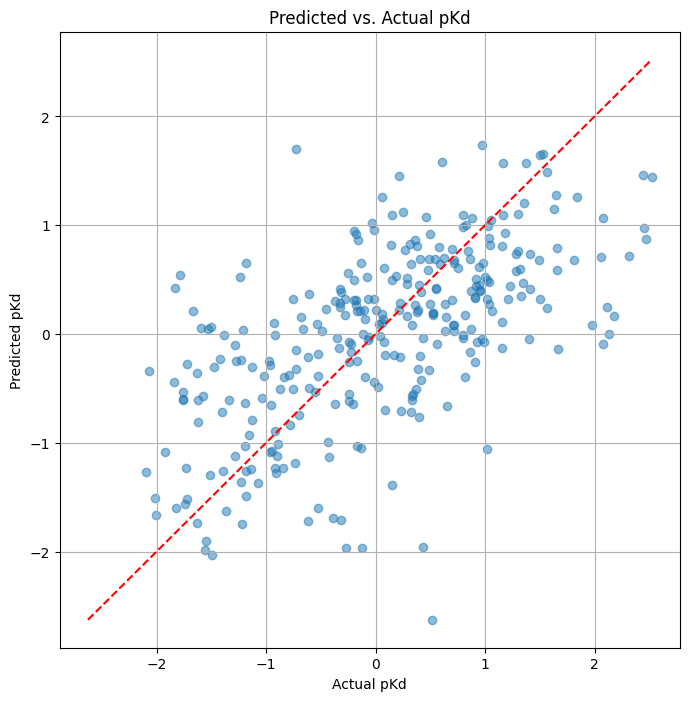

(0.7179261445999146,
 0.8473052251697227,
 0.3318154811859131,
 0.60625505,
 0.6291728417929937)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, loader, device='cpu'):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Compute metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    pearson, _ = pearsonr(actuals, predictions)
    spearman, _ = spearmanr(actuals, predictions)

    # Print metrics
    print("\n=== Evaluation Metrics ===")
    print(f"MSE:           {mse:.4f}")
    print(f"RMSE:          {rmse:.4f}")
    print(f"R² Score:      {r2:.4f}")
    print(f"Pearson's r:   {pearson:.4f}")
    print(f"Spearman's ρ:  {spearman:.4f}")

    # Plot predicted vs. actual
    plt.figure(figsize=(8, 8))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    min_val = min(min(actuals), min(predictions))
    max_val = max(max(actuals), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

    return mse, rmse, r2, pearson, spearman

# Run the evaluation
print("Evaluating on Test Set:")
evaluate_model(debug_model, test_loader, device='cpu')
